In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, Layout
from IPython.display import display
from scipy import stats
import ast  # Importing ast for safe conversion of string representations of lists to actual lists
import os  
from openpyxl import load_workbook

In [2]:
# Data Importation
DATA_FOLDER = '~/data/'
PATH = DATA_FOLDER+"combined_yield_price_common_data.csv"
# Creating a DataFrame to represent the activities available in different states
activity_df = pd.read_csv(PATH)

# Function to convert object columns to lists
def convert_columns_to_lists(df):
    """Converts object columns in the DataFrame to lists."""
    for column in df.columns[1:]:  # Skip the first column ('State')
        # Check if the column contains object data that should be lists
        if df[column].dtype == 'object':
            df[column] = df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    return df

# Assuming activity_df is your dataframe
activity_df = convert_columns_to_lists(activity_df)



In [3]:
class Location:
    """ Class to select a location from the available states. """

    def __init__(self):
        self.state = None  # This will hold the selected state

        # Create dropdown for states
        self.state_dropdown = widgets.Dropdown(
            options=activity_df['State'].tolist(),  # Use states from the DataFrame directly
            description='Select State:',
            disabled=False,
        )

        # Button to confirm selection
        self.confirm_button = widgets.Button(description="Confirm Location")
        self.confirm_button.on_click(self.confirm_selection)

        # Display the dropdown and button
        display(self.state_dropdown)
        display(self.confirm_button)

    def confirm_selection(self, b):
        """ Confirm the selected state and print the result. """
        self.state = self.state_dropdown.value
        print(f'Selected Location: {self.state}')
        

In [4]:
class Lifetime: 
    """ Class to input the project lifetime in years. """
    
    def __init__(self):
        self.years = None  # This will hold the selected year
    
        # Create text box for years
        self.years_widget = widgets.IntText(
                value=25,
                description='Enter Project Lifetime (years):',
                disabled=False
            )
    
        # Button to confirm selection
        self.confirm_button = widgets.Button(description="Confirm Year")
        self.confirm_button.on_click(self.confirm_selection)
    
        # Display the text box and button
        display(self.years_widget)
        display(self.confirm_button)
    
    def confirm_selection(self, b):
        """ Confirm the selected year and print the result. """
        self.years = self.years_widget.value
        print(f'Project Lifetime: {self.years} years')


In [5]:
class Partnership:
    """
    Define the Partnership Type between the Solar Developer and the Farmer in the AV case (not conventional).

    Partnership Types:
    - Option A: Solar Developer/Farmer (Land costs on Solar Developer, free land for farmer)
    - Option B: Solar Developer/Farmer (Land costs on Solar Developer to Farmer as payment)
    
    Parameters:
    - partnership_type: Type of partnership (Option A or Option B)
    - land_costs: Annual land costs ($/acre)
    - farmer_payment: Annual payment to the farmer based on land costs (calculated for Option B)
    """

    def __init__(self):
        # Initialize parameters
        self.partnership_type = None
        self.land_costs = None
        self.land_lease_payment = None  # Applicable only in Option B
        self.extra_payment = None
        
        # Create widgets for inputs
        self.partnership_dropdown = widgets.Dropdown(
            options=[
                'Option A: Farmer as land manager (Free land for farmer)',
                'Option B: Solar Developer goes into farmer own land (Farmer receives lease for land from SD)'
            ],
            description='Partnership Type:',
            value='Option A: Farmer as land manager (Free land for farmer)',
            style={'description_width': 'initial'}
        )

        self.land_costs_input = widgets.FloatText(
            description="Annual Land Costs for Solar Developer during Partnership A(SD)($/acre):",
            value=0,
            style={'description_width': 'initial'}
        )

        self.land_lease_payment_input = widgets.FloatText(
            description="Annual Lease Payment (SD to farmer-only in Partnership B) ($/acre):",
            value=0,
            style={'description_width': 'initial'}
        )

        self.extra_payment_input = widgets.FloatText(
            description="Extra Payment (SD to farmer-only in Partnership A) ($/acre)",
            value=0,
            style={'description_width': 'initial'}
        )

        # Button to confirm selection
        self.confirm_button = widgets.Button(description="Confirm Selection")
        self.confirm_button.on_click(self.confirm_selection)

        # Display widgets
        display(self.partnership_dropdown, self.land_costs_input, self.land_lease_payment_input, self.extra_payment_input, self.confirm_button)

    def confirm_selection(self, b):
        """ Store the values from the widgets and compute farmer payment if needed. """
        self.partnership_type = self.partnership_dropdown.value
        self.extra_payment = self.extra_payment_input.value
        
        if self.partnership_type.startswith("Option B"):
            # For Option B, calculate the farmer payment based on the land costs
            self.land_costs = 0
            self.land_lease_payment = self.land_lease_payment_input.value
            print(f"Partnership Type: {self.partnership_type}")
            print(f"Land Costs for SD (only in Partnership A): ${self.land_costs:.2f}/acre")
            print(f"Lease Payment (SD to farmer): ${self.land_lease_payment:.2f}/acre")
            print(f"Extra Payment (SD to farmer): ${self.extra_payment:.2f}/acre")
        else:
            # For Option A, there is no farmer payment
            self.land_costs = self.land_costs_input.value
            self.land_lease_payment = 0
            print(f"Partnership Type: {self.partnership_type}")
            print(f"Land Costs: ${self.land_costs:.2f}/acre")
            print(f"Lease Payment (SD to farmer): ${self.land_lease_payment} (Free land for farmer)")
            print(f"Extra Payment (SD to farmer): ${self.extra_payment:.2f}/acre")
        
    def output(self):
        """ Output the partnership details as a dictionary. """
        return {
            "Partnership Type": self.partnership_type,
            "Annual Land Costs ($/acre)": self.land_costs,
            "Lease Payment ($/acre)": self.land_lease_payment,
            "Extra Farmer Payment ($/acre)": self.extra_payment
        }


In [6]:
class CapexOpex:
    """
    Define and manage CAPEX and OPEX for PV and AV systems.
    """

    def __init__(self, system_type="Traditional"):
        # Initialize CAPEX and OPEX components with default values
        self.capex_components_traditional = {
            "Module": 0.35,
            "Inverter": 0.1,
            "BOS": 0.49,
            "Install Labor & Equipment": 0.26,
            "EPC Overhead": 0.17,
            "Sales Tax": 0.0,
            "Permitting Fee": 0.02,
            "Interconnection Fee": 0.04,
            "Contingency": 0.06,
            "Developer Overhead": 0.2,
            "EPC Developer Net Profit": 0.15,
        }

        self.capex_components_av_options = {
            "1AxisTracking/Bifacial/NormalClearance": {
                "Module": 0.35,
                "Inverter": 0.10,
                "BOS": 0.52,
                "Install Labor & Equipment": 0.27,
                "EPC Overhead": 0.18,
                "Sales Tax": 0.0,
                "Permitting Fee": 0.02,
                "Interconnection Fee": 0.04,
                "Contingency": 0.07,
                "Developer Overhead": 0.21,
                "EPC Developer Net Profit": 0.16,
            },
            "2AxisTracking/Bifacial/HighClearance": {
                "Module": 0.35,
                "Inverter": 0.10,
                "BOS": 0.82,
                "Install Labor & Equipment": 0.27,
                "EPC Overhead": 0.23,
                "Sales Tax": 0.0,
                "Permitting Fee": 0.02,
                "Interconnection Fee": 0.04,
                "Contingency": 0.09,
                "Developer Overhead": 0.24,
                "EPC Developer Net Profit": 0.20,
            },
            "Vertical/Bifacial": {
                "Module": 0.35,
                "Inverter": 0.10,
                "BOS": 0.56,
                "Install Labor & Equipment": 0.31,
                "EPC Overhead": 0.21,
                "Sales Tax": 0.0,
                "Permitting Fee": 0.02,
                "Interconnection Fee": 0.04,
                "Contingency": 0.07,
                "Developer Overhead": 0.22,
                "EPC Developer Net Profit": 0.17,
            },
        }

        self.opex_components_traditional = {
            "Cleaning": 2.7248,
            "Inspection":3.2344,
            "New BOS": 1.4456,
            "New Module": 0.2496,
            "New Inverter": 2.2672,
            "Land Lease": 4.16,
            "Property Tax": 2.0488,
            "Insurance": 2.5584,
            "Management": 1.8720,
        }

        self.opex_components_av = {
            "Inspection": 2.7248,
            "New BOS": 1.6848,
            "New Module": 0.2496,
            "New Inverter": 3.1512,
            "Property Tax": 2.7872,
            "Insurance": 3.4944,
            "Management": 3.0680,
        }

        # Set the system type (Traditional or AV)
        self.system_type = system_type
        self.current_av_capex = {}

        # Widgets for CAPEX inputs
        if system_type == "Traditional":
            self.capex_widgets = {
                key: widgets.FloatText(value=value, description=f"{key} [$/W]:", style={"description_width": "initial"})
                for key, value in self.capex_components_traditional.items()
            }
            self.opex_widgets = {
                key: widgets.FloatText(
                    value=value, description=f"{key} [$/kW]:", style={"description_width": "initial"}
                )
                for key, value in self.opex_components_traditional.items()
            }
        elif system_type == "AV":
            self.module_type_dropdown = widgets.Dropdown(
                options=list(self.capex_components_av_options.keys()),
                value="1AxisTracking/Bifacial/NormalClearance",
                description="Module Type:",
                style={"description_width": "initial"},
            )
            self.module_type_dropdown.observe(self.update_av_capex, names="value")

            # Initialize CAPEX widgets for AV
            self.current_av_capex = self.capex_components_av_options[self.module_type_dropdown.value]
            self.capex_widgets = {
                key: widgets.FloatText(value=value, description=f"{key} ($/W):", style={"description_width": "initial"})
                for key, value in self.current_av_capex.items()
            }
            self.opex_widgets = {
                key: widgets.FloatText(
                    value=value, description=f"{key} ($/W):", style={"description_width": "initial"}
                )
                for key, value in self.opex_components_av.items()
            }

        
        # Widget for project scale
        self.project_scales = [0.2, 0.5, 1, 5, 10, 15, 20]
        self.project_scale_widget = widgets.Dropdown(
            options=self.project_scales,
            value=0.5,
            description="Project Scale (MW):",
            style={"description_width": "initial"},
        )

        # Confirm button
        self.confirm_button = widgets.Button(description="Confirm Selection")
        self.confirm_button.on_click(self.confirm_selection)

        # Display widgets
        print("Additional Inputs:")
        display(self.project_scale_widget)
        if system_type == "AV":
            print("Select Module Type:")
            display(self.module_type_dropdown)
        print("CAPEX Components:")
        display(*self.capex_widgets.values())
        print("OPEX Components:")
        display(*self.opex_widgets.values())
        display(self.confirm_button)

    def update_av_capex(self, change):
        """Update CAPEX widgets based on the selected AV module type."""
        self.current_av_capex = self.capex_components_av_options[change["new"]]
        for key, widget in self.capex_widgets.items():
            widget.value = self.current_av_capex[key]

    def confirm_selection(self, b):
        """Store the selected CAPEX and OPEX values."""

        self.project_scale = self.project_scale_widget.value  # Store the selected project scale

        if self.system_type == "Traditional":
            self.capex_components_traditional = {
                key: widget.value for key, widget in self.capex_widgets.items()
            }
            self.opex_components_traditional = {
                key: widget.value for key, widget in self.opex_widgets.items()
            }
        elif self.system_type == "AV":
            self.current_av_capex = {
                key: widget.value for key, widget in self.capex_widgets.items()
            }
            self.opex_components_av = {
                key: widget.value for key, widget in self.opex_widgets.items()
            }

        print("Selection Confirmed")
        print(f"For a Project Scale: {self.project_scale} MW")

    def compute_total_unit_capex(self):
        """Compute the total Unit CAPEX."""
        if self.system_type == "Traditional":
            total_unit_capex = sum(self.capex_components_traditional.values())
        elif self.system_type == "AV":
            total_unit_capex = sum(self.current_av_capex.values())
        #print(f"Total CAPEX ({self.system_type}): ${total_unit_capex:,.2f}/W")
        return total_unit_capex

    def compute_total_unit_opex(self):
        """Compute the total OPEX."""
        if self.system_type == "Traditional":
            total_unit_opex = sum(self.opex_components_traditional.values())
        elif self.system_type == "AV":
            total_unit_opex = sum(self.opex_components_av.values())
        #print(f"Total OPEX ({self.system_type}): ${total_unit_opex:,.2f}/kW")
        return total_unit_opex
    
    def compute_total_unit_capex_for_scales(self):
        """
        Compute total CAPEX for all project scales based on the entered project scale.
        If the missing scale is below the entered scale, divide by the correct ratio.
        If the missing scale is above the entered scale, multiply by the correct ratio.
        """
        # Get the entered scale and total unit CAPEX for the entered scale
        entered_scale = self.project_scale_widget.value  # Scale for which the user entered CAPEX
        capex_values = (
            sum(self.capex_components_traditional.values())
            if self.system_type == "Traditional"
            else sum(self.current_av_capex.values())
        )

        # Define scale relationships
        scale_relationships = {
            (0.2, 0.5): 0.8454,
            (0.5, 1): 0.9143,
            (1, 5): 0.91875,
            (5, 10): 0.9455,
            (10, 15): 0.9671,
            (15, 20): 0.968,
        }

        # Sort scales for easier computation
        sorted_scales = sorted(self.project_scales)

        # Compute total unit CAPEX for each scale
        unit_capex_by_scale = {}
        for scale in sorted_scales:
            if scale == entered_scale:
                unit_capex_by_scale[scale] = capex_values
            elif scale < entered_scale:
                # Divide iteratively for scales below the entered scale
                capex = capex_values
                for (low, high), factor in scale_relationships.items():
                    if high <= entered_scale and low >= scale:
                        capex /= factor
                unit_capex_by_scale[scale] = capex
            elif scale > entered_scale:
                # Multiply iteratively for scales above the entered scale
                capex = capex_values
                for (low, high), factor in scale_relationships.items():
                    if low >= entered_scale and high <= scale:
                        capex *= factor
                unit_capex_by_scale[scale] = capex

        # Debugging: Print results
        print(f"Unit CAPEX values extrapolated for all scales based on {entered_scale} MW input:")
        for scale, total_capex in unit_capex_by_scale.items():
            print(f"  {scale} MW: ${total_capex:,.2f}/W")
        return unit_capex_by_scale
    
    
    def find_best_trendline(self):
        """
        Find the best trendline (linear, logarithmic, or power) for the CAPEX data across scales.

        Parameters:
        - total_capex_by_scale: Dictionary with project scales as keys and total CAPEX as values.

        Returns:
        - Best trendline type (linear, log, or power) and its coefficients.
        """
        # Extract scales and CAPEX values
        unit_capex_by_scale = self.compute_total_unit_capex_for_scales()
        scales = np.array(list(unit_capex_by_scale.keys()))
        capex_values = np.array(list(unit_capex_by_scale.values()))

        # Initialize best regression
        best_r2 = -np.inf
        best_type = None
        best_coefficients = None

        # 1. Linear regression
        slope, intercept, r_value, _, _ = stats.linregress(scales, capex_values)
        r2_linear = r_value**2
        if r2_linear > best_r2:
            best_r2 = r2_linear
            best_type = "Linear"
            best_coefficients = (slope, intercept)

        # 2. Logarithmic regression (Excel-style)
        if np.all(scales > 0):  # Logarithmic regression requires positive x-values
            log_scales = np.log(scales)
            slope, intercept, r_value, _, _ = stats.linregress(log_scales, capex_values)
            r2_log = r_value**2
            if r2_log > best_r2:
                best_r2 = r2_log
                best_type = "Logarithmic"
                best_coefficients = (slope, intercept)

        # 3. Power regression (Excel-style)
        if np.all(scales > 0) and np.all(capex_values > 0):  # Power regression requires positive x and y
            log_scales = np.log(scales)
            log_capex = np.log(capex_values)
            slope, intercept, r_value, _, _ = stats.linregress(log_scales, log_capex)
            r2_power = r_value**2
            if r2_power > best_r2:
                best_r2 = r2_power
                best_type = "Power"
                best_coefficients = (slope, np.exp(intercept)) # --> the regression is log(y) = slope * log(x) + intercept but we will have equation y = exp(intercept) * x^slope

        # Print the best regression results
        print(f"Best Trendline: {best_type}")
        print(f"R² Value: {best_r2:.4f}")
        print(f"Coefficients: {best_coefficients}")

        return best_type, best_coefficients, best_r2


In [7]:
class Activity:
    """ 
    Define the type of AV activity performed under the panels.
    """

    def __init__(self, location_instance, lifetime, activity_df):
        self.location = location_instance
        self.lifetime = lifetime
        self.activity_df = activity_df
        self.selected_crops = []  # To store the selected crops
        self.crop_area_percentages = {}  # Store area percentages for each crop
        self.num_crops = 0  # Number of crops specified by the user

        # Widgets to define the number of crops
        self.num_crops_selector = widgets.IntText(
            value=1,
            description="Number of Crops:",
            min=1,
            style={'description_width': 'initial'}
        )
        self.confirm_num_crops_button = widgets.Button(description="Confirm Number of Crops")
        self.confirm_num_crops_button.on_click(self.confirm_num_crops)

        # Containers for dynamic widgets
        self.crop_dropdowns = {}
        self.crop_area_sliders = {}
        self.years_checkboxes = {}
        self.tick_all_checkboxes = {}
        self.establishment_inputs = {}
        self.production_inputs = {}
        self.year_allocation = {}

        # Button to confirm selections
        self.confirm_button = widgets.Button(description="Confirm Selection")
        self.confirm_button.on_click(self.confirm_selection)

        # Display number of crops selector
        display(self.num_crops_selector, self.confirm_num_crops_button)

    def confirm_num_crops(self, b):
        """ Setup widgets dynamically based on the selected number of crops """
        self.num_crops = self.num_crops_selector.value
        print(f"Setting up for {self.num_crops} crops.")
        
        # Clear previous widgets if any
        self.crop_dropdowns.clear()
        self.crop_area_sliders.clear()
        self.years_checkboxes.clear()
        self.tick_all_checkboxes.clear()
        self.establishment_inputs.clear()
        self.production_inputs.clear()

        # Generate widgets for the specified number of crops
        for i in range(1, self.num_crops + 1):
            # Dropdowns
            self.crop_dropdowns[i] = widgets.Dropdown(
                options=[],  # Will be populated based on selected state
                description=f'Select Crop {i}:',
                disabled=False,
            )
            
            # Area sliders
            self.crop_area_sliders[i] = widgets.FloatSlider(
                value=1.0,
                min=0.0,
                max=1.0,
                step=0.01,
                description=f"Crop {i} Area %",
                style={'description_width': 'initial'},
                layout=widgets.Layout(display='none')  # Initially hidden
            )
            
            # Year checkboxes and tick-all checkbox
            self.years_checkboxes[i] = [
                widgets.Checkbox(value=False, description=f'Year {j+1}') 
                for j in range(self.lifetime.years)
            ]
            self.tick_all_checkboxes[i] = widgets.Checkbox(
                value=False,
                description="Tick All Years", 
                indent=False
            )
            self.tick_all_checkboxes[i].observe(self.update_all_years, names='value', type='change')
            
            # Establishment and production inputs
            self.establishment_inputs[i] = widgets.IntText(
                value=0,
                description=f"Crop {i} Establishment Years:",
                layout=widgets.Layout(width="300px")
            )
            self.production_inputs[i] = widgets.IntText(
                value=0,
                description=f"Crop {i} Production Years:",
                layout=widgets.Layout(width="300px")
            )

            # Display widgets
            display(self.crop_dropdowns[i])
            display(widgets.Label(value=f"Crop {i} Year Selection:"))
            display(self.tick_all_checkboxes[i])
            display(widgets.VBox(self.years_checkboxes[i]))
            display(self.crop_area_sliders[i])
            display(self.establishment_inputs[i])
            display(self.production_inputs[i])

        # Display the confirm button
        display(self.confirm_button)

        # Update crop dropdowns with options
        self.update_crop_dropdown()

        # Add logic to dynamically show sliders when crops are selected
        for i in range(1, self.num_crops + 1):
            self.crop_dropdowns[i].observe(self.update_area_sliders, names='value')

    def update_crop_dropdown(self):
        """ Update the crop dropdowns based on the selected state """
        selected_state = self.location.state

        if selected_state is not None:
            # Get the row corresponding to the selected state
            state_data = self.activity_df.loc[self.activity_df['State'] == selected_state]

            if not state_data.empty:
                non_zero_crops = [
                    column for column in state_data.columns[1:]  # Skip the first column (State)
                    if state_data[column].values[0][0] > 0  # Check if yield > 0
                ]

                # Update the crop dropdown options
                for dropdown in self.crop_dropdowns.values():
                    dropdown.options = non_zero_crops
                    # Reset selections
                    dropdown.value = None
            else:
                # Clear options if state data is empty
                for dropdown in self.crop_dropdowns.values():
                    dropdown.options = []

    def update_all_years(self, change):
        """ Automatically tick or untick all year checkboxes for a crop based on the "Tick All Years" checkbox. """
        for crop, tick_all_checkbox in self.tick_all_checkboxes.items():
            if change['owner'] == tick_all_checkbox:
                for year_checkbox in self.years_checkboxes[crop]:
                    year_checkbox.value = tick_all_checkbox.value

    def update_area_sliders(self, change):
        """ Show or hide area sliders based on selected crops """
        for i in range(1, self.num_crops + 1):
            slider = self.crop_area_sliders[i]
            if self.crop_dropdowns[i].value:  # If a crop is selected
                slider.layout.display = ''  # Show the slider
            else:
                slider.layout.display = 'none'  # Hide the slider

    def confirm_selection(self, b):
        """ Confirm the selected state and crops """
        selected_state = self.location.state
        self.selected_crops = [
            self.crop_dropdowns[i].value for i in range(1, self.num_crops + 1)
        ]
        self.selected_crops = [crop for crop in self.selected_crops if crop]  # Filter out None

        if self.selected_crops:
            print(f'Selected State: {selected_state}')
            print(f'Selected Crops: {" / ".join(self.selected_crops)}')

            for i, crop in enumerate(self.selected_crops, 1):
                years_selected = [j+1 for j, checkbox in enumerate(self.years_checkboxes[i]) if checkbox.value]
                print(f"{crop} will be grown in years: {years_selected}")
        else:
            print("Please select at least one crop.")

        # Collect area percentages
        self.crop_area_percentages = {
            crop: self.crop_area_sliders[i].value
            for i, crop in enumerate(self.selected_crops, 1)
        }

        # # Normalize percentages for each year
        # for year in range(1, self.lifetime.years + 1):
        #     total_percentage = sum(
        #         self.crop_area_percentages.get(crop, 0)
        #         for i, crop in enumerate(self.selected_crops, 1)
        #         if year in self.output()['crop_years'][crop]['selected_years']
        #     )
        #     if total_percentage > 1.0:
        #         raise ValueError(f"Crop area percentages for year {year} exceed 100% of the area.")

        # Add logic to process establishment and production years
        self.establishment_years_dict = {
            crop: self.establishment_inputs[i].value for i, crop in enumerate(self.selected_crops, 1)
        }
        self.production_years_dict = {
            crop: self.production_inputs[i].value for i, crop in enumerate(self.selected_crops, 1)
        }

        # Allocate establishment and production years
        self.allocate_years()
                
        # Print year allocation for each selected crop
        for crop in self.selected_crops:
            allocation = self.year_allocation.get(crop, {})
            if allocation:
                print(f"{crop} Establishment Years: {allocation['establishment_years']}, "
                    f"Production Years: {allocation['production_years']}")
                

    def allocate_years(self):
        """ Allocate establishment and production years for each crop """
        

        for i, crop in enumerate(self.selected_crops, 1):
            selected_years = [j+1 for j, checkbox in enumerate(self.years_checkboxes[i]) if checkbox.value]
            establishment_duration = self.establishment_years_dict.get(crop, 0)
            production_duration = self.production_years_dict.get(crop, 0)

            if len(selected_years) != (establishment_duration + production_duration):
                print(f"Error: Total selected years for {crop} do not match the establishment and production durations.")
                continue

            self.year_allocation[crop] = {
                "establishment_years": selected_years[:establishment_duration],
                "production_years": selected_years[establishment_duration:establishment_duration + production_duration]
            }

    def output(self):
        """ 
        Returns the selected state, crops, crop-year allocations,
        and crop area percentages as a structured dictionary.
        """
        crop_years = {
            crop: {
                "selected_years": [j+1 for j, checkbox in enumerate(self.years_checkboxes[i]) if checkbox.value],
                "establishment_years": self.year_allocation.get(crop, {}).get("establishment_years", []),
                "production_years": self.year_allocation.get(crop, {}).get("production_years", [])
            }
            for i, crop in enumerate(self.selected_crops, 1)
        }

        return {
            "state": self.location.state,
            "selected_crops": self.selected_crops,
            "crop_years": crop_years,
            "crop_area_percentages": {crop: self.crop_area_percentages.get(crop, 1.0) for crop in self.selected_crops}
        }


In [8]:
class FinancialRates:
    """
    Define Financial Rates with user inputs for:
    - Real Discount rate (%)
    - Inflation rate (%)
    - State Tax rate (if not provided, fetched from rates database) (%)
    - Federal Tax rate (%)
    - Investment Tax Credit (ITC) rate (%)
    - Project lifetime (years)
    - Performance-Based Incentive (PBI) in $/kWh
    - Solar Renewable Energy Credit (SREC) in $/kWh
    - Duration of SREC program (years)
    - Farmer Payment in $/Wp
    - Debt Share (%)
    - Debt Interest Rate (%) (also called Cost of Debt)


    
    Additionally:
    - Methods to calculate nominal discount rate, discount factor and CRF, while avoiding recalculations.
    """

    def __init__(self, location, lifetime):
        self.location = location
        self.lifetime = lifetime
        
        # Input widgets for user-defined parameters
        self.real_discount_rate_widget = widgets.FloatText(description='Real Discount Rate (%):', value=0)
        self.inflation_rate_widget = widgets.FloatText(description='Inflation Rate (%):', value=0)
        self.itc_rate_widget = widgets.IntText(description='Investment Tax Credit (ITC):', value=0)
        self.fed_tax_rate_pv_widget = widgets.FloatText(description='Federal Tax Rate PV(%):', value=0)
        self.fed_tax_rate_agri_widget = widgets.FloatText(description='Federal Tax Rate Agri(%):', value=0)
        self.state_tax_rate_pv_widget = widgets.FloatText(description='State Tax Rate PV(%):', value=0)
        self.state_tax_rate_agri_widget = widgets.FloatText(description='State Tax Rate Agri(%):', value=0)
        self.pbi_widget = widgets.FloatText(description='PBI ($/kWh):', value=0)
        self.srec_widget = widgets.FloatText(description='SREC ($/kWh):', value=0)
        self.srec_duration_widget = widgets.IntText(description='SREC Program Duration (years):', value=0)
        self.energy_price_escalation_widget = widgets.FloatText(description='Energy Price Escalation Rate (%):', value=0)
        self.debt_share_widget = widgets.FloatText(description='Debt Share (%):', value=0)
        self.debt_interest_rate_widget = widgets.FloatText(description='Debt Interest Rate (%):', value=0)
        self.equity_cost_widget = widgets.FloatText(description='Equity Cost (%):', value=0)
        
        # Button to confirm the values
        self.confirm_button = widgets.Button(description="Confirm Financial Rates")
        self.confirm_button.on_click(self.confirm_selection)
        
        # Display widgets
        display(self.real_discount_rate_widget, self.inflation_rate_widget, 
                self.itc_rate_widget, self.fed_tax_rate_pv_widget, self.fed_tax_rate_agri_widget, 
                self.state_tax_rate_pv_widget, self.state_tax_rate_agri_widget, 
                self.pbi_widget, self.srec_widget, self.srec_duration_widget, self.energy_price_escalation_widget, 
                self.debt_share_widget, self.debt_interest_rate_widget, self.equity_cost_widget,
                self.confirm_button)
        
        # Initialize attributes
        self.real_discount_rate = None
        self.inflation_rate = None
        self.itc_rate = None
        self.fed_tax_rate_pv = None
        self.fed_tax_rate_agri = None
        self.state_tax_rate_pv = None
        self.state_tax_rate_agri = None
        self.pbi = None
        self.srec = None
        self.srec_duration = None
        self.energy_price_escalation_rate = None
        self.nominal_discount_rate = None
        self.discount_factors = None
        self.crf = None
        self.debt_share = None
        self.debt_interest_rate = None
        self.equity_cost = None
        self.wacc = None
    

    def confirm_selection(self, b):
        """ Store the values and fetch rates if necessary """

        # Set real discount rate, use default if user enters 0
        if self.real_discount_rate_widget.value == 0:
            self.real_discount_rate = 0.08  # 8% default
            print(f"Using default real discount rate: {self.real_discount_rate * 100}%")
        else:
            self.real_discount_rate = self.real_discount_rate_widget.value / 100
            print(f"User entered real discount rate: {self.real_discount_rate * 100}%")

        # Set inflation rate, use default if user enters 0
        if self.inflation_rate_widget.value == 0:
            self.inflation_rate = 0.025  # 2.5% default
            print(f"Using default inflation rate: {self.inflation_rate * 100}%")
        else:
            self.inflation_rate = self.inflation_rate_widget.value / 100
            print(f"User entered inflation rate: {self.inflation_rate * 100}%")
        
        # Set the nominal discount rate from the two above rates (don't use get method since you will use the self.nominal_discount_rate later for sensitivity analysis)
        self.get_nominal_discount_rate()
        print(f"Nominal Discount Rate: {self.nominal_discount_rate * 100}%")

        # Set itc rate, use default if user enters 0
        if self.itc_rate_widget.value == 0:
            self.itc_rate = 0.3  # 30% default
            print(f"Using default itc rate: {self.itc_rate * 100}%")
        else:
            self.itc_rate = self.itc_rate_widget.value / 100
            print(f"User entered itc rate: {self.itc_rate * 100}%")

        
        # Federal tax rate (PV and agriculture)
        self.fed_tax_rate_pv = self.fed_tax_rate_pv_widget.value / 100
        self.fed_tax_rate_agri = self.fed_tax_rate_agri_widget.value / 100

        # State tax rate (PV and agriculture)
        self.state_tax_rate_pv = self.state_tax_rate_pv_widget.value / 100 
        self.state_tax_rate_agri = self.state_tax_rate_agri_widget.value / 100
        
        # Set PBI and SREC values
        self.pbi = self.pbi_widget.value
        self.srec = self.srec_widget.value
        self.srec_duration = self.srec_duration_widget.value

        # Escalation Rate 
        self.energy_price_escalation_rate = self.energy_price_escalation_widget.value / 100

        # Set debt share
        self.debt_share = self.debt_share_widget.value / 100
        self.debt_interest_rate = self.debt_interest_rate_widget.value / 100

        # Set equity cost
        self.equity_cost = self.equity_cost_widget.value / 100

        # Set WACC
        self.get_wacc()
        
        # Print confirmed values
        print(f"Financial Rates:\nReal Discount Rate: {self.real_discount_rate * 100}%\n"
              f"Inflation Rate: {self.inflation_rate * 100}%\nNominal Discount Rate: {self.nominal_discount_rate * 100}%\n"
              f"Federal Tax Rate PV: {self.fed_tax_rate_pv * 100}%\nFederal Tax Rate agri: {self.fed_tax_rate_agri * 100}%\n"
              f"State Tax Rate PV: {self.state_tax_rate_pv * 100}%\nState Tax Rate agri: {self.state_tax_rate_agri * 100}%\nITC Rate: {self.itc_rate * 100}%\n"
              f"PBI: {self.pbi} $/kWh\nSREC: {self.srec} $/kWh\nSREC Duration: {self.srec_duration} years\n"
              f"Energy Price Escalation Rate: {self.energy_price_escalation_rate * 100}%\n"
              f"Debt Share: {self.debt_share * 100}%\nDebt Interest Rate: {self.debt_interest_rate * 100}%\nEquity Cost: {self.equity_cost * 100}%\nWACC: {self.wacc * 100}%")

    def get_nominal_discount_rate(self):
        """ Compute the nominal discount rate """
        self.nominal_discount_rate = (1 + self.real_discount_rate) * (1 + self.inflation_rate) - 1
        return self.nominal_discount_rate
    
    def get_equity_share(self):
        """ Calculate the equity share """
        return 1 - self.debt_share
    
    def get_effective_tax_rate(self):
        """ 
        Calculate the effective tax rate
        Assume to be the same for both energy and farm businesses 
        """
        return self.state_tax_rate_pv + self.fed_tax_rate_pv * (1-self.state_tax_rate_pv)
    
    def get_wacc(self):
        """ 
        Calculate the Weighted Average Cost of Capital (WACC) 
        """
        self.wacc = self.debt_share * self.debt_interest_rate * (1 - self.get_effective_tax_rate()) + self.get_equity_share() * self.equity_cost
        return self.wacc

    def get_crf(self):
        """ 
        Compute the Capital Recovery Factor (CRF) 
        """
        r = self.wacc # Use WACC since CRF only used in FEAD+ model where WACC is used
        n = self.lifetime.years
        self.crf = (r * (1 + r) ** n) / (((1 + r) ** n) - 1)
        return self.crf
    
    def output(self):
        """ Output the confirmed values """
        return [self.real_discount_rate, self.fed_tax_rate_pv, self.fed_tax_rate_agri, 
                self.state_tax_rate_pv, self.state_tax_rate_agri, self.inflation_rate, 
                self.nominal_discount_rate, self.itc_rate, self.pbi, self.srec, 
                self.srec_duration, self.energy_price_escalation_rate, self.get_crf(), 
                self.debt_share, self.debt_interest_rate, self.get_equity_share(), self.equity_cost, self.wacc]


In [9]:
class TraditionalEconomics:
    """
    Define the Traditional Economics for the PV system and agricultural systems.

    Inputs:
    - tradcropcosts: Traditional avg cost of crops sold (COGS) ($/acre) 
    - tradcropyield: Traditional avg crop yield (t/acre)
    - tradcropprice: Traditional avg crop price ($/t)
    - tradPVyield: Traditional avg PV yield (kWh/kWp)
    - tradPVprice: Traditional avg PV price ($/kWh)
    - tradPVcapex: Capex for solo PV ($)
    - tradPVopex: Opex for solo PV ($/yr)
    - tradcropcapex: Capex for each agricultural system ($)

    If user enters 0, the corresponding value is fetched from the provided datasets.
    """

    def __init__(self, location, activity, lifetime, merged_df, financial_rates, capex_opex_trad):
        # Store the datasets and state/activity
        self.location = location
        self.activity = activity  # Now includes multiple crops
        self.lifetime = lifetime
        self.merged_df = merged_df
        self.financial_rates = financial_rates
        self.capex_opex = capex_opex_trad

        # Constant
        self.unitopex_gmpv = self.capex_opex.compute_total_unit_opex()  # $/kWdc

        # Initialize Widgets for crops
        self.detailed_variable_costs_widgets = {
            "establishment": {},
            "production": {}
        }
        self.detailed_fixed_costs_widgets = {
            "establishment": {},
            "production": {}
        }
        self.tradcropyield_widgets = {}
        self.tradcropprice_widgets = {}
        self.tradcropcapex_widgets = {}

        self.tradPVpanelpower_widget = self.create_widget('Panel Nameplate Power (Wdc):')
        self.tradPVpower_widget = self.create_widget('PV total power (kW):')
        self.tradPVdegrate_widget = self.create_widget('Degradation Rate (%):')
        self.tradareapower_widget = self.create_widget('Total Area/power (acre/kW):')
        self.tradPVrowspacing_widget = self.create_widget('Row Spacing (ft):')
        self.tradPVgroundclearance_widget = self.create_widget('Ground Clearance (ft):')
        self.tradPVarraylength_widget = self.create_widget('Length Array (ft) [#panelrow/array * length/panel]:')
        self.tradPVarraywidth_widget = self.create_widget('Width Array (ft) [#panels/array * width/panel]:')
        self.tradPVpanelarray_widget = self.create_widget('Number of Panels per Array (-):')
        self.tradPVyield_widget = self.create_widget('PV Yield (kWh/kWp):')
        self.tradPVprice_widget = self.create_widget('PV Price ($/kWh):')

        # Placeholder variables to store values
        self.detailed_variable_costs = {
            "establishment": {},
            "production": {}
        }
        self.detailed_fixed_costs = {
            "establishment": {},
            "production": {}
        }
        self.tradcropyield = {}
        self.tradcropprice = {}
        self.tradcropcapex = {}
        self.tradPVpanelpower = None
        self.tradPVpower = None
        self.tradPVdegrate = None
        self.tradareapower = None
        self.tradarea = None
        self.tradPVrowspacing = None
        self.tradPVgroundclearance = None
        self.tradPVarraylength = None
        self.tradPVarraywidth = None
        self.tradPVpanelarray = None
        self.tradPVyield = None
        self.tradPVprice = None
        self.tradPVcapex = None
        self.tradPVopex = None

        # Dynamically create crop-specific widgets
        self.create_crop_widgets()

        # Confirm button
        self.confirm_button = widgets.Button(description="Confirm Traditional Economics")
        self.confirm_button.on_click(self.confirm_selection)

        # Display widgets
        print(f"Traditional PV Settings")
        display(self.tradPVpower_widget, self.tradPVpanelpower_widget, self.tradPVdegrate_widget, self.tradareapower_widget, 
                self.tradPVrowspacing_widget, self.tradPVgroundclearance_widget, 
                self.tradPVarraylength_widget, self.tradPVarraywidth_widget, self.tradPVpanelarray_widget,
                self.tradPVyield_widget, self.tradPVprice_widget, self.confirm_button)
        
    def create_widget(self, description):
        """Helper to create a styled widget with a specified description."""
        return widgets.FloatText(
            description=description,
            value=0,
            style={'description_width': 'initial'},  # Ensures the description fits without truncation
            layout=Layout(width='700px')  # Adjust width as needed
        )
    def create_detailed_costs_widgets(self, crop, phase):
        """
        Create widgets for detailed costs (variable or fixed) for a specific crop, phase.
        Used for the production phase where costs are the same each year.

        Parameters:
        - crop: Name of the crop (e.g., 'PEPPERS, BELL')
        - phase: 'establishment' or 'production' --> here only production will be used 

        Returns:
        - A dictionary of widgets for detailed costs
        """
        variable_costs = {
            "Establishment & Soil Preparation": self.create_widget(f"{crop} {phase.capitalize()} Establishment & Soil Preparation Costs ($/acre):"),
            "Field Activities": self.create_widget(f"{crop} {phase.capitalize()} Field Activities Costs ($/acre):"),
            "Harvest Activities": self.create_widget(f"{crop} {phase.capitalize()} Harvest Activities Costs ($/acre):"),
            "Packing & Handling Charges": self.create_widget(f"{crop} {phase.capitalize()} Packing & Handling Charges Costs ($/acre):"),
            "Maintenance & Repairs": self.create_widget(f"{crop} {phase.capitalize()} Maintenance & Repairs Costs ($/acre):"),
            "Other Variable Costs": self.create_widget(f"{crop} {phase.capitalize()} Other Variable Costs ($/acre):"),
        }

        fixed_costs = {
            "Machine Equipment & Building Depreciation": self.create_widget(f"{crop} {phase.capitalize()} Machine Equipment & Building Depreciation Costs ($/acre):"),
            "Land Depreciation": self.create_widget(f"{crop} {phase.capitalize()} Land Depreciation Costs ($/acre):"),
            "Machine Equipment & Building Interests": self.create_widget(f"{crop} {phase.capitalize()} Machine Equipment & Building Interests Costs ($/acre):"),
            "Land Interests": self.create_widget(f"{crop} {phase.capitalize()} Land Interests Costs ($/acre):"),
            "Land & Property Taxes": self.create_widget(f"{crop} {phase.capitalize()} Land & Property Taxes ($/acre):"),
            "Miscellaneous Supplies Costs": self.create_widget(f"{crop} {phase.capitalize()} Miscellaneous Supplies Costs ($/acre):"),
            "Insurance Costs": self.create_widget(f"{crop} {phase.capitalize()} Insurance Costs ($/acre):"),
            "Management Costs": self.create_widget(f"{crop} {phase.capitalize()} Management Costs ($/acre):"),
        }

        return variable_costs, fixed_costs

    def create_crop_widgets(self):
        """Dynamically create widgets for each selected crop."""
        for crop in self.activity.selected_crops:
            print(f"Creating widgets for crop: {crop}")

            # Create detailed costs widgets for both establishment and production phases
            # Establishement Costs Widgets (for establishement years costs are different each year)

            activity_output = self.activity.output()
            establishment_years = activity_output.get('crop_years', {}).get(crop, {}).get("establishment_years", [])

            self.detailed_variable_costs_widgets["establishment"][crop] = {
                year: self.create_detailed_costs_widgets(crop, "establishment")[0]
                for year in establishment_years
            }
            self.detailed_fixed_costs_widgets["establishment"][crop] = {
                year: self.create_detailed_costs_widgets(crop, "establishment")[1]
                for year in establishment_years
            }
            # Production Costs Widgets (for production years costs are the same each year)
            self.detailed_variable_costs_widgets["production"][crop], self.detailed_fixed_costs_widgets["production"][crop] = self.create_detailed_costs_widgets(crop, "production")      


            # Yield widgets for establishment years
            self.tradcropyield_widgets.setdefault("establishment", {}).setdefault(crop, {})
            for year in establishment_years:
                self.tradcropyield_widgets["establishment"][crop][year] = self.create_widget(f'{crop} Yield (t/acre) for Year {year}:')
                
            # Yield widget for production years
            self.tradcropyield_widgets.setdefault("production", {}).setdefault(crop, {})
            self.tradcropyield_widgets["production"][crop] = self.create_widget(f'{crop} Yield (t/acre) for Production Years:')
            
            # Other crop-specific Economics Widgets
            #yield_widget = self.create_widget(f'{crop} Yield (t/acre):')
            #self.tradcropyield_widgets[crop] = yield_widget
            price_widget = self.create_widget(f'{crop} Price ($/t):')
            self.tradcropprice_widgets[crop] = price_widget
            capex_widget = self.create_widget(f'{crop} Unit Capex ($/acre):')
            self.tradcropcapex_widgets[crop] = capex_widget

            # Display widgets for the crop
            for year, widgets_dict in self.detailed_variable_costs_widgets["establishment"][crop].items():
                print(f"Detailed Variable Costs for {crop} (Establishment, Year {year})")
                for component, widget in widgets_dict.items():
                    display(widget)
            
            for year, widgets_dict in self.detailed_fixed_costs_widgets["establishment"][crop].items():
                print(f"Detailed Fixed Costs for {crop} (Establishment, Year {year})")
                for component, widget in widgets_dict.items():
                    display(widget)

            print(f"Detailed Variable Costs for {crop} (Production)")
            for widget in self.detailed_variable_costs_widgets["production"][crop].values():
                display(widget)

            print(f"Detailed Fixed Costs for {crop} (Production)")
            for widget in self.detailed_fixed_costs_widgets["production"][crop].values():
                display(widget)
    
            print(f"Rest of crop economics for {crop}")
            for year in establishment_years:
                display(self.tradcropyield_widgets["establishment"][crop][year])
            display(self.tradcropyield_widgets["production"][crop])
            display(price_widget, capex_widget)
            
    
    def derived_variables(self):
        self.tradarea = self.tradareapower * self.tradPVpower
        print(f"Total Site Area: {self.tradarea} acres")

    def traditional_capex_opex(self):
        # CAPEX and OPEX are to be computed via internal formula (values modified in capex_opex class)
        
        # Use the best trendline from the CapexOpex class
        best_trendline, coefficients, _ = self.capex_opex.find_best_trendline()
            
        # Calculate CAPEX based on the selected trendline
        if best_trendline == "Linear":
            slope, intercept = coefficients
            self.tradPVcapex = (slope * (self.tradPVpower*1e-3) + intercept) * (self.tradPVpower * 1e3)
        elif best_trendline == "Logarithmic":
            slope, intercept = coefficients
            self.tradPVcapex = (slope * np.log(self.tradPVpower*1e-3) + intercept) * (self.tradPVpower * 1e3)
        elif best_trendline == "Power":
            slope, intercept = coefficients  # intercept is already exponentiated in the best_trendline method
            self.tradPVcapex = (intercept * ((self.tradPVpower*1e-3) ** slope)) * (self.tradPVpower * 1e3)

        print(f"PV Capex from best trendline ({best_trendline}): {self.tradPVcapex} $")
        
        # Calculate OPEX based on the unit OPEX from the capex_opex class
        self.tradPVopex = self.unitopex_gmpv*self.tradPVpower
        print(f"PV Opex from internal formula: {self.tradPVopex} $/yr")

    def confirm_selection(self, b):
        """ Store the values from the widgets and fetch defaults if necessary. """

        # 1- Traditional PV parameters
        self.tradPVpower = self.tradPVpower_widget.value
        print(f"PV Power: {self.tradPVpower} kW")
        self.tradPVpanelpower = self.tradPVpanelpower_widget.value*1e-3
        print(f"Panel STC Wdc: {self.tradPVpanelpower*1000} Wdc")
        self.tradPVdegrate = self.tradPVdegrate_widget.value/100
        print(f"Degradation Rate: {self.tradPVdegrate*100}%")
        self.tradareapower = self.tradareapower_widget.value
        print(f"Total Area/Power: {self.tradareapower} acre/kW")
        self.tradPVrowspacing = self.tradPVrowspacing_widget.value
        print(f"Row Spacing: {self.tradPVrowspacing} ft")
        self.tradPVgroundclearance = self.tradPVgroundclearance_widget.value
        print(f"Ground Clearance: {self.tradPVgroundclearance} ft")
        self.tradPVarraylength = self.tradPVarraylength_widget.value
        print(f"Lenght Array: {self.tradPVarraylength} ft")
        self.tradPVarraywidth = self.tradPVarraywidth_widget.value
        print(f"Width Array: {self.tradPVarraywidth} ft")
        self.tradPVpanelarray = self.tradPVpanelarray_widget.value
        print(f"Number of Panels per Array: {self.tradPVpanelarray}")
        self.tradPVyield = self.tradPVyield_widget.value
        print(f"PV Yield: {self.tradPVyield} kWh/kWp")
        self.tradPVprice = self.tradPVprice_widget.value
        print(f"PV Price: {self.tradPVprice} $/kWh")

        # Calculate derived variables   
        self.derived_variables()

        # CAPEX and OPEX are to be computed via internal formula (values modified in capex_opex class)
        self.traditional_capex_opex()

        # 2- Traditional Crop Parameters 
        for crop in self.activity.selected_crops:
        
            # 2a- Handle Establishment Costs 
            activity_output = self.activity.output()
            establishment_years = activity_output.get('crop_years', {}).get(crop, {}).get("establishment_years", [])

            for year in establishment_years:
                # Detailled Variable Costs (retrieve + store)
                detailed_var_est_costs = self.detailed_variable_costs_widgets["establishment"][crop][year]
                self.detailed_variable_costs.setdefault("establishment", {}).setdefault(crop, {}).setdefault(year, {}).update(
                    {component: widget.value for component, widget in detailed_var_est_costs.items()}
                )

                # Detailed Fixed Costs
                detailed_fix_est_costs = self.detailed_fixed_costs_widgets["establishment"][crop][year]
                self.detailed_fixed_costs.setdefault("establishment", {}).setdefault(crop, {}).setdefault(year, {}).update(
                    {component: widget.value for component, widget in detailed_fix_est_costs.items()}
                )   


            # 2b- Handle Production Costs
            
            # Detailed Variable Costs 
            # detailed_var_prod_costs = self.detailed_variable_costs_widgets["production"][crop]
            # self.detailed_variable_costs.setdefault("production", {}).setdefault(crop, {}).update(
            #     {component: widget.value for component, widget in detailed_var_prod_costs.items()}
            # )

            # For variable costs (same every year during production)
            detailed_var_prod_costs = self.detailed_variable_costs_widgets["production"][crop]
            for component, widget in detailed_var_prod_costs.items():
                value = widget.value
                #print(f"DEBUG: Storing Production Variable Cost for {crop}, Component: {component}, Value: {value}")
                self.detailed_variable_costs.setdefault("production", {}).setdefault(crop, {})[component] = widget.value

            # Detailed Fixed Costs
            # detailed_fix_prod_costs = self.detailed_fixed_costs_widgets["production"][crop]
            # self.detailed_fixed_costs.setdefault("production", {}).setdefault(crop, {}).update(
            #     {component: widget.value for component, widget in detailed_fix_prod_costs.items()}
            # )

            detailed_fix_prod_costs = self.detailed_fixed_costs_widgets["production"][crop]
            for component, widget in detailed_fix_prod_costs.items():
                value = widget.value
                #print(f"DEBUG: Storing Production Fixed Cost for {crop}, Component: {component}, Value: {value}")
                self.detailed_fixed_costs.setdefault("production", {}).setdefault(crop, {})[component] = widget.value



            # 2c- Handle Crop Yield 
            # yield_value = self.tradcropyield_widgets[crop].value or \
            #             self.merged_df.loc[self.merged_df['State'] == self.location.state, crop].values[0][0]
            # self.tradcropyield[crop] = yield_value  # Store in a dictionary
            # print(f"Yield for {crop}: {yield_value} t/acre")


            # Store yield for establishment years
            self.tradcropyield.setdefault("establishment", {}).setdefault(crop, {})
            for year in establishment_years:
                yield_value = self.tradcropyield_widgets["establishment"][crop][year].value
                self.tradcropyield["establishment"][crop][year] = yield_value
                print(f"DEBUG: Stored Yield for {crop}, Year {year}: {yield_value} t/acre")

            # Store yield for production years
            self.tradcropyield.setdefault("production", {}).setdefault(crop, {})
            yield_value = self.tradcropyield_widgets["production"][crop].value
            self.tradcropyield["production"][crop] = yield_value
            print(f"DEBUG: Stored Yield for {crop}, Production Years: {yield_value} t/acre")

    
            # 2d- Handle crop price
            price = self.tradcropprice_widgets[crop].value or \
                    self.merged_df.loc[self.merged_df['State'] == self.location.state, crop].values[0][1]
            self.tradcropprice[crop] = price  # Store in dictionary
            print(f"Price for {crop}: {price} $/t")
        
            # 2e- Handle crop capex
            capex = self.tradcropcapex_widgets[crop].value
            self.tradcropcapex[crop] = capex  # Store in a dictionary
            print(f"Capex for {crop}: {capex} $/acre")

        print("All values confirmed.")
    
    def get_trad_crop_yield(self, t):
        """
        Retrieve yield values for each crop for year t.
        """
        activity_output = self.activity.output()
        crop_years = activity_output.get('crop_years', {})
            
        establishment_crops = [
            crop for crop, years in crop_years.items() if t in years.get("establishment_years", [])
        ]
        production_crops = [
            crop for crop, years in crop_years.items() if t in years.get("production_years", [])
        ]

        yields = {}
        for crop in establishment_crops:
            yields[crop] = self.tradcropyield["establishment"][crop].get(t, 0)  # Default to 0 if not found

        for crop in production_crops:
            yields[crop] = self.tradcropyield["production"][crop]  # Production yield is the same for all years

        return yields
    
    def get_trad_crop_revenues(self, t):
        """
        Calculate revenues for crops for a given year t.

        This method dynamically handles both establishment and production years by relying on
        the `get_trad_crop_yield` method, which already accounts for the correct yield.
        """
        activity_output = self.activity.output()
        crop_years = activity_output.get('crop_years', {})  # Safely access the 'crop_years' dictionary

        # Retrieve dynamic crop yields for the given year
        crop_yields = self.get_trad_crop_yield(t)
    
        # Calculate total revenues
        if t > 0:
            total_revenues = sum(
                crop_yields.get(crop, 0) * self.tradcropprice.get(crop, 0) * self.tradarea *
                self.activity.crop_area_percentages.get(crop, 1.0)
                for crop in crop_years
            )
        else:
            total_revenues = 0
        return total_revenues

    # Detailed Variable and Fixed Costs in $/yr and $/yr
    
    def get_trad_crop_detailed_variable_costs(self, t):
        """
        Calculate detailed variable costs for each crops for year t, handling either establishment or production.

        Parameters:
        - t: Year for which the costs are calculated.

        Returns:
        - Dictionary where each crop has a sub-dictionary of detailed variable costs per component for year t.
        """
        activity_output = self.activity.output()
        crop_years = activity_output.get('crop_years', {})

        # Determine phase based on year
        establishment_crops = [
            crop for crop, years in crop_years.items() if t in years.get("establishment_years", [])
        ]
        production_crops = [
            crop for crop, years in crop_years.items() if t in years.get("production_years", [])
        ]
        #print(f"DEBUG: Year {t}, Production Crops: {production_crops}")

        # Fetch detailed costs for the relevant phase
        if establishment_crops:
            phase = "establishment"
            relevant_crops = establishment_crops
        elif production_crops:
            phase = "production"
            relevant_crops = production_crops
        else:
            return {}  # No costs if the year is not part of establishment or production

        #print(f"DEBUG: Retrieving {phase} costs for Year {t}. Relevant Crops: {relevant_crops}")
        detailed_costs = self.detailed_variable_costs[phase]
        #print(f"DEBUG: Retrieved Production Variable Costs for Year {t}: {detailed_costs}")

        result = {}
        for crop in relevant_crops:
            if phase == "production":
                # Production costs might not be year-specific
                crop_costs = detailed_costs.get(crop, {})  # Retrieve costs directly
                if not isinstance(crop_costs, dict) or not crop_costs:  # Handle empty or invalid entries
                    print(f"DEBUG: No valid production costs found for crop {crop} in Year {t}")
                    continue
            else:
                # Establishment costs are year-specific
                crop_costs = detailed_costs.get(crop, {}).get(t, {})

            # Calculate component costs
            if t>0:
                result[crop] = {
                    component: cost * self.tradarea * self.activity.crop_area_percentages.get(crop, 1.0)
                    for component, cost in crop_costs.items()
                }
            else:
                result[crop] = {
                    component: 0 * self.tradarea * self.activity.crop_area_percentages.get(crop, 1.0)
                    for component, cost in crop_costs.items()
                }

        #print(f"DEBUG: Final detailed variable costs for Year {t}: {result}")
        return result
    
    def get_trad_crop_detailed_fixed_costs(self, t):
        """
        Calculate detailed fixed costs for each crops for year t, handling either establishment or production.

        Parameters:
        - t: Year for which the costs are calculated.

        Returns:
        - Dictionary where each crop has a sub-dictionary of detailed fixed costs per component for year t.
        """
        activity_output = self.activity.output()
        crop_years = activity_output.get('crop_years', {})

        # Determine phase based on year
        establishment_crops = [
            crop for crop, years in crop_years.items() if t in years.get("establishment_years", [])
        ]
        production_crops = [
            crop for crop, years in crop_years.items() if t in years.get("production_years", [])
        ]
        #print(f"DEBUG: Year {t}, Production Crops: {production_crops}")

        # Fetch detailed costs for the relevant phase
        if establishment_crops:
            phase = "establishment"
            relevant_crops = establishment_crops
        elif production_crops:
            phase = "production"
            relevant_crops = production_crops
        else:
            return {}  # No costs if the year is not part of establishment or production

        #print(f"DEBUG: Retrieving {phase} costs for Year {t}. Relevant Crops: {relevant_crops}")
        detailed_costs = self.detailed_fixed_costs[phase]
        #print(f"DEBUG: Retrieved Production Fixed Costs for Year {t}: {detailed_costs}")
        result = {}
        for crop in relevant_crops:
            if phase == "production":
                # Production costs might not be year-specific
                crop_costs = detailed_costs.get(crop, {})  # Retrieve costs directly
                if not isinstance(crop_costs, dict) or not crop_costs:  # Handle empty or invalid entries
                    print(f"DEBUG: No valid production costs found for crop {crop} in Year {t}")
                    continue
            else:
                # Establishment costs are year-specific
                crop_costs = detailed_costs.get(crop, {}).get(t, {})
            
            # Calculate component costs
            if t>0:
                result[crop] = {
                    component: cost * self.tradarea * self.activity.crop_area_percentages.get(crop, 1.0)
                    for component, cost in crop_costs.items()
                }
            else:
                result[crop] = {
                    component: 0 * self.tradarea * self.activity.crop_area_percentages.get(crop, 1.0)
                    for component, cost in crop_costs.items()
                }
        
        #print(f"DEBUG: Final detailed fixed costs for Year {t}: {result}")
        return result


    # Total Variable or Fixed Costs in $/yr

    def get_trad_crop_total_variable_costs(self, t):
        """
        Calculate total variable costs for all crops for year t.

        Parameters:
        - t: Year for which the costs are calculated.

        Returns:
        - Total variable costs ($/yr) for all crops for year t.
        """
        detailed_variable_costs = self.get_trad_crop_detailed_variable_costs(t)
        return sum(
            sum(component_costs.values()) for component_costs in detailed_variable_costs.values()
        )
    
    def get_trad_crop_total_fixed_costs(self, t):
        """
        Calculate total fixed costs for all crops for year t.

        Parameters:
        - t: Year for which the costs are calculated.

        Returns:
        - Total fixed costs ($/yr) for all crops for year t.
        """
        detailed_fixed_costs = self.get_trad_crop_detailed_fixed_costs(t)
        return sum(
            sum(component_costs.values()) for component_costs in detailed_fixed_costs.values()
        )
    
    # Total Costs  in $/yr
    
    def get_trad_crop_total_costs(self, t):
        """
        Calculate total costs (variable + fixed) for all crops for year t.

        Parameters:
        - t: Year for which the costs are calculated.

        Returns:
        - Total costs ($/yr) for all crops for year t.
        """
        total_variable_costs = self.get_trad_crop_total_variable_costs(t)
        total_fixed_costs = self.get_trad_crop_total_fixed_costs(t)
        return total_variable_costs + total_fixed_costs
    
    def get_trad_crop_cm(self, t):
        """ 
        Calculate the Contribution Margin (CM) for each selected crop in $ for year t.
        CM is defined as Revenue - Costs (COGS).

        CM is calculated only for crops in production years.
        """
        # Determine if the year t is a production year
        activity_output = self.activity.output()
        crop_years = activity_output.get('crop_years', {})

        production_crops = [
            crop for crop, years in crop_years.items() if t in years.get("production_years", [])
        ]

        # Calculate revenues for production crops in year t
        trad_yields = self.get_trad_crop_yield(t)
        production_revenues = {
            crop: trad_yields.get(crop, 0) * self.tradcropprice.get(crop, 0) * self.tradarea *
                self.activity.crop_area_percentages.get(crop, 1.0)
            for crop in production_crops
        }

        # Calculate total costs for each production crop
        detailed_variable_costs = self.get_trad_crop_detailed_variable_costs(t)
        detailed_fixed_costs = self.get_trad_crop_detailed_fixed_costs(t)

        # Sum detailed variable and fixed costs for each crop
        total_production_costs = {
            crop: sum(detailed_variable_costs.get(crop, {}).values()) + sum(detailed_fixed_costs.get(crop, {}).values())
            for crop in production_crops
        }

        # Calculate CM for each crop in production years
        return {
            crop: production_revenues.get(crop, 0) - total_production_costs.get(crop, 0)
            for crop in production_crops
        }

    def get_trad_crop_capex_individual(self):
        """ Calculate total capex for all selected crops in $ 
            Return a dictionary with crop names as keys and unit capex values multiply by each crop area as values.
        """
        total_capex = {
            crop: self.tradcropcapex.get(crop, 0) * self.tradarea * self.activity.crop_area_percentages.get(crop, 1.0)
            for crop in self.activity.selected_crops
        }

        #print(f"Debug: Total Crop Capex: {total_capex} $")

        return total_capex

    def get_trad_crop_capex_total(self):
        """Calculate and return the total CAPEX for all selected crops in $."""
        return sum(self.get_trad_crop_capex_individual().values())


    def get_trad_energy_prod(self, t):
        """
        Calculates the energy production (kWh) for year t, considering annual degradation.
        """
        energy_prod_0 = self.tradPVpower * self.tradPVyield
        # Apply degradation for each year
        if t < 2:
            return energy_prod_0 
        else:
            degraded_energy_prod = energy_prod_0 * ((1 - self.tradPVdegrate) ** (t - 1))
            return degraded_energy_prod
    
    def get_trad_escalated_energy_price(self, t):
        """
        Calculates the escalated energy price for year t based on the escalation rate.
        """
        base_energy_price = self.tradPVprice
        escalation_rate = self.financial_rates.energy_price_escalation_rate
        if t < 2:
            escalated_price = base_energy_price
        else:
            escalated_price = base_energy_price * ((1 + escalation_rate) ** (t-1))
        return escalated_price

    def get_trad_pbi_revenues(self, t):
        # Add code to calculate revenues from the PBI incentive in $ for the AV system
        # Apply PBI only if t >= 1
        pbi = self.financial_rates.pbi if t >= 1 else 0
        pbi_revenues = pbi * self.get_trad_energy_prod(t)
        return pbi_revenues

    def get_trad_srec_revenues(self, t):
        # Add code to calculate revenues from the SREC incentive in $ for the AV system
        # Apply SREC only if t >= 1 and t <= SREC duration
        srec = self.financial_rates.srec if t >= 1 and t <= self.financial_rates.srec_duration else 0
        srec_revenues = srec * self.get_trad_energy_prod(t)
        return srec_revenues
    
    def get_trad_base_PV_revenues(self, t):
        # Add code to calculate base revenues from the PV system in $
        baseenergyprice = self.get_trad_escalated_energy_price(t) if t >= 1 else 0
        basePVrevenues = baseenergyprice*self.get_trad_energy_prod(t)
        return basePVrevenues

    def get_trad_PV_revenues(self, t):
        """ Calculate traditional PV total revenues in $ """
        return self.get_trad_base_PV_revenues(t) + self.get_trad_pbi_revenues(t) + self.get_trad_srec_revenues(t)
    
    def output(self):
        """
        Returns a detailed breakdown of economic metrics for the traditional system.
        Includes separate revenues, costs, and contribution margins for establishment and production years.
        """

        # Calculate revenues for each year
        revenues = {
            f"Year {t}": self.get_trad_crop_revenues(t)
            for t in range(self.lifetime.years + 1)
        }

        # Calculate costs for each year

        costs = {
            f"Year {t}": {
                "Establishment": self.get_trad_crop_total_variable_costs(t) + self.get_trad_crop_total_fixed_costs(t) if self.activity.output().get('crop_years', {}).get("establishment_years", []) else 0,
                "Production": self.get_trad_crop_total_variable_costs(t) + self.get_trad_crop_total_fixed_costs(t) if self.activity.output().get('crop_years', {}).get("production_years", []) else 0,
                "Total": self.get_trad_crop_total_costs(t),
            }
            for t in range(self.lifetime.years + 1)
        }

        # Calculate contribution margins for each crop
        crop_cms = {
            f"Year {t}": self.get_trad_crop_cm(t) for t in range(self.lifetime.years + 1)
        }

        # Calculate detailed costs for each crop and year
        detailed_costs = {
            crop: {
                f"Year {t}": {
                    "Variable Costs ($)": self.get_trad_crop_detailed_variable_costs(t).get(crop, {}),
                    "Fixed Costs ($)": self.get_trad_crop_detailed_fixed_costs(t).get(crop, {}),
                    "Total Costs ($)": sum(self.get_trad_crop_detailed_variable_costs(t).get(crop, {}).values()) +
                                    sum(self.get_trad_crop_detailed_fixed_costs(t).get(crop, {}).values()),
                }
                for t in range(self.lifetime.years + 1)
            }
            for crop in self.activity.selected_crops
        }

        # Return full breakdown
        return {
            "Panel Power STC (Wdc)": self.tradPVpanelpower * 1000,
            "Power (kW)": self.tradPVpower,
            "Degradation Rate (%)": self.tradPVdegrate,
            "Area/Power (acre/MW)": self.tradareapower,
            "Area project (total) (acres)": self.tradarea,
            "Rowspacing (ft)": self.tradPVrowspacing,
            "Ground Clearance (ft)": self.tradPVgroundclearance,
            "Array Length (ft)": self.tradPVarraylength,
            "Arrray Width (ft)": self.tradPVarraywidth,
            "Number of Panels per Array": self.tradPVpanelarray,
            "Revenues ($/yr)": revenues,
            "Costs ($/yr)": costs,
            "Contribution Margin per Crop ($/yr)": crop_cms,
            "Detailed Costs ($)": detailed_costs,
            "Total Crop Capex ($)": self.get_trad_crop_capex_total(),
            "PV Capex ($)": self.tradPVcapex,
            "PV Opex ($/yr)": self.tradPVopex,
            "PV Energy Yield (kWh/yr)": {
                f"Year {t}": self.get_trad_energy_prod(t) for t in range(self.lifetime.years + 1)
            },
            "PV Revenues ($/yr)": {
                f"Year {t}": self.get_trad_PV_revenues(t) for t in range(self.lifetime.years + 1)
            },
        }




In [10]:
class PVDesign:
    """
    Define the PV System Design from the solar developer software.
    When entered the first time will be like a traditional PV system
    But then each new iterations that requires to pass by the class PV Changes will make this PVDesign class to be updated 
    and then values from this class will induced by the AV system on its own 
    
    Parameters:
    - name: Name of the PV system design
    - power: Total rated power of the PV system (kW), may be different from the traditional PV power if change in rowspacing
    - area: Area of the AV system (acre)
    - tracking: Single-axis (True or False)
    - rowspacing: Spacing between rows (ft)
    - ground_clearance: Height of the panel (ft)
    - gcr: Ground coverage ratio (%)
    - array_width: Width of the array (ft)
    - array_length: Length of the array (ft)
    - panel_array: Number of panels in the array
    - deg_rate: Annual degradation rate (%)
    - energy_yield: Energy yield (kWh/kWp)
    - capacityfactor: Capacity factor (%)
    - capex: Capital expenditure ($) 
    - opex: Operating expenditure ($/yr)
    - including maintenance_costs: Maintenance costs ($/W) (included in the OPEX but here also precise for later use while determining the farmer payment)
    - energy price: Electricity selling price ($/kWh)
    """
    
    def __init__(self, financial_rates, lifetime ,traditional_economics, capex_opex_agrivoltaics):
        # Initialize all parameters to None until the user inputs values
        self.name = None
        self.power = None
        self.panelpower = None
        self.systemtype = None
        self.rowspacing = None
        self.ground_clearance = None 
        self.extra_capex = None
        self.gcr = None
        self.av_areapower = None
        self.array_width = None
        self.array_length = None
        self.panel_array = None 
        self.energy_yield = None
        self.capacityfactor = None  #not entered as input but calculated internally from energy_yield
        self.capex = None
        self.opex = None
        self.maintenance_costs = None
        self.energyprice = None
        self.financial_rates = financial_rates
        self.lifetime = lifetime
        self.traditional_economics = traditional_economics
        self.capex_opex = capex_opex_agrivoltaics
        # Internall Computed values
        self.arrayarea = None
        self.totalpanels = None
        self.totalarrays = None
        self.areaused = None
        self.totalarea = None
        self.arearatio = None
        
        # PV Design Changes (normally used after at least one test if NPV<0) for ground clearance, GCR, and inter-row spacing
        self.ground_clearance_change = 0
        self.row_spacing_change = 0
        # Constants
        self.unitopex_avpv = self.capex_opex.compute_total_unit_opex() # $/kWdc without land costs which are accounted after regadring the case and w/o cleaning costs since management of vegetation by farmer
        self.conv_ft2_acre = 1/43560 #1ft2 to acres
        
        
        # Create widgets for all inputs
        self.name_input = widgets.Text(
            description='Name:',
            placeholder='Enter system name',
            style={'description_width': 'initial'}
        )

        #self.systemtype_dropdown = widgets.Dropdown(
        #    options=['1Axis tracking/Bifacial/Normal Clearance', 'Vertical/Bifacial', '2Axis tracking/Bifacial/High Clearance'],
        #    description='System Type:',
        #    value='1Axis tracking/Bifacial/Normal Clearance',
        #    style={'description_width': 'initial'}
        #)

        self.energy_yield_input = widgets.FloatText(
            description="Energy Yield (kWh/kWp):",
            value=1500,
            style={'description_width': 'initial'}
        )

        self.maintenance_costs_widget = widgets.FloatText( 
            description="Vegetation Maintenance Costs ($/acre):",
            value=0,
            style={'description_width': 'initial'}
        )

        self.energyprice_input = widgets.FloatText(
            description="Electricity selling price ($/kWh):",
            value=0.35,
            style={'description_width': 'initial'}
        )

        self.ground_clearance_change_input = widgets.FloatText(
            description="Ground Clearance Change (ft):",
            value=0,
            style={'description_width': 'initial'}
        )
        
        self.row_spacing_change_input = widgets.FloatText(
            description="Inter-row Spacing Change (ft):",
            value=0,
            style={'description_width': 'initial'}
        )

        # Button to confirm selections
        self.confirm_button = widgets.Button(description="Confirm Selection")
        self.confirm_button.on_click(self.confirm_selection)

        # Display the widgets
        display(self.name_input, #self.systemtype_dropdown,
                self.energy_yield_input, self.maintenance_costs_widget,
                self.energyprice_input, self.ground_clearance_change_input, self.row_spacing_change_input, self.confirm_button)
    
    


    def derived_variables(self, rowspacing):
        """ Compute all derived variables based on the user inputs 
            NB1: when power is to be changed input power as self.power or self.pv_design.power
            but when power is to be fixed input power as self.traditional_economics.tradPVpower
            NB2: We have to first compute area used by the PV system and total area available for AV system from the tradtional row spacing
            and then we can adjust the row spacing based on the user input for a fixed total and used area in the method adjust_row_spacing

        """
        self.capacityfactor = self.energy_yield / (365*24)
        self.ground_clearance = self.traditional_economics.tradPVgroundclearance + self.ground_clearance_change
        #self.rowspacing = self.traditional_economics.tradPVrowspacing
        # When SA on powers, we need to use directly the rowspacing with the changes included 
        # In all other cases (SA on rwosapcing or normal use of model) we need to use the rowspacing without the changes 
        # and then add the chages and adjust all variables and power with the method adjust_row_spacing 
        rowspacing_intermediate = rowspacing
        print(f"Intermediate row spacing: {rowspacing_intermediate:.2f} ft.")

        # Calculate the area used by the PV system and total area available for AV system from the intermediate row spacing 
        
        self.arrayarea = self.array_width * rowspacing * self.conv_ft2_acre #in acres
        self.totalpanels = self.power/self.panelpower
        self.totalarrays = self.totalpanels/self.panel_array
        self.areaused = self.arrayarea * self.totalarrays #in acres
        self.totalarea = self.power * self.traditional_economics.tradareapower
        self.arearatio = self.areaused/self.totalarea

        # Now the used and total area are computed we can adjust the row spacing based on the user input
        self.rowspacing = self.traditional_economics.tradPVrowspacing + self.row_spacing_change

        # Calculate GCR once we have the rowspacing with the changes
        self.gcr = self.array_length/self.rowspacing
            

    def adjust_row_spacing(self):   
        """ Adjust row spacing based on the user input for a fixed total and used area and recompute array area, total arrays, total panels, and power
            Thus never use this module when changing the power in your SA because SA on power induces change in total and used area 
            so not compatible with this module which requires fixed areas.
        """
        # Adjust row spacing
        if self.row_spacing_change != 0:
            #self.rowspacing += self.row_spacing_change
            print(f"Updated row spacing to {self.rowspacing:.2f} ft compared to conventional {self.traditional_economics.tradPVrowspacing} ft.")
            
            # Calculate all values impacted by rowspacing changes 
            # Array area
            self.arrayarea = self.array_width * self.rowspacing * self.conv_ft2_acre
            # Total Arrays based on the fixed area used that's why we can't use this module when doing SA on power
            self.totalarrays = self.areaused/self.arrayarea
            # Total Panels
            self.totalpanels = self.totalarrays*self.panel_array
            # Power 
            self.power = self.totalpanels * self.panelpower
            print(f"New power calculated as: {self.power:.2f} kW based on row spacing changes.")
            # Get the new area power density based on the fixed total area and new power (again that's why we can't use this module when doing SA on power because total area would not be fixed)
            self.av_areapower = self.totalarea/self.power
            

    def get_capex_opex(self):
        # Calculate CAPEX 
        # Use CapexOpex class to determine CAPEX
        best_trendline, coefficients, _ = self.capex_opex.find_best_trendline()
            
        # Calculate CAPEX based on the selected trendline
        if best_trendline == "Linear":
            slope, intercept = coefficients
            self.capex = (slope * (self.power * 1e-3) + intercept) * (self.power * 1e3)
        elif best_trendline == "Logarithmic":
            slope, intercept = coefficients
            self.capex = (slope * np.log(self.power * 1e-3) + intercept) * (self.power * 1e3)
        elif best_trendline == "Power":
            slope, intercept = coefficients  # intercepct is already exponentiated in the best_trendline method
            self.capex = (intercept * ((self.power * 1e-3) ** slope)) * (self.power * 1e3)
            
        print(f"CAPEX calculated using {best_trendline} trendline: ${self.capex:,.2f}")


        # Adjust CAPEX based on ground clearance change
        if self.ground_clearance_change != 0:
            print(f"Updated ground clearance to {self.ground_clearance} ft compared to conventional {self.traditional_economics.tradPVgroundclearance} ft")
            STEELPRICE = 0.51  # Example steel price in $/lb
            self.extra_capex = STEELPRICE * (0.0116 * self.ground_clearance_change) * (self.power * 1e3) #only the extra capex, not the full capex recompute
            original_capex = self.capex
            self.capex += self.extra_capex

            if self.extra_capex > 0:
                print(f"Original CAPEX: ${original_capex:,.2f}. Increased by ${self.extra_capex:,.2f} due to ground clearance change.")
            else:
                print(f"Original CAPEX: ${original_capex:,.2f}. Decreased by ${self.extra_capex:,.2f} due to ground clearance change.")

            print(f"New CAPEX: ${self.capex:,.2f}")

        # Compute OPEX based on the unit OPEX and power
        
        self.opex = self.unitopex_avpv*self.power 


    def confirm_selection(self, b):
        """ Get the selected values from the widgets and store them as class attributes """
        self.name = self.name_input.value
        self.power = self.traditional_economics.tradPVpower  #at first take same power than the one entered in traditional system, then if adjustements needed --> only done on the power of AV case not trad one (cf. changes below)
        self.panelpower = self.traditional_economics.tradPVpanelpower
        self.systemtype = self.capex_opex.module_type_dropdown.value #self.systemtype_dropdown.value 
        self.array_width = self.traditional_economics.tradPVarraywidth
        self.array_length = self.traditional_economics.tradPVarraylength
        self.panel_array = self.traditional_economics.tradPVpanelarray
        self.energy_yield = self.energy_yield_input.value
        self.av_areapower = self.traditional_economics.tradareapower #in acres/kW
        self.maintenance_costs = self.maintenance_costs_widget.value 
        self.energyprice = self.energyprice_input.value
        self.ground_clearance_change = self.ground_clearance_change_input.value
        self.row_spacing_change = self.row_spacing_change_input.value
        

        # Compute all derived variables based on the user inputs
        self.derived_variables(self.traditional_economics.tradPVrowspacing) # Compute all derived variables based on the user inputs
        # Adjust row spacing derived variables if the row spacing change is not 0
        self.adjust_row_spacing() # Adjust row spacing based on the user input
        # Compute CAPEX and OPEX based on the user inputs and after adjusting the row spacing if needed
        self.get_capex_opex() # Compute CAPEX and OPEX based on the user inputs    

        # Debugging: Display the selected values
        print(f"Selected Values: \nName: {self.name}\nPower: {self.power} kW\nPanel Power: {self.panelpower}kWdc\n"
              f"System Type: {self.systemtype}\nRow Spacing: {self.rowspacing} ft\nArray Width: {self.array_width} ft\n"
              f"Area per Array: {self.arrayarea} acres\nArea Used: {self.areaused} acres\nArea Power Density: {self.av_areapower} acres/kW\nTotal Area: {self.totalarea} acres\n"
              f"Ground Clearance: {self.ground_clearance} ft\nArray Length: {self.array_length} ft\nGCR: {self.gcr*100} %\n"
              f"Number of Arrays: {self.totalarrays}\nPanel per Array: {self.panel_array}\nNumber of Panels: {self.totalpanels}\n" 
              f"Energy Yield: {self.energy_yield} kWh/kWp\n"
              f"Capacity Factor: {self.capacityfactor*100} %\nCAPEX: ${self.capex}\nOPEX w/o land costs: ${self.opex}/year\nMaintenance Costs: ${self.maintenance_costs}/acre\n"
              f"Energy Price: ${self.energyprice}/kWh")
            
    def update_pv_design(self):
        """
        Recompute all dependent variables when rowspacing or other parameters change.
        Should be called after modifying rowspacing in the sensitivity analysis.
        """
        # Update power based on new rowspacing
        if self.rowspacing is not None:
            
            # Calculate all values impacted by rowspacing changes 
            # Array area
            self.arrayarea = self.array_width * self.rowspacing * self.conv_ft2_acre
            # Total Arrays
            self.totalarrays = self.areaused/self.arrayarea
            # Total Panels
            self.totalpanels = self.totalarrays*self.panel_array
            # Power 
            self.power = self.totalpanels * self.panelpower
        else:
            print("Error: Row spacing not defined.")
            return

        # Calculate GCR
        self.gcr = self.array_length/self.rowspacing  

        # Recalculate CAPEX if rowspacing influences power
        best_trendline, coefficients, _ = self.capex_opex.find_best_trendline()
        if best_trendline == "Linear":
            slope, intercept = coefficients
            self.capex = (slope * (self.power * 1e-3) + intercept) * (self.power * 1e3)
        elif best_trendline == "Logarithmic":
            slope, intercept = coefficients
            self.capex = (slope * np.log(self.power * 1e-3) + intercept) * (self.power * 1e3)
        elif best_trendline == "Power":
            slope, intercept = coefficients
            self.capex = (intercept * ((self.power * 1e-3) ** slope)) * (self.power * 1e3)

        print(f"Updated CAPEX using {best_trendline} trendline: ${self.capex:,.2f}")


        # Readjust CAPEX based on ground clearance change
        if self.ground_clearance_change != 0:
            self.ground_clearance += self.ground_clearance_change
            STEELPRICE = 0.51  # Example steel price in $/lb
            extra_capex = STEELPRICE * (0.0116 * self.ground_clearance_change) * (self.power * 1e3) #only the extra capex, not the full capex recompute
            original_capex = self.capex
            self.capex += extra_capex

            if extra_capex > 0:
                print(f"Original CAPEX: ${original_capex:,.2f}. Increased by ${extra_capex:,.2f} due to ground clearance change.")
            else:
                print(f"Original CAPEX: ${original_capex:,.2f}. Decreased by ${extra_capex:,.2f} due to ground clearance change.")
        
        # Compute OPEX w/o land costs (added later in the financial tool)
        self.opex = self.unitopex_avpv*self.power
        
        # Print the updated values for verification especially after the sensitivity is done and rowspacing value reset to the original value
        print(f"Updated(Restored) Rowspacing: {self.rowspacing:.2f} ft")
        print(f"Updated(Restored) Power: {self.power:.2f} kW")
        print(f"Updated(Restored) Number Panels: {self.totalpanels:.2f}")
        print(f"Updated(Restored) Number Arrays: {self.totalarrays:.2f}")
        print(f"Updated(Restored) Area per Array: {self.arrayarea:.2f} acres")
        print(f"Updated(Restored) GCR: {self.gcr:.2f}")
        print(f"Updated(Restored) CAPEX: ${self.capex:.2f}")
        print(f"Updated(Restored) OPEX w/o land costs: ${self.opex:.2f}/yr")


    def get_energy_prod(self, t):
        """
        Calculates the energy production (kWh) for year t, considering annual degradation.
        
        Parameters:
        - t (int): The year for which energy production is being calculated.
        
        Returns:
        - energy_prod (float): The energy production for year t.
        """
        if self.power is not None and self.energy_yield is not None:
            energy_prod_0 = self.power * self.energy_yield
            # Apply degradation for each year
            if t < 2:
                return energy_prod_0 
            else:
                degraded_energy_prod = energy_prod_0 * ((1 - self.traditional_economics.tradPVdegrate) ** (t - 1))
                return degraded_energy_prod

    def get_operationhours(self):
        """ Calculate the total operation hours per year """
        if self.capacityfactor is not None:
            return self.capacityfactor * 365 * 24
        return None
    
    def get_area_agri(self):
        """ Calculate the area of the AV system that is used for agriculture """
        area_pv = self.array_length * self.array_width * self.totalarrays * 0.0000229568 #in acre so 0.0000229568 is the conversion factor from ft2 to acre
        area_agri = self.totalarea - area_pv
        # print(f"Area of the AV system used for agriculture: {area_agri:.2f} acre")
        return area_agri

    def output(self):
        """ Output the selected values as a list """
        years = self.lifetime.years
        energy_prod = [self.get_energy_prod(t) for t in range(years + 1)]
        return [self.name, self.power, self.panelpower,
                self.rowspacing, self.ground_clearance, self.gcr,
                self.energy_yield, self.capacityfactor, self.array_width, self.array_length, self.totalarrays, self.totalpanels, self.panel_array,
                self.capex, self.opex, self.maintenance_costs, self.energyprice, energy_prod, self.get_operationhours(), self.get_area_agri(),
                self.ground_clearance_change, self.row_spacing_change]

In [11]:
class CropYield:
    """
    Compute the Crop Yield under the PV panels (only if activity type is crops).
    
    Parameters:
    - location: Location of the activity (state)
    - activity_type: Type of activity (e.g., crops, pollinator, grazing)
    - PV design parameters: rowspacing, ground_clearance, BETA, EPSILON

    Returns:
    - crop yield (t/acre) for each selected crop
    """

    def __init__(self, location, activity, lifetime, rowspacing, ground_clearance, BETA, EPSILON):
        self.location = location
        self.activity = activity  # Pass the Activity instance to access selected crops
        self.lifetime = lifetime
        self.rowspacing = rowspacing
        self.ground_clearance = ground_clearance
        self.BETA = BETA  # share of land covered by AV system
        self.EPSILON = EPSILON  # share of land lost due to mounting structure
        self.override_yields = {}  # Add this to store temporary yield overrides

        
    def __str__(self):
        return f'Crop Yield: location={self.location}, activity_type={self.activity.activity_type}, rowspacing={self.rowspacing}, ground_clearance={self.ground_clearance}, BETA={self.BETA}, EPSILON={self.EPSILON}'
    
    def __repr__(self):
        return self.__str__()

    def get_AV_crop_yield(self, crop):
        """ Calculate and return the yield for a given crop """
        # Check if there is an override value (used for the sensitivity analysis around crop yields)
        if crop in self.override_yields:
            return self.override_yields[crop]
        
        # Placeholder calculation; replace with actual logic for crop-specific yields
        crop_yield_data = {
            'BLUEBERRIES, TAME': 6.2*0.9, 
            'PEPPERS, BELL': 15.00,
            'SOYBEANS': 1.56,
            'CORN, GRAIN': 4.844,
        }
        return crop_yield_data.get(crop, 0)  # Default to 0 if crop is not found
    
    def set_temporary_yield(self, crop, value):
        """ Set a temporary yield for a crop. Used in sensitivity analysis. """
        self.override_yields[crop] = value

    def reset_yields(self):
        """ Reset temporary yield overrides. Used in sensitivity analysis. """
        self.override_yields = {}

    def output(self):
        """ 
        Return the yields for the selected crops.
        The number of yields returned will match the number of selected crops in the Activity instance.
        """
        selected_crops = self.activity.selected_crops  # Get selected crops from Activity instance
        
        # Calculate yields for each selected crop
        yields = [self.get_AV_crop_yield(crop) for crop in selected_crops]
        
        return yields


In [12]:
class FinancialTool:
    def __init__(self, pv_design, activity, crop_yield, financial_rates, partnership, traditional_economics, lifetime, system_type):
        """
        Initializes the financial tool with the following parameters:
        - pv_design: PVDesign object
        - activity: Activity object
        - crop_yield: CropYield object
        - financial_rates: FinancialRates object
        - traditional_economics: TraditionalEconomics object
        - system_type: Type of system (traditional PV, traditional agri, AV)
        """
        self.pv_design = pv_design
        self.activity = activity
        self.crop_yield = crop_yield
        self.financial_rates = financial_rates
        self.partnership = partnership
        self.traditional_economics = traditional_economics
        self.lifetime = lifetime
        self.system_type = system_type
        self.carryover = [0] * (self.lifetime.years + 1)  # Pre-fill for all years
        self.remaining_debt = [0] * (self.lifetime.years + 1)  # Pre-fill for all years
        self.GAMMA = 1.075  # Adjustment factor for variable costs


    def __str__(self):
        return f'Financial Tool: pv_design={self.pv_design}, activity={self.activity}, crop_yield={self.crop_yield}, financial_rates={self.financial_rates}, traditional_economics={self.traditional_economics}'
    
    def __repr__(self):
        return self.__str__()
    
#DCF analysis and NPV calculation

    def get_discount_factors(self, category='both'):
        """ Calculate discount factors to avoid recalculation """
        years = self.lifetime.years
        if category == 'PV' or self.system_type == 'traditional PV':
            self.discount_factors = [1 / (1 + self.financial_rates.wacc) ** t for t in range(years + 1)]
        elif category == 'agri' or self.system_type == 'traditional agri':
            self.discount_factors = [1 / (1 + self.financial_rates.nominal_discount_rate) ** t for t in range(years + 1)]
        return self.discount_factors

    def get_escalated_energy_price(self, t):
        """
        Calculates the escalated energy price for year t based on the escalation rate.
        """
        base_energy_price = self.pv_design.energyprice
        escalation_rate = self.financial_rates.energy_price_escalation_rate
        if t < 2:
            escalated_price = base_energy_price
        else:
            escalated_price = base_energy_price * ((1 + escalation_rate) ** (t-1))
        return escalated_price
    
    def get_pbi_revenues(self, t):
        # Add code to calculate revenues from the PBI incentive in $ for the AV system
        # Apply PBI only if t >= 1
        pbi = self.financial_rates.pbi if t >= 1 else 0
        pbi_revenues = pbi * self.pv_design.get_energy_prod(t)
        return pbi_revenues

    def get_srec_revenues(self, t):
        # Add code to calculate revenues from the SREC incentive in $ for the AV system
        # Apply SREC only if t >= 1 and t <= SREC duration
        srec = self.financial_rates.srec if t >= 1 and t <= self.financial_rates.srec_duration else 0
        srec_revenues = srec * self.pv_design.get_energy_prod(t)
        return srec_revenues
    
    def get_base_PV_revenues(self, t):
        # Add code to calculate base revenues from the PV system in $
        baseenergyprod = self.pv_design.get_energy_prod(t)
        baseenergyprice = self.get_escalated_energy_price(t) if t >= 1 else 0

        basePVrevenues = baseenergyprod * baseenergyprice

        return basePVrevenues

    def get_AV_PV_revenues(self, t):
        # Add code to calculate total revenues from the PV system in $

        AVPVrevenues = self.get_base_PV_revenues(t) + self.get_pbi_revenues(t) + self.get_srec_revenues(t)

        return AVPVrevenues
    
    def get_yearly_extra_farmer_payment(self, t):
        """
        Calculate the yearly payments in $ to the farmer for the AV system.
        t in case we need later to introduce a escalation rate for the payments.
        """
        if self.system_type == 'AV':
            
            if t == 0:
                yearly_extra_farmer_payment = 0
            elif t == 1:
                yearly_extra_farmer_payment = self.partnership.extra_payment * self.pv_design.totalarea
            else:
                #inflate the payment by the inflation rate for each year starting from year 2 since year 1 is first payment and year 0 = 0
                yearly_extra_farmer_payment = (self.partnership.extra_payment * self.pv_design.totalarea) * ((1 + self.financial_rates.inflation_rate) ** (t-1))
            
            return yearly_extra_farmer_payment
        
        else:
            
            return 0 
       
    def get_AV_crop_revenues(self, t):
        """
        Calculate AV crop revenues for each selected crop in $ for year t.
        Uses traditional yields for establishment years and AV yields for production years.

        Parameters:
        - t: Year for which to calculate revenues.

        Returns:
        - Dictionary with crop names as keys and their respective revenues as values.
        """

        activity_output = self.activity.output()
        crop_years = activity_output.get('crop_years', {})  # Safely access the crop_years dictionary

        # Placeholder for reduction factor and adjustment
        percedible = 1  # Placeholder for reduction factor
        delta = 1  # Adjustment factor
        area = self.pv_design.get_area_agri()  # Area used for agriculture in AV system

        # Retrieve traditional yields for the year
        trad_yields = self.traditional_economics.get_trad_crop_yield(t)

        # Calculate total revenues
        if t == 0:
            # No revenues in Year 0
            total_revenues = 0
        else:
            total_revenues = sum(
                (
                    (trad_yields[crop]  # Yield from traditional economics
                    if t in crop_years[crop].get("establishment_years", [])
                    else self.crop_yield.get_AV_crop_yield(crop))  # AV yield for production (time-independent)
                    * self.traditional_economics.tradcropprice[crop]
                    * percedible * delta * area
                    * self.activity.crop_area_percentages.get(crop, 1.0)
                )
                for crop in self.activity.selected_crops
                if t in crop_years[crop].get("establishment_years", []) or t in crop_years[crop].get("production_years", [])
            )
        return total_revenues
    
    # Detailed Variable and Fixed Costs in $/yr and $/yr

    def get_AV_crop_detailed_variable_costs(self, t):
        """
        Calculate detailed variable costs for each crops in the AV system for year t, automatically handling establishment or production phases.

        Parameters:
        - t: Year for which the costs are calculated.

        Returns:
        - Dictionary where each crop has a sub-dictionary of detailed variable costs per component for year t.
        """
        activity_output = self.activity.output()
        crop_years = activity_output.get('crop_years', {})
        area = self.pv_design.get_area_agri()  # Area used for agriculture in AV system

        # Determine if year t is part of establishment or production
        establishment_crops = [
            crop for crop, years in crop_years.items() if t in years.get("establishment_years", [])
        ]
        production_crops = [
            crop for crop, years in crop_years.items() if t in years.get("production_years", [])
        ]

        if establishment_crops:
            phase = "establishment"
            relevant_crops = establishment_crops
        elif production_crops:
            phase = "production"
            relevant_crops = production_crops
        else:
            return {}  # No costs if the year is not part of establishment or production

        # Fetch the detailed costs for the relevant phase
        detailed_costs = self.traditional_economics.detailed_variable_costs[phase]

        result = {}
        for crop in relevant_crops:
            if phase == "production":
                # Production costs might not be year-specific
                crop_costs = detailed_costs.get(crop, {})  # Retrieve costs directly
                if not isinstance(crop_costs, dict) or not crop_costs:  # Handle empty or invalid entries
                    print(f"DEBUG: No valid production costs found for crop {crop} in Year {t}")
                    continue
            else:
                # Establishment costs are year-specific
                crop_costs = detailed_costs.get(crop, {}).get(t, {})
                
            # Calculate component costs
            if t == 0:
                # No costs in Year 0
                result[crop] = {
                    component: 0 * self.GAMMA * area * self.activity.crop_area_percentages.get(crop, 1.0)
                    for component, cost in crop_costs.items()
                }
            else:
                result[crop] = {
                    component: cost * self.GAMMA * area * self.activity.crop_area_percentages.get(crop, 1.0)
                    for component, cost in crop_costs.items()
                }
            
        return result
    
    def get_AV_crop_detailed_fixed_costs(self, t):
        """
        Calculate detailed fixed costs for crops in the AV system for year t, automatically handling establishment or production phases.

        Parameters:
        - t: Year for which the costs are calculated.

        Returns:
        - Dictionary where each crop has a sub-dictionary of detailed fixed costs per component for year t.
        """
        
        activity_output = self.activity.output()
        crop_years = activity_output.get('crop_years', {})
        area = self.pv_design.get_area_agri()  # Area used for agriculture in AV system

        # Determine if year t is part of establishment or production
        establishment_crops = [
            crop for crop, years in crop_years.items() if t in years.get("establishment_years", [])
        ]
        production_crops = [
            crop for crop, years in crop_years.items() if t in years.get("production_years", [])
        ]

        if establishment_crops:
            phase = "establishment"
            relevant_crops = establishment_crops
        elif production_crops:
            phase = "production"
            relevant_crops = production_crops
        else:
            return {}  # No costs if the year is not part of establishment or production

        # Fetch the detailed costs for the relevant phase
        detailed_costs = self.traditional_economics.detailed_fixed_costs[phase]

        result = {}
        for crop in relevant_crops:
            if phase == "production":
                # Production costs might not be year-specific
                crop_costs = detailed_costs.get(crop, {})  # Retrieve costs directly
                if not isinstance(crop_costs, dict) or not crop_costs:  # Handle empty or invalid entries
                    print(f"DEBUG: No valid production costs found for crop {crop} in Year {t}")
                    continue
            else:
                # Establishment costs are year-specific
                crop_costs = detailed_costs.get(crop, {}).get(t, {})
                
            # Calculate component costs
            if t == 0:
                result[crop] = {
                    component: 0 * self.GAMMA * area * self.activity.crop_area_percentages.get(crop, 1.0)
                    for component, cost in crop_costs.items()
                }
            else:
                if self.partnership.partnership_type.startswith("Option A"):
                    result[crop] = {
                        component: cost * self.GAMMA * area * self.activity.crop_area_percentages.get(crop, 1.0)
                        for component, cost in crop_costs.items()
                        if component not in ["Land Depreciation","Land & Property Taxes", "Land Interests", ]  # Exclude Land Costs in case Partnership is Option A
                    }
                else:
                    result[crop] = {
                        component: cost * self.GAMMA * area * self.activity.crop_area_percentages.get(crop, 1.0)
                        for component, cost in crop_costs.items()
                        # Don't exclude Land Costs in case Partnership is Option B
                    }
            
        return result
        

    # Total Variable or Fixed Costs in $/yr

    def get_AV_crop_total_variable_costs(self, t):
        """
        Calculate the total variable costs for all crops in the AV system for year t.

        Parameters:
        - t: Year for which the costs are calculated.

        Returns:
        - Total variable costs ($/yr) for all crops in the AV system for year t.
        """
        detailed_variable_costs = self.get_AV_crop_detailed_variable_costs(t)

        # Sum variable costs for all crops
        return sum(
            sum(component_costs.values()) for component_costs in detailed_variable_costs.values()
        )

    def get_AV_crop_total_fixed_costs(self, t):
        """
        Calculate the total fixed costs for all crops in the AV system for year t.

        Parameters:
        - t: Year for which the costs are calculated.

        Returns:
        - Total fixed costs ($/yr) for all crops in the AV system for year t.
        """
        detailed_fixed_costs = self.get_AV_crop_detailed_fixed_costs(t)

        # Sum fixed costs for all crops
        return sum(
            sum(component_costs.values()) for component_costs in detailed_fixed_costs.values()
        )
    
    def get_AV_crop_total_costs(self, t):
        """
        Calculate the total costs (variable + fixed) for all crops in the AV system for year t.

        Parameters:
        - t: Year for which the costs are calculated.

        Returns:
        - Total costs ($/yr) for all crops in the AV system for year t.
        """
        total_variable_costs = self.get_AV_crop_total_variable_costs(t)  
        total_fixed_costs = self.get_AV_crop_total_fixed_costs(t)
        return total_variable_costs + total_fixed_costs


    def get_gross_profit(self, t, category='both'):
        """
        Calculates the Gross Profit per year for the traditional and AV systems.
        For the AV system case, computed for the agri and PV components separately and then add them up.

        Returns:
        - gross profit ($/yr)
        """
        if self.system_type == 'traditional PV':
            gross_profit = self.traditional_economics.get_trad_PV_revenues(t) # no COGS

        elif self.system_type == 'traditional agri':
            revenues = self.traditional_economics.get_trad_crop_revenues(t)
            # COGS are only variable costs for agriculture 
            costs = self.traditional_economics.get_trad_crop_total_variable_costs(t)
            gross_profit = revenues - costs            
        
        else:
            if category == 'PV':
                gross_profit = self.get_AV_PV_revenues(t) #no costs of goods sold for PV so gross profit = revenues
            elif category == 'agri':
                crop_revenues = self.get_AV_crop_revenues(t)
                # COGS are only variable costs for agriculture 
                crop_costs = self.get_AV_crop_total_variable_costs(t)
                gross_profit = crop_revenues - crop_costs
            else:
                gross_profit_pv = self.get_AV_PV_revenues(t)
                crop_revenues = self.get_AV_crop_revenues(t)
                crop_costs = self.get_AV_crop_total_variable_costs(t)
                gross_profit_agri = crop_revenues - crop_costs
                gross_profit = gross_profit_pv + gross_profit_agri

        return gross_profit
    
    def get_yearly_land_lease_revenues(self, t):
        """
        Calculate the yearly payments in $ for land lease from solar developer to farmer in case farmer is landowner (Option B). 
        Only used in AV case for a farmer, solar developer never receive a land revenue
        t to inflate the payment by the inflation rate for each year starting from year 2 since year 1 is first payment and year 0 = 0
        """
        if self.partnership.partnership_type.startswith("Option B"):
            if t == 0:
                yearly_land_lease_revenues = 0
            elif t == 1:
                yearly_land_lease_revenues = self.partnership.land_lease_payment * self.pv_design.totalarea
            else:
                yearly_land_lease_revenues = (self.partnership.land_lease_payment * self.pv_design.totalarea) * ((1 + self.financial_rates.inflation_rate) ** (t-1))

            return yearly_land_lease_revenues
        else:
            return 0
        
    def get_yearly_land_lease_payments(self, t, category='both'):
        """
        Calculate the yearly payments in $ for land from the Solar Dev perspective
        This payment is introduced as:
        - Land lease payment to a landowner in case of Option A partnership
        - Land lease payment to a farmer in case of Option B partnership

        Land Costs for farmer in case partnership is B are considered in FIXED COSTS as for traditional case
        Like this it is only a function of the input in the fixed costs and can be adapted with the type of crops
        i.e. usually land FC will be interests, taxes, and depre in case the farmer owns a land (small farm business), 
        but will be land lease in case farmer leases the land (big commodity farm)
        For partnership A, there is never land costs for farmer since farmer comes on the land of solar dev to maintain it
        """
        if category == 'PV':
            if self.partnership.partnership_type.startswith("Option A"):
                if t == 0:
                    yearly_land_lease_payment = 0
                elif t == 1:
                    yearly_land_lease_payment = self.partnership.land_costs * self.pv_design.totalarea
                else:
                    yearly_land_lease_payment = (self.partnership.land_costs * self.pv_design.totalarea) * ((1 + self.financial_rates.inflation_rate) ** (t-1))
            else:
                if t == 0:
                    yearly_land_lease_payment = 0
                elif t == 1:
                    yearly_land_lease_payment = self.partnership.land_lease_payment * self.pv_design.totalarea
                else:
                    yearly_land_lease_payment = (self.partnership.land_lease_payment * self.pv_design.totalarea) * ((1 + self.financial_rates.inflation_rate) ** (t-1))
        elif category == 'agri':
                yearly_land_lease_payment = 0
            
                
        return yearly_land_lease_payment
    
    def get_total_initial_investment(self, category='both'):
        """
        Calculates the Total Initial Investment for the system.
        
        Returns:
        - total initial investment ($)
        """
        if self.system_type == 'traditional PV':
            tot_ini_inv = self.traditional_economics.tradPVcapex

            
        elif self.system_type == 'traditional agri':
            tot_ini_inv = self.traditional_economics.get_trad_crop_capex_total()  # Total capex for traditional agriculture
            
        else:
            if category == 'PV':
                tot_ini_inv = self.pv_design.capex 
                
            elif category == 'agri':
                # Calculate the total AV capex for each crop 
                # Partnership A: no land owned or lease by farmer so removed it from trad capex which means the AV capex is only 30% of trad one
                if self.partnership.partnership_type.startswith("Option A"):
                    crop_capex = {
                        crop: self.traditional_economics.tradcropcapex.get(crop, 0) * self.pv_design.get_area_agri() * self.activity.crop_area_percentages.get(crop, 1.0) * 0.3
                        for crop in self.activity.selected_crops
                    }
                # Partnership B: land owned or leased by farmer but in any case the AV capex is the same as trad capex (except area which differ) 
                else:
                    crop_capex = {
                        crop: self.traditional_economics.tradcropcapex.get(crop, 0) * self.pv_design.get_area_agri() * self.activity.crop_area_percentages.get(crop, 1.0)
                        for crop in self.activity.selected_crops
                    }
                # Sum each individual crop AV capex to get the total one
                tot_ini_inv = sum(crop_capex.values())
            else:
                tot_ini_inv_pv = self.pv_design.capex
                # Calculate the total AV capex for each crop 
                # Partnership A: no land owned by farmer so removed it from trad capex which means the AV capex is only 30% of trad one
                if self.partnership.partnership_type.startswith("Option A"):
                    crop_capex = {
                        crop: self.traditional_economics.tradcropcapex.get(crop, 0) * self.pv_design.get_area_agri() * self.activity.crop_area_percentages.get(crop, 1.0) * 0.3
                        for crop in self.activity.selected_crops
                    }
                # Partnership B: land owned by farmer so the AV capex is the same as trad capex   
                else:
                    crop_capex = {
                        crop: self.traditional_economics.tradcropcapex.get(crop, 0) * self.pv_design.get_area_agri() * self.activity.crop_area_percentages.get(crop, 1.0)
                        for crop in self.activity.selected_crops
                    }
                # Sum each individual crop AV capex to get the total one
                tot_ini_inv_agri = sum(crop_capex.values())
                tot_ini_inv = tot_ini_inv_pv + tot_ini_inv_agri
        return tot_ini_inv
    
    def get_capital_expenditure(self, t, category='both'):
        """
        Calculate the capital expenditure for year t.
        Also called PPE (Property, Plant, and Equipment).
        Based on the CAPEX and the depreciation rate.

        Returns:
        - capital expenditure ($/yr)
        """
        if t == 0:
            if self.system_type == 'traditional PV':
                capex =  self.get_total_initial_investment() * self.financial_rates.get_equity_share()
            elif self.system_type == 'traditional agri':
                capex = self.get_total_initial_investment() 
            else:
                if category == 'PV':
                    capex = self.get_total_initial_investment('PV') * self.financial_rates.get_equity_share()
                elif category == 'agri':
                    capex = self.get_total_initial_investment('agri')
                else:
                    capex_pv = self.get_total_initial_investment('PV') * self.financial_rates.get_equity_share()
                    capex_agri = self.get_total_initial_investment('agri')
                    capex = capex_pv + capex_agri
        else:
            capex = 0

        return capex

    
    def get_opex(self, t, category='both'):
        """
        Calculates the Operation Expenditure (OPEX) for the system.

        'Conventional' cases: Use the OPEX from traditional economics and apply inflation rate to it(only for PV system since no OPEX for traditional agri)
        'PV' case: Use the OPEX w/o land costs and add to it land costs and potential extra farmer payments (all adjusted by inflation rate)
        'agri' case: No OPEX for agriculture, every thing is considered as revenues or COGS and thus is handled in gross profit method

        Returns:
        - opex: Operational Expenditure ($/yr) 
        """
        if self.system_type == 'traditional PV':
            if t == 0:
                opex = 0
            elif t == 1:
                opex = self.traditional_economics.tradPVopex
            else:   
                opex = self.traditional_economics.tradPVopex * ((1 + self.financial_rates.inflation_rate) ** (t-1))
            
        elif self.system_type == 'traditional agri':
            if t == 0:
                opex = 0
            else:
                # Sum specific fixed costs across all crops
                relevant_fixed_costs = [
                    "Land & Property Taxes",
                    "Miscellaneous Supplies Costs",
                    "Insurance Costs",
                    "Management Costs",
                    "Machine Equipment & Building Interests",
                    "Land Interests"
                ]
                detailed_fixed_costs = self.traditional_economics.get_trad_crop_detailed_fixed_costs(t)
                opex = sum(
                    sum(costs[component] for component in relevant_fixed_costs if component in costs)
                    for costs in detailed_fixed_costs.values()
                )
            
        else:
            if category == 'PV':
                yearly_extra_farmer_payment = self.get_yearly_extra_farmer_payment(t)
                land_costs = self.get_yearly_land_lease_payments(t, category='PV')
                if t == 0:
                    opex_base = 0
                elif t == 1:
                    opex_base = self.pv_design.opex 
                else:
                    opex_base = self.pv_design.opex * ((1 + self.financial_rates.inflation_rate) ** (t-1))

                opex = opex_base + yearly_extra_farmer_payment + land_costs
                
            elif category == 'agri':
                if t == 0: 
                    opex = 0
                else:
                    if self.partnership.partnership_type.startswith("Option A"):
                        relevant_fixed_costs = [
                            "Miscellaneous Supplies Costs",
                            "Insurance Costs",
                            "Management Costs",
                            "Machine Equipment & Building Interests"
                        ]
                    else:
                        relevant_fixed_costs = [
                            "Land & Property Taxes",
                            "Miscellaneous Supplies Costs",
                            "Insurance Costs",
                            "Management Costs",
                            "Machine Equipment & Building Interests",
                            "Land Interests" 
                        ]
                    detailed_fixed_costs = self.get_AV_crop_detailed_fixed_costs(t)
                    fixed_costs = sum(
                        sum(costs[component] for component in relevant_fixed_costs if component in costs)
                        for costs in detailed_fixed_costs.values()
                    )
                    opex = fixed_costs
                
            else:
                # PV component
                yearly_extra_farmer_payment = self.get_yearly_extra_farmer_payment(t)
                land_costs = self.get_yearly_land_lease_payments(t, category='PV')
                if t == 0:
                    opex_pv_base = 0
                elif t == 1:
                    opex_pv_base = self.pv_design.opex
                else:
                    opex_pv_base = self.pv_design.opex * ((1 + self.financial_rates.inflation_rate) ** (t-1))

                opex_pv = opex_pv_base  + yearly_extra_farmer_payment + land_costs
                
                # Agri component
            
                if self.partnership.partnership_type.startswith("Option A"):
                    relevant_fixed_costs = [
                        "Miscellaneous Supplies Costs",
                        "Insurance Costs",
                        "Management Costs",
                        "Machine Equipment & Building Interests"
                    ]
                else:
                    relevant_fixed_costs = [
                        "Land & Property Taxes",
                        "Miscellaneous Supplies Costs",
                        "Insurance Costs",
                        "Management Costs",
                        "Machine Equipment & Building Interests",
                        "Land Interests" 
                    ]
                detailed_fixed_costs = self.get_AV_crop_detailed_fixed_costs(t)  # Use AV-specific costs
                fixed_costs_agri = sum(
                    sum(costs[component] for component in relevant_fixed_costs if component in costs)
                    for costs in detailed_fixed_costs.values()
                )
                opex_agri = fixed_costs_agri
                # Total opex
                opex = opex_pv + opex_agri

        return opex

    def get_operating_income(self,t, category='both'):
        """
        Calculate the Operating Income for year t.
        Based on the Gross Profit, the Operational Expenditure and Depreciation.

        Returns:
        - operating_income: Operating Income ($/yr)
        where operating income = gross profit - opex - depreciation
        """
        if self.system_type == 'traditional PV':
            operating_income = self.get_gross_profit(t) - self.get_opex(t) - self.get_depreciation(t)
        elif self.system_type == 'traditional agri':
            operating_income = self.get_gross_profit(t) - self.get_opex(t) - self.get_depreciation(t)
        else:
            if category == 'PV':
                operating_income = self.get_gross_profit(t, 'PV') - self.get_opex(t, 'PV') - self.get_depreciation(t, 'PV')
            elif category == 'agri':
                operating_income = self.get_gross_profit(t, 'agri') - self.get_opex(t, 'agri') - self.get_depreciation(t, 'agri')
            else:
                operating_income_pv = self.get_gross_profit(t, 'PV') - self.get_opex(t, 'PV') - self.get_depreciation(t, 'PV')
                operating_income_agri = self.get_gross_profit(t, 'agri') - self.get_opex(t, 'agri') - self.get_depreciation(t, 'agri')
                operating_income = operating_income_pv + operating_income_agri
                
        return operating_income

    def get_other_income(self, t, category='both'):
        """
        Calculate the other income for year t.
        In traditional systems no other income
        In AV system, other income is
         - no other income for PV case
         - sum of land lease revenues and extra farmer payments of the solar developer to the farmer for Agri case.
        
        Returns:
        - other_income: Other income ($/yr)
        """
        
        if self.system_type == 'traditional PV':
            other_income = 0
        elif self.system_type == 'traditional agri':
            other_income = 0
        else:
            if category == 'PV':
                other_income = 0
            elif category == 'agri':
                revenues_land = self.get_yearly_land_lease_revenues(t)
                yearly_farmer_payment = self.get_yearly_extra_farmer_payment(t)
                other_income = revenues_land + yearly_farmer_payment

        return other_income

    def get_annual_debt_payment(self, t, category='both'):
        """
        Calculate the annual debt payment for year t.
        Based on an annuity formula with a fixed interest rate being the cost of debt.
        Note: annual debt payment = annual principal + annual interests
        """
        if t > 0:
            debt_share = self.financial_rates.debt_share
            debt_term = self.lifetime.years
            cost_of_debt = self.financial_rates.debt_interest_rate
            if self.system_type == 'traditional PV':
                annuity = self.get_total_initial_investment() * debt_share #pv of the total amount of loan (without interests)
            elif category == 'PV':
                annuity = self.get_total_initial_investment('PV') * debt_share

            annual_debt_payment = annuity * cost_of_debt / (1 - (1 + cost_of_debt) ** -debt_term)
            return annual_debt_payment
        else:
            return 0
        
    def get_remaining_debt(self, t):
        """
        Calculate the remaining total principal debt (without the interests) at the beginning of year t.
        Interests will be calculated based on this amount.
        Actually this get method is a bit useless since we could only use the self.remaining_debt variable directly.
        But I kept it for the sake of consistency with the other get methods.
        """
        if t == 0:
            #self.remaining_debt[t] = self.get_total_initial_investment() * self.financial_rates.debt_share
            return self.remaining_debt[t]
        else:
            #return self.remaining_debt[t-1] - self.get_annual_principal_payment(t-1)
            return self.remaining_debt[t]
        
    def get_annual_interests_payment(self, t):
        """
        Calculate the annual interests payment for year t.
        Based on the remaining debt and the cost of debt.
        """
        if t == 0:
            return 0
        if t > 0:
            remaining_debt = self.remaining_debt[t-1]
            cost_of_debt = self.financial_rates.debt_interest_rate
            annual_interests_payment = remaining_debt * cost_of_debt
            return annual_interests_payment
        
    def get_annual_principal_payment(self, t, category='both'):
        """
        Calculate the annual principal payment for year t.
        Based on the annual debt payment and the annual interests payment.
        Note: principal payment is not tax deductible contrary to interests payment.
        Note: each time after the calculation of the principal payment, the remaining debt is updated.
        """
        if t == 0:
            if  self.system_type == 'traditional PV':
                self.remaining_debt[t] = self.get_total_initial_investment() * self.financial_rates.debt_share
            elif category == 'PV':
                self.remaining_debt[t] = self.get_total_initial_investment('PV') * self.financial_rates.debt_share
            return 0
        if t > 0:
            if self.system_type == 'traditional PV':
                annual_debt_payment = self.get_annual_debt_payment(t)
            elif category == 'PV':
                annual_debt_payment = self.get_annual_debt_payment(t, 'PV')
            annual_interests_payment = self.get_annual_interests_payment(t)
            annual_principal_payment = annual_debt_payment - annual_interests_payment
            self.remaining_debt[t] = self.remaining_debt[t-1] - annual_principal_payment
            return annual_principal_payment   
    
    def get_equity_financing(self, t, category='both'):
        """
        Calculate the equity financing for year t=0.
        """
        if t == 0:
            equity_share = self.financial_rates.get_equity_share()
            if self.system_type == 'traditional PV':
                equity_financing = self.get_total_initial_investment() * equity_share
            elif category == 'PV':
                equity_financing = self.get_total_initial_investment('PV') * equity_share
        else:
            equity_financing = 0
        return equity_financing
    
    def get_depreciation(self, t, category='both'):
        """
        Calculates the Depreciation for a given year for the traditional and AV systems.
        Computed for the PV components only.
        Depreciation type:
            - Modified Accelerated Cost Recovery System (MACRS),
            - GDS,
            - 5-year recovery period (solar energy property),
            - Declining balance method at 200% DB,
            - Half-year convention.
        Also calculates the basis of depreciation after removing the impact from ITC.
        
        Parameters:
        - t (int): The year for which to calculate depreciation (starting from 0).
        
        Returns:
        - depreciation (float): The depreciation amount for the given year ($).
        """
        # Define MACRS 5-year property schedule percentages (200% DB with half-year convention)
        macrs_schedule = [0.2, 0.32, 0.192, 0.1152, 0.1152, 0.0576]  # Percentages for each year
        
        # Adjust for 1-based start (skip year 0)
        if t == 0:
            return 0  # No depreciation for year 0 (investment year)
        
        # Adjust year index to match MACRS schedule (year 1 corresponds to index 0)
        macrs_index = t - 1
    
        # Check if the year exceeds the MACRS schedule period
        if macrs_index >= len(macrs_schedule):
            return 0  # No depreciation after the 5-year period

        # Calculate the basis for depreciation
        if self.system_type == 'traditional PV':
            capex_pv = self.traditional_economics.tradPVcapex
            itc_rate = self.financial_rates.itc_rate
            depreciation_basis = capex_pv * (1 - itc_rate / 2)

            # Calculate depreciation for year t based on the MACRS schedule
            depreciation = depreciation_basis * macrs_schedule[macrs_index]
            

        elif self.system_type == 'traditional agri':
            # Sum the fixed costs "Machine Equipment & Building Depreciation" and "Land Depreciation"
            relevant_fixed_costs = ["Machine Equipment & Building Depreciation", "Land Depreciation"]
            detailed_fixed_costs = self.traditional_economics.get_trad_crop_detailed_fixed_costs(t)
            depreciation = sum(
                sum(costs[component] for component in relevant_fixed_costs if component in costs)
                for costs in detailed_fixed_costs.values()
            )

        else:
            if category == 'PV':
                capex_pv = self.get_total_initial_investment('PV')
                itc_rate = self.financial_rates.itc_rate
                depreciation_basis = capex_pv * (1 - itc_rate / 2) #depreciation is calculated on the full CAPEX not just the equity part (cf.lazard methodology p36)
                # Calculate depreciation for year t based on the MACRS schedule
                depreciation = depreciation_basis * macrs_schedule[macrs_index]
            elif category == 'agri':
                # Sum the fixed costs "Machine Equipment & Building Depreciation" and "Land Depreciation" if partnership B)
                if self.partnership.partnership_type.startswith("Option A"):
                    relevant_fixed_costs = ["Machine Equipment & Building Depreciation"] 
                else:
                    relevant_fixed_costs = ["Machine Equipment & Building Depreciation", "Land Depreciation"]

                detailed_fixed_costs = self.get_AV_crop_detailed_fixed_costs(t)
                depreciation = sum(
                    sum(costs[component] for component in relevant_fixed_costs if component in costs)
                    for costs in detailed_fixed_costs.values()
                )
            else:  
                # PV component         
                capex_pv = self.get_total_initial_investment('PV')
                itc_rate = self.financial_rates.itc_rate
                depreciation_basis_pv = capex_pv * (1 - itc_rate / 2)

                # Agri component
                if self.partnership.partnership_type.startswith("Option A"):
                    relevant_fixed_costs = ["Machine Equipment & Building Depreciation"] 
                else:
                    relevant_fixed_costs = ["Machine Equipment & Building Depreciation", "Land Depreciation"]
                detailed_fixed_costs = self.get_AV_crop_detailed_fixed_costs(t)
                depreciation_agri = sum(
                    sum(costs[component] for component in relevant_fixed_costs if component in costs)
                   for costs in detailed_fixed_costs.values()
                )

                depreciation = depreciation_basis_pv * macrs_schedule[macrs_index] + depreciation_agri

        return depreciation

    def get_ebit(self, t, category='both'):
        """
        Calculates the Earning Before Interests and Taxes (EBIT) per year for the AV system or traditional system.
        For the AV system case, we can calculate the EBIT for the agri and PV components separately or for the whole AV system.
        For the traditional system, we can calculate the EBIT

        Returns:
        - ebit ($/year) 
        where ebit = operating income + other income = gross profit - opex - depreciation + other income
        """
        if self.system_type == 'traditional PV':
            ebit = self.get_operating_income(t) + self.get_other_income(t)
        elif self.system_type == 'traditional agri':
            ebit = self.get_operating_income(t) + self.get_other_income(t)
        else:
            if category == 'PV':
                ebit = self.get_operating_income(t, 'PV') + self.get_other_income(t, 'PV')
            elif category == 'agri':
                ebit = self.get_operating_income(t, 'agri') + self.get_other_income(t, 'agri')
            else:
                ebit_pv = self.get_operating_income(t, 'PV') + self.get_other_income(t, 'PV')
                ebit_agri = self.get_operating_income(t, 'agri') + self.get_other_income(t, 'agri')
                ebit = ebit_pv + ebit_agri

        return ebit

    def get_ebt(self, t, category='both'):
        """
        Calculates the Earning Before Taxes (EBT) per year for the AV system or traditional system.
        Also called the pre-tax income or taxable income.
        For the AV system case, we can calculate the EBT for the agri and PV components separately or for the whole AV system.
        For the traditional system, we can calculate the EBT
        Computed for the agri and PV components separately and then add them up.

        Returns:
        - ebt ($/year) 
        where ebt = ebit - interests payment = operating income + other income - interests payment = gross profit - opex - depreciation + other income - interests payment
        """

        if self.system_type == 'traditional PV':
            ebt = self.get_ebit(t) - self.get_annual_interests_payment(t)
        elif self.system_type == 'traditional agri':
            ebt = self.get_ebit(t)
        else: 
            if category == 'PV': 
                #ebt for the PV in AV systems
                ebt = self.get_ebit(t, 'PV') - self.get_annual_interests_payment(t) 
            elif category == 'agri':
                #ebt for the agri in AV systems
                ebt = self.get_ebit(t,'agri') 
            else:
                #ebt for the whole AV system 
                ebt =  self.get_ebit(t) - self.get_annual_interests_payment(t)
        return ebt
    
    
    def get_itc(self, t, category='both'):
        """
        Calculates the Investment Tax Credit (ITC-Section 48e) for the PV and AV systems (not for agri systems since it does not exist).
        This ITC is only applicable for the first year (t=1) of the project, but can be carried over if not fully used.

        Parameters:
        - t (int): The year for which the ITC is being calculated.

        Returns:
        - investment_tax_credit (float): The ITC value for the specified year ($).
        """
        if t == 1:
            # Apply ITC in the first year only
            if self.system_type == 'traditional PV':
                investment_tax_credit = self.traditional_economics.tradPVcapex * self.financial_rates.itc_rate
            elif self.system_type == 'traditional agri':
                investment_tax_credit = 0
            else:
                if category == 'PV':
                    # ITC for the PV component only in the AV system
                    investment_tax_credit = self.get_total_initial_investment('PV') * self.financial_rates.itc_rate
                elif category == 'agri':
                    investment_tax_credit = 0
                else:
                    # ITC for the whole AV system is the same as ITC for PV component since it is the only one eligible for ITC
                    # I could have combined that line with the if category == 'PV' but I wanted to keep the code more readable
                    investment_tax_credit = self.get_total_initial_investment('PV') * self.financial_rates.itc_rate
        else:
            # No ITC after the first year no matter the case
            investment_tax_credit = 0

        return investment_tax_credit 
    
    def get_carryover(self, t, category='PV'):
        """
        Returns carryover from the previous year.
        Includes ITC in Year 1 if applicable.
        """
        if t == 1:
            # Add ITC for the first year only
            if category == 'PV':
                return self.get_itc(t, 'PV') 
        elif t > 1:
            # For subsequent years, use the carryover value from the previous year (same for all cases)
            return self.carryover[t - 1]
        else:
            # No carryover in Year 0 for all cases
            return 0

    def update_carryover(self, t, carryover):
        """
        Updates the carryover for year t.
        This method is the same no matter the system type (traditional or AV) or AV category (PV or agri or both).
        """
        if t < len(self.carryover):
            #print(f"Carryover for year {t} updated to {carryover}")
            self.carryover[t] = carryover
            #print(f"Carryover for year {t} is now {self.carryover[t]}")
        else:
            self.carryover.append(carryover)  # Extend the carryover list if necessary
    
    def get_state_income_tax(self, t, category='both'):
        """
        Calculates the State Income Tax per year for the traditional and AV systems.
        If EBT is negative, income tax is set to 0. We assume no tax credit, nor NOLs carryforwards for state income tax.
        """

   
        if category == 'PV':
            ebt = self.get_ebt(t, 'PV')
        elif category == 'agri':
            ebt = self.get_ebt(t, 'agri')
        else:
            ebt = self.get_ebt(t)
        if ebt <= 0:
            state_income_tax = 0
        else:
            if category == 'PV' or self.system_type == 'traditional PV':
                state_income_tax = self.financial_rates.state_tax_rate_pv * ebt
            elif category == 'agri' or self.system_type == 'traditional agri':
                state_income_tax = self.financial_rates.state_tax_rate_agri * ebt
            else:
                ebt_pv = self.get_ebt(t, 'PV')
                ebt_agri = self.get_ebt(t, 'agri')
                state_income_tax_pv = self.financial_rates.state_tax_rate_pv * ebt_pv
                state_income_tax_agri = self.financial_rates.state_tax_rate_agri * ebt_agri
                state_income_tax = state_income_tax_pv + state_income_tax_agri

        return state_income_tax

    def get_fed_income_tax(self, t, category='both'):
        """
        Calculates the Federal Income Tax per year for the traditional and AV systems.
        If EBT (after removing state income tax) is negative, income tax is set to 0, 
        But any available tax credits are carried over to the next year.
        NOLs are not carried over for the moment.
        """
        # Remove state income tax from EBT to get federal taxable income 
        # (https://www.mercatus.org/students/research/policy-briefs/deduction-state-and-local-taxes-federal-income-taxes)
 
        if category == 'PV':
            ebt = self.get_ebt(t, 'PV')
            carryover = self.get_carryover(t, 'PV')
            ebt_after_state_tax = ebt - self.get_state_income_tax(t, 'PV')  
        elif category == 'agri':
            ebt = self.get_ebt(t, 'agri')
            ebt_after_state_tax = ebt - self.get_state_income_tax(t, 'agri')  
        else:
            ebt = self.get_ebt(t)
            carryover = self.get_carryover(t, 'PV')
            ebt_after_state_tax = ebt - self.get_state_income_tax(t)          

        if ebt_after_state_tax <= 0:
            fed_income_tax = 0
            if category == 'PV' or self.system_type == 'traditional PV': 
                self.update_carryover(t, carryover)  # Preserve carryover if EBT after state tax is negative
        else:
            if category == 'PV' or self.system_type == 'traditional PV':
                fed_income_tax = self.financial_rates.fed_tax_rate_pv * ebt_after_state_tax - carryover
            elif category == 'agri' or self.system_type == 'traditional agri':
                fed_income_tax = self.financial_rates.fed_tax_rate_agri * ebt_after_state_tax 
            else:
                ebt_after_st_pv = self.get_ebt(t, 'PV') - self.get_state_income_tax(t, 'PV')
                ebt_after_st_agri = self.get_ebt(t, 'agri') - self.get_state_income_tax(t, 'agri')
                fed_income_tax_pv = self.financial_rates.fed_tax_rate_pv * ebt_after_st_pv - carryover
                fed_income_tax_agri = self.financial_rates.fed_tax_rate_agri * ebt_after_st_agri 
                fed_income_tax = fed_income_tax_pv + fed_income_tax_agri

            if fed_income_tax < 0:
                # Carryover unused tax credit
                if category == 'PV' or self.system_type == 'traditional PV':
                    self.update_carryover(t, -fed_income_tax)
                fed_income_tax = 0  # No negative federal income tax
            else:
                # No carryover remains
                if category == 'PV' or self.system_type == 'traditional PV':
                    self.update_carryover(t, 0)

        return fed_income_tax

    def get_net_income(self, t, category='both'):
        """
        Calculates the Net Income per year for the traditional and AV systems.
        Also called the after-tax income or net earnings.
        For the AV system case, we can calculate the Net Income for the agri and PV components separately or for the whole AV system.
        For the traditional system, we can calculate the Net Income.

        Returns:
        - net_income ($/year) 
        where net income = ebt - federal income tax - state income tax
        """
        if self.system_type == 'traditional PV':
            net_income = self.get_ebt(t) - self.get_fed_income_tax(t) - self.get_state_income_tax(t)
        elif self.system_type == 'traditional agri':
            net_income = self.get_ebt(t) - self.get_fed_income_tax(t) - self.get_state_income_tax(t)
        else:
            if category == 'PV':
                net_income = self.get_ebt(t, 'PV') - self.get_fed_income_tax(t, 'PV') - self.get_state_income_tax(t, 'PV')
            elif category == 'agri':
                net_income = self.get_ebt(t, 'agri') - self.get_fed_income_tax(t, 'agri') - self.get_state_income_tax(t, 'agri')
            else:
                net_income_pv = self.get_ebt(t, 'PV') - self.get_fed_income_tax(t, 'PV') - self.get_state_income_tax(t, 'PV')
                net_income_agri = self.get_ebt(t, 'agri') - self.get_fed_income_tax(t, 'agri') - self.get_state_income_tax(t, 'agri')
                net_income = net_income_pv + net_income_agri

        return net_income
    
    def get_cash_generated_operating_activities(self, t, category='both'):
        """
        Calculates the Cash Generated from Operating Activities per year for the traditional and AV systems.
        For the AV system case, we can calculate the Cash Generated from Operating Activities for the agri and PV components separately or for the whole AV system.
        For the traditional system, we can calculate the Cash Generated from Operating Activities.

        Returns:
        - cash_generated_operating_activities ($/year) 
        where cash generated from operating activities = net income + depreciation

        TBD later: deferred taxes (when NOLs considered), changes in working capital, etc....
        """
        if self.system_type == 'traditional PV':
            cash_generated_operating_activities = self.get_net_income(t) + self.get_depreciation(t)
        elif self.system_type == 'traditional agri':
            cash_generated_operating_activities = self.get_net_income(t) + self.get_depreciation(t)
        else:
            if category == 'PV':
                cash_generated_operating_activities = self.get_net_income(t, 'PV') + self.get_depreciation(t, 'PV')
            elif category == 'agri':
                cash_generated_operating_activities = self.get_net_income(t, 'agri') + self.get_depreciation(t, 'agri')
            else:
                cash_generated_operating_activities_pv = self.get_net_income(t, 'PV') + self.get_depreciation(t, 'PV')
                cash_generated_operating_activities_agri = self.get_net_income(t, 'agri') + self.get_depreciation(t, 'agri')
                cash_generated_operating_activities = cash_generated_operating_activities_pv + cash_generated_operating_activities_agri

        return cash_generated_operating_activities
    
    def get_cash_generated_investing_activities(self, t, category='both'):
        """
        Calculates the Cash Generated from Investing Activities per year for the traditional and AV systems.
        For the AV system case, we can calculate the Cash Generated from Investing Activities for the agri and PV components separately or for the whole AV system.
        For the traditional system, we can calculate the Cash Generated from Investing Activities.

        Returns:
        - cash_generated_investing_activities ($/year) 
        where cash generated from investing activities = -capex
        """
        if self.system_type == 'traditional PV':
            cash_generated_investing_activities = self.get_capital_expenditure(t)
        elif self.system_type == 'traditional agri':
            cash_generated_investing_activities = self.get_capital_expenditure(t)
        else:
            if category == 'PV':
                cash_generated_investing_activities = self.get_capital_expenditure(t, 'PV')
            elif category == 'agri':
                cash_generated_investing_activities = self.get_capital_expenditure(t, 'agri')
            else:
                cash_generated_investing_activities = self.get_capital_expenditure(t)

        return cash_generated_investing_activities

    def get_cash_generated_financing_activities(self, t, category='both'):
        """
        Calculates the Cash Generated from Financing Activities per year for the traditional and AV systems.
        For the AV system case, we can calculate the Cash Generated from Financing Activities for the agri and PV components separately or for the whole AV system.
        For the traditional system, we can calculate the Cash Generated from Financing Activities.

        Returns:
        - cash_generated_financing_activities ($/year) 
        where cash generated from financing activities = - annual principal payment
        """
        if self.system_type == 'traditional PV':
            cash_generated_financing_activities = self.get_annual_principal_payment(t)
        elif self.system_type == 'traditional agri':
            cash_generated_financing_activities = 0 #self.get_annual_principal_payment(t)
        else:
            if category == 'PV':
                cash_generated_financing_activities =  self.get_annual_principal_payment(t, 'PV')
            elif category == 'agri':
                cash_generated_financing_activities =  0 #self.get_annual_principal_payment(t, 'agri')
            else:
                cash_generated_financing_activities_pv = self.get_annual_principal_payment(t, 'PV')
                cash_generated_financing_activities_agri = 0 #self.get_annual_principal_payment(t, 'agri')
                cash_generated_financing_activities = cash_generated_financing_activities_pv + cash_generated_financing_activities_agri

        return cash_generated_financing_activities
    
    def get_cashflows(self, t, category='both'):
        """
        Calculates the Cash Flows per year for the AV and traditional systems.
        For the AV system case, we can calculate the cash flows for the agri and PV components separately or for the whole AV system.

        Returns:
        - cashflows ($/year)
        where cashflows = cash generated from operating activities - cash generated from investing activities - cash generated from financing activities
        """
        if self.system_type == 'traditional PV':
            cashflows = self.get_cash_generated_operating_activities(t) - self.get_cash_generated_investing_activities(t) - self.get_cash_generated_financing_activities(t)
        elif self.system_type == 'traditional agri':
            cashflows = self.get_cash_generated_operating_activities(t) - self.get_cash_generated_investing_activities(t) - self.get_cash_generated_financing_activities(t)
        else:
            if category == 'PV':
                cashflows = self.get_cash_generated_operating_activities(t, 'PV') - self.get_cash_generated_investing_activities(t, 'PV') - self.get_cash_generated_financing_activities(t, 'PV')
            elif category == 'agri':
                cashflows = self.get_cash_generated_operating_activities(t, 'agri') - self.get_cash_generated_investing_activities(t, 'agri') - self.get_cash_generated_financing_activities(t, 'agri')
            else:
                cashflows_pv = self.get_cash_generated_operating_activities(t, 'PV') - self.get_cash_generated_investing_activities(t, 'PV') - self.get_cash_generated_financing_activities(t, 'PV')
                cashflows_agri = self.get_cash_generated_operating_activities(t, 'agri') - self.get_cash_generated_investing_activities(t, 'agri') - self.get_cash_generated_financing_activities(t, 'agri')
                cashflows = cashflows_pv + cashflows_agri

        return cashflows
    
    def get_npv(self, category='both'):
        """
        Calculates the Net Present Value (NPV) of the AV system.

        Returns:
        - npv ($)
        """
    
        npv = 0        
        years = self.lifetime.years
        if category == 'PV' or self.system_type == 'traditional PV':
            discount_factors = self.get_discount_factors('PV')
        elif category == 'agri' or self.system_type == 'traditional agri':
            discount_factors = self.get_discount_factors('agri')
        #print(f"debug2: discount factors: {discount_factors}")
    
        for t in range(years + 1):

            if category == 'PV':
                cashflows_t = self.get_cashflows(t, 'PV')
            elif category == 'agri':        
                cashflows_t = self.get_cashflows(t, 'agri')
            else:
                cashflows_t = self.get_cashflows(t)

            # Net Present Value Calculation (will give the final NPV and not a list of NPV for each year)
            npv += (cashflows_t) * discount_factors[t]
            #debugline: print(cashflows_t* discount_factors[t])
        return npv
    
    def plot_cumulated_discounted_cash_flows(self, category='both', color='skyblue', y_min=None, y_max=None):
        """Plot the cumulated discounted cash flows for each year as a bar graph."""

        # Calculate cash flows for each year
        years = self.lifetime.years
        
        # Initialize cumulative discounted cash flows list
        cumulative_cash_flows = []
        cumulative_total = 0
        
        # Fetch discount factors
        if category == 'PV' or self.system_type == 'traditional PV':
            discount_factors = self.get_discount_factors('PV')
        elif category == 'agri' or self.system_type == 'traditional agri':
            discount_factors = self.get_discount_factors('agri')
        
        # Calculate discounted cash flows and their cumulative total
        for t in range(years + 1):
            if category == 'PV':
                cash_flow_t = self.get_cashflows(t, 'PV')
            elif category == 'agri':
                cash_flow_t = self.get_cashflows(t, 'agri')
            else:
                cash_flow_t = self.get_cashflows(t)
                
            discounted_cash_flow = cash_flow_t*discount_factors[t]
            cumulative_total += discounted_cash_flow
            cumulative_cash_flows.append(cumulative_total)
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.bar(range(years + 1), cumulative_cash_flows, color=color)
        plt.xlabel('Year')
        plt.ylabel('Cumulated Discounted Cash Flow ($)')
        plt.title('Cumulated Discounted Cash Flows Over Time')
        # Set y-axis limits if specified
        if y_min is not None or y_max is not None:
            plt.ylim(y_min, y_max)
        plt.show()
        
    
    def generate_dcf_table(self, category='both'):
        """
        Generate a table of the DCF analysis with columns as years and rows for metrics.
        Will only do a printing of each rows from the data collected in the previous methods.
        So don't expect to see formulae in the table but only the results of the calculations since formulae are used in the methods
        
        Metrics include:
        - PV Revenues (incentives and base) in $/yr
        - Agri Revenues in $/yr
        - PV COGS in $/yr
        - Agri COGS in $/yr
        - Gross Profit in $/yr
        - PV Operational Costs (OPEX) in $/yr
        - Agri Operational Costs (OPEX) in $/yr
        - Depreciation in $/yr
        - EBT in $/yr
        - Investment Tax Credit (ITC) only for year 1 in $/yr
        - Income Tax in $/yr
        - Net Income in $/yr
        - PV Capital Costs in $ for yr=0
        - Agri Capital Costs in $ for yr=0
        - Nominal Cashflows in $/yr
        - Discounted Cashflows in $/yr

        Returns:
        - DataFrame: A table displaying the DCF analysis.
        """

        years = self.lifetime.years

        if category == 'PV' or self.system_type == 'traditional PV':
            discount_factors = self.get_discount_factors('PV')
        elif category == 'agri' or self.system_type == 'traditional agri':
            discount_factors = self.get_discount_factors('agri')


        # Initialize lists for each metric
        pv_pbi_revenues = []
        pv_srec_revenues = []
        pv_base_revenues = []
        pv_total_revenues = []
        crop_revenues = []
        agri_revenues_payment = []
        agri_land_revenues = []
        agri_land_payments = []
        pv_cogs = []    
        agri_cogs = []
        pv_gross_profit = []
        agri_gross_profit = []
        gross_profit = []
        pv_opecosts = []
        agri_opecosts = []

        pv_ope_income = []
        agri_ope_income = []

        pv_other_income = []
        agri_other_income = []

        pv_depreciation = []
        agri_depreciation = []
        depreciation = []
        pv_ebit = []
        agri_ebit = []
        pv_ebt = []
        agri_ebt = []
        ebt = []
        remaining_itc = []
        carry_over = []
        pv_state_income_tax = []
        agri_state_income_tax = []
        pv_fed_income_tax = []
        agri_fed_income_tax = []
        state_income_tax = []
        fed_income_tax = []

        pv_net_income = []
        agri_net_income = []
        
        annual_debt_payment = []
        annual_interests_payment = []
        annual_principal_payment = []
        remaining_debt = []
        pv_annual_debt_payment = []
        pv_annual_interests_payment = []
        pv_annual_principal_payment = []
        pv_remaining_debt = []
        pv_capcosts = []
        agri_capcosts = []
        pv_cash_ope_activities = []
        agri_cash_ope_activities = []
        pv_capcosts = []
        agri_capcosts = []
        pv_cash_inv_activities = []
        agri_cash_inv_activities = []
        pv_cash_fin_activities = []
        agri_cash_fin_activities = []
        pv_nominal_cashflows = []
        agri_nominal_cashflows = []
        nominal_cashflows = []
        pv_discounted_cashflows = []
        agri_discounted_cashflows = []
        discounted_cashflows = []

        for t in range(years + 1):
            
            # Set revenues and costs only from year 1 onwards
            #need to add conditions to make print varies with the system type

            if self.system_type == 'traditional PV':
                pv_pbi_revenues_t = self.traditional_economics.get_trad_pbi_revenues(t)  if t >= 1 else 0
                pv_srec_revenues_t = self.traditional_economics.get_trad_srec_revenues(t) if t >= 1 else 0
                pv_base_revenues_t = self.traditional_economics.get_trad_base_PV_revenues(t) if t >= 1 else 0
                pv_total_revenues_t = self.traditional_economics.get_trad_PV_revenues(t) if t >= 1 else 0
                pv_cogs_t = 0
                pv_opecosts_t = self.get_opex(t) if t >= 1 else 0
                pv_ope_income_t = self.get_operating_income(t) if t >= 1 else 0
                pv_other_income_t = self.get_other_income(t) if t >= 1 else 0
                pv_ebit_t = self.get_ebit(t) if t >= 1 else 0
                annual_debt_payment_t = self.get_annual_debt_payment(t) 
                annual_interests_payment_t = self.get_annual_interests_payment(t) 
                annual_principal_payment_t = self.get_annual_principal_payment(t) 
                remaining_debt_t = self.get_remaining_debt(t) 
                pv_net_income_t = self.get_net_income(t) if t >= 1 else 0
                pv_cash_ope_activities_t = self.get_cash_generated_operating_activities(t) if t >= 1 else 0
                pv_capcosts_t = self.get_capital_expenditure(t)
                pv_cash_inv_activities_t = self.get_cash_generated_investing_activities(t) if t >= 1 else 0
                pv_cash_fin_activities_t = self.get_cash_generated_financing_activities(t) 

            elif self.system_type == 'traditional agri':
              
                crop_revenues_t = self.traditional_economics.get_trad_crop_revenues(t) if t >= 1 else 0
                agri_cogs_t = self.traditional_economics.get_trad_crop_total_variable_costs(t) if t >= 1 else 0
                agri_depreciation_t = self.get_depreciation(t) if t >= 1 else 0
                agri_opecosts_t = self.get_opex(t)
                agri_ope_income_t = self.get_operating_income(t) if t >= 1 else 0
                agri_other_income_t = self.get_other_income(t) if t >= 1 else 0
                agri_ebit_t = self.get_ebit(t) if t >= 1 else 0
                agri_net_income_t = self.get_net_income(t) if t >= 1 else 0
                agri_cash_ope_activities_t = self.get_cash_generated_operating_activities(t) if t >= 1 else 0
                agri_capcosts_t = self.get_capital_expenditure(t)
                agri_cash_inv_activities_t = self.get_cash_generated_investing_activities(t) if t >= 1 else 0
                agri_cash_fin_activities_t = self.get_cash_generated_financing_activities(t) if t >= 1 else 0

            else:
                
                crop_revenues_t = self.get_AV_crop_revenues(t) 
                agri_revenues_payment_t = self.get_yearly_extra_farmer_payment(t) 
                agri_land_revenues_t = self.get_yearly_land_lease_revenues(t)
                agri_land_payments_t = self.get_yearly_land_lease_payments(t, category='agri')

                pv_pbi_revenues_t = self.get_pbi_revenues(t)
                pv_srec_revenues_t = self.get_srec_revenues(t) 
                pv_base_revenues_t = self.get_base_PV_revenues(t) 
                pv_total_revenues_t = self.get_AV_PV_revenues(t) 
                
                pv_cogs_t = 0
                agri_cogs_t = self.get_AV_crop_total_variable_costs(t) 
                
                pv_gross_profit_t = self.get_gross_profit(t, 'PV') 
                agri_gross_profit_t = self.get_gross_profit(t, 'agri') 

                pv_opecosts_t = self.get_opex(t, category='PV') 
                agri_opecosts_t = self.get_opex(t, category='agri') 

                pv_depreciation_t = self.get_depreciation(t, 'PV') 
                agri_depreciation_t = self.get_depreciation(t, 'agri') 

                pv_ope_income_t = self.get_operating_income(t, 'PV') 
                agri_ope_income_t = self.get_operating_income(t, 'agri') 

                pv_other_income_t = self.get_other_income(t, 'PV') 
                agri_other_income_t = self.get_other_income(t, 'agri') 

                pv_ebit_t = self.get_ebit(t, 'PV') 
                agri_ebit_t = self.get_ebit(t, 'agri') 

                pv_annual_debt_payment_t = self.get_annual_debt_payment(t,'PV')
                pv_annual_interests_payment_t = self.get_annual_interests_payment(t) 
                pv_annual_principal_payment_t = self.get_annual_principal_payment(t, 'PV') 
                pv_remaining_debt_t = self.get_remaining_debt(t)

                pv_ebt_t = self.get_ebt(t, 'PV') 
                agri_ebt_t = self.get_ebt(t, 'agri')

                pv_state_income_tax_t = self.get_state_income_tax(t, 'PV')
                agri_state_income_tax_t = self.get_state_income_tax(t, 'agri')

                pv_fed_income_tax_t = self.get_fed_income_tax(t, 'PV') 
                agri_fed_income_tax_t = self.get_fed_income_tax(t, 'agri')

                pv_net_income_t = self.get_net_income(t, 'PV') 
                agri_net_income_t = self.get_net_income(t, 'agri')

                pv_cash_ope_activities_t = self.get_cash_generated_operating_activities(t, 'PV')
                pv_capcosts_t = self.get_capital_expenditure(t, 'PV')
                pv_cash_inv_activities_t = self.get_cash_generated_investing_activities(t, 'PV')
                pv_cash_fin_activities_t = self.get_cash_generated_financing_activities(t, 'PV') 
                agri_cash_ope_activities_t = self.get_cash_generated_operating_activities(t, 'agri') 
                agri_capcosts_t = self.get_capital_expenditure(t, 'agri')
                agri_cash_inv_activities_t = self.get_cash_generated_investing_activities(t, 'agri') 
                agri_cash_fin_activities_t = self.get_cash_generated_financing_activities(t, 'agri') 

                pv_nominal_cashflows_t = self.get_cashflows(t, 'PV')
                agri_nominal_cashflows_t = self.get_cashflows(t, 'agri')

                pv_discounted_cashflows_t = pv_nominal_cashflows_t * discount_factors[t]
                agri_discounted_cashflows_t = agri_nominal_cashflows_t * discount_factors[t]


            # Aggregate metrics

            gross_profit_t = self.get_gross_profit(t) if t >= 1 else 0
            depreciation_t = self.get_depreciation(t) if t >= 1 else 0
            ebt_t = self.get_ebt(t) if t >= 1 else 0
            remaining_itc_t = self.get_itc(t) if t == 1 else 0
            carry_over_t = self.get_carryover(t)
            state_income_tax_t = self.get_state_income_tax(t) if t >= 1 else 0
            fed_income_tax_t = self.get_fed_income_tax(t) if t >= 1 else 0
            
            cashflow_t = self.get_cashflows(t)
            discounted_cashflow_t = cashflow_t * discount_factors[t]

            # Append values to corresponding lists for each system type (won't have same table length if system type is traditional)
            if self.system_type == 'traditional PV':
                pv_pbi_revenues.append(pv_pbi_revenues_t)
                pv_srec_revenues.append(pv_srec_revenues_t)
                pv_base_revenues.append(pv_base_revenues_t)
                pv_total_revenues.append(pv_total_revenues_t)
                pv_cogs.append(pv_cogs_t)
                gross_profit.append(gross_profit_t)

                pv_opecosts.append(pv_opecosts_t)
                depreciation.append(depreciation_t)
                pv_ope_income.append(pv_ope_income_t)
                pv_other_income.append(pv_other_income_t)
                pv_ebit.append(pv_ebit_t)
                
                ebt.append(ebt_t)

                remaining_itc.append(remaining_itc_t)
                carry_over.append(carry_over_t)
                state_income_tax.append(state_income_tax_t)
                fed_income_tax.append(fed_income_tax_t)
                pv_net_income.append(pv_net_income_t)
                annual_debt_payment.append(annual_debt_payment_t)
                annual_interests_payment.append(annual_interests_payment_t)
                annual_principal_payment.append(annual_principal_payment_t)
                remaining_debt.append(remaining_debt_t)
                
                pv_cash_ope_activities.append(pv_cash_ope_activities_t)
                pv_capcosts.append(pv_capcosts_t)
                pv_cash_inv_activities.append(pv_cash_inv_activities_t)
                pv_cash_fin_activities.append(pv_cash_fin_activities_t)

                nominal_cashflows.append(cashflow_t)

                discounted_cashflows.append(discounted_cashflow_t)

                    # Create a DataFrame with each list as a row
                dcf_data = {
                    'PV PBI Revenues ($/yr)': pv_pbi_revenues,
                    'PV SREC Revenues ($/yr)': pv_srec_revenues,
                    'PV base Revenues ($/yr)': pv_base_revenues,
                    'PV total Revenues ($/yr)': pv_total_revenues,
                    'PV COGS ($/yr)': pv_cogs,
                    'Gross Profit ($/yr)': gross_profit,
                    'PV Operational Costs OPEX ($/yr)': pv_opecosts,
                    'Depreciation ($/yr)': depreciation,
                    'PV Operating Income ($/yr)': pv_ope_income,
                    'PV Other Income ($/yr)': pv_other_income,
                    'PV EBIT ($/yr)': pv_ebit,
                    'Annual Debt Payment ($/yr)': annual_debt_payment,
                    'Annual Interests Payment ($/yr)': annual_interests_payment,
                    'Annual Principal Payment ($/yr)': annual_principal_payment,
                    'Remaining Debt ($/yr)': remaining_debt,
                    'EBT ($/yr)': ebt,
                    'ITC ($/yr)': remaining_itc,
                    'Carryover ($/yr)': carry_over,
                    'Less: State Income Tax ($/yr)': state_income_tax,
                    'Less: Federal Income Tax ($/yr)': fed_income_tax,
                    'Net Income ($/yr)': pv_net_income,
                    'Plus: Depreciation ($/yr)': depreciation,
                    'Cash Generated from Operating Activities ($/yr)': pv_cash_ope_activities,
                    'Less: Capex ($/yr)': pv_capcosts,
                    'Cash Generated from Investing Activities ($/yr)': pv_cash_inv_activities,
                    'Less: Annual Principal Payment ($/yr)': annual_principal_payment,
                    'Cash Generated from Financing Activities ($/yr)': pv_cash_fin_activities,         
                    'Nominal Cashflows ($/yr)': nominal_cashflows,
                    'Discounted Cashflows ($/yr)': discounted_cashflows
                }


            elif self.system_type == 'traditional agri':
        
                crop_revenues.append(crop_revenues_t)
                agri_cogs.append(agri_cogs_t)
                gross_profit.append(gross_profit_t)
                agri_depreciation.append(agri_depreciation_t)
                agri_opecosts.append(agri_opecosts_t)
                agri_ope_income.append(agri_ope_income_t)
                agri_other_income.append(agri_other_income_t)
                agri_ebit.append(agri_ebit_t)
                ebt.append(ebt_t)
                state_income_tax.append(state_income_tax_t)
                fed_income_tax.append(fed_income_tax_t)
                agri_net_income.append(agri_net_income_t)
                agri_capcosts.append(agri_capcosts_t)
                agri_cash_ope_activities.append(agri_cash_ope_activities_t)
                agri_cash_inv_activities.append(agri_cash_inv_activities_t)
                agri_cash_fin_activities.append(agri_cash_fin_activities_t)
                nominal_cashflows.append(cashflow_t)
                discounted_cashflows.append(discounted_cashflow_t)
                
                 # Create a DataFrame with each list as a row
                dcf_data = {
                    'Crop Revenues ($/yr)': crop_revenues,
                    'Costs of Goods Sold (VC) ($/yr)': agri_cogs,
                    'Gross Profit ($/yr)': gross_profit,
                    'Operational Costs OPEX ($/yr)': agri_opecosts,
                    'Depreciation ($/yr)': agri_depreciation,
                    'Operating Income ($/yr)': agri_ope_income,
                    'Other Income ($/yr)': agri_other_income,
                    'EBIT ($/yr)': agri_ebit,
                    'EBT ($/yr)': ebt,
                    'Less: State Income Tax ($/yr)': state_income_tax,
                    'Less: Federal Income Tax ($/yr)': fed_income_tax,
                    'Net Income ($/yr)': agri_net_income,
                    'Plus: Depreciation ($/yr)': agri_depreciation,        
                    'Cash Generated from Operating Activities ($/yr)': agri_cash_ope_activities,
                    'Less: Capex ($/yr)': agri_capcosts,
                    'Cash Generated from Investing Activities ($/yr)': agri_cash_inv_activities,
                    'Cash Generated from Financing Activities ($/yr)': agri_cash_fin_activities, 
                    'Nominal Cashflows ($/yr)': nominal_cashflows,
                    'Discounted Cashflows ($/yr)': discounted_cashflows
                }


            elif category == 'PV':

                pv_pbi_revenues.append(pv_pbi_revenues_t)
                pv_srec_revenues.append(pv_srec_revenues_t)
                pv_base_revenues.append(pv_base_revenues_t)
                pv_total_revenues.append(pv_total_revenues_t)
                pv_cogs.append(pv_cogs_t)
                pv_gross_profit.append(pv_gross_profit_t)

                pv_opecosts.append(pv_opecosts_t)
                pv_depreciation.append(pv_depreciation_t)
                pv_ope_income.append(pv_ope_income_t)

                pv_other_income.append(pv_other_income_t)
                pv_ebit.append(pv_ebit_t)

                pv_annual_debt_payment.append(pv_annual_debt_payment_t)
                pv_annual_interests_payment.append(pv_annual_interests_payment_t)
                pv_annual_principal_payment.append(pv_annual_principal_payment_t)
                pv_remaining_debt.append(pv_remaining_debt_t)

                pv_ebt.append(pv_ebt_t)

                remaining_itc.append(remaining_itc_t)
                carry_over.append(carry_over_t)
                pv_state_income_tax.append(pv_state_income_tax_t)
                pv_fed_income_tax.append(pv_fed_income_tax_t)
  
                pv_net_income.append(pv_net_income_t)

                pv_capcosts.append(pv_capcosts_t)
                
                pv_cash_ope_activities.append(pv_cash_ope_activities_t)
                pv_cash_inv_activities.append(pv_cash_inv_activities_t)
                pv_cash_fin_activities.append(pv_cash_fin_activities_t)

                pv_nominal_cashflows.append(pv_nominal_cashflows_t)
                pv_discounted_cashflows.append(pv_discounted_cashflows_t)
  

                # Create a DataFrame with each list as a row
                dcf_data = {
                    'PV PBI Revenues ($/yr)': pv_pbi_revenues,
                    'PV SREC Revenues ($/yr)': pv_srec_revenues,
                    'PV base Revenues ($/yr)': pv_base_revenues,
                    'PV total Revenues ($/yr)': pv_total_revenues,
                    'PV COGS ($/yr)': pv_cogs,
                    'PV Gross Profit ($/yr)': pv_gross_profit,
                    'PV Operational Costs  OPEX($/yr)': pv_opecosts,
                    'PV Depreciation ($/yr)': pv_depreciation,
                    'PV Operating Income ($/yr)': pv_ope_income,
                    'PV Other Income ($/yr)': pv_other_income,
                    'PV EBIT ($/yr)': pv_ebit,
                    'PV Annual Debt Payment ($/yr)': pv_annual_debt_payment,
                    'PV Annual Interests Payment ($/yr)': pv_annual_interests_payment,
                    'PV Annual Principal Payment ($/yr)': pv_annual_principal_payment,
                    'PV Remaining Debt ($/yr)': pv_remaining_debt,
                    'PV EBT ($/yr)': pv_ebt,
                    'ITC ($/yr)': remaining_itc,
                    'Carryover ($/yr)': carry_over,
                    'Less: PV State Income Tax ($/yr)': pv_state_income_tax,
                    'Less: PV Federal Income Tax ($/yr)': pv_fed_income_tax,
                    'PV Net Income ($/yr)': pv_net_income,
                    'Plus: Depreciation ($/yr)': pv_depreciation,
                    'Cash Generated from Operating Activities ($/yr)': pv_cash_ope_activities,
                    'Less: PV Equity Capital Costs ($/yr)': pv_capcosts,
                    'Cash Generated from Investing Activities ($/yr)': pv_cash_inv_activities,
                    'Less: PV Annual Principal Payment ($/yr)': pv_annual_principal_payment,
                    'Cash Generated from Financing Activities ($/yr)': pv_cash_fin_activities,
                    'PV Nominal Cashflows ($/yr)': pv_nominal_cashflows,
                    'PV Discounted Cashflows ($/yr)': pv_discounted_cashflows
                }

            elif category == 'agri':
                crop_revenues.append(crop_revenues_t)
                agri_land_revenues.append(agri_land_revenues_t)
                agri_cogs.append(agri_cogs_t)
                agri_land_payments.append(agri_land_payments_t)
                agri_revenues_payment.append(agri_revenues_payment_t)
                agri_gross_profit.append(agri_gross_profit_t)
                agri_opecosts.append(agri_opecosts_t)
                agri_depreciation.append(agri_depreciation_t)
                agri_ope_income.append(agri_ope_income_t)
                agri_other_income.append(agri_other_income_t)
                agri_ebit.append(agri_ebit_t)
                agri_ebt.append(agri_ebt_t)

                agri_state_income_tax.append(agri_state_income_tax_t)
                agri_fed_income_tax.append(agri_fed_income_tax_t)
                agri_net_income.append(agri_net_income_t)

                agri_capcosts.append(agri_capcosts_t)

                agri_cash_ope_activities.append(agri_cash_ope_activities_t)
                agri_cash_inv_activities.append(agri_cash_inv_activities_t)
                agri_cash_fin_activities.append(agri_cash_fin_activities_t)
                
                agri_nominal_cashflows.append(agri_nominal_cashflows_t)
                agri_discounted_cashflows.append(agri_discounted_cashflows_t)

                # Create a DataFrame with each list as a row
                dcf_data = {
                    'Crop Revenues ($/yr)': crop_revenues,
                    'Agri Costs of Goods Sold ($/yr)': agri_cogs,
                    'Agri Gross Profit ($/yr)': agri_gross_profit,
                    'Agri Land Payments ($/yr)': agri_land_payments,
                    'Agri Operational Costs OPEX ($/yr)': agri_opecosts,
                    'Agri Depreciation ($/yr)': agri_depreciation,
                    'Agri Operating Income ($/yr)': agri_ope_income,
                    'Agri Other Income ($/yr)': agri_other_income,
                    'Agri EBIT ($/yr)': agri_ebit,
                    'Agri EBT ($/yr)': agri_ebt,
                    'Less: Agri State Income Tax ($/yr)': agri_state_income_tax,
                    'Less: Agri Federal Income Tax ($/yr)': agri_fed_income_tax,
                    'Agri Net Income ($/yr)': agri_net_income,
                    'Plus: Depreciation ($/yr)': agri_depreciation,
                    'Cash Generated from Operating Activities ($/yr)': agri_cash_ope_activities,
                    'Less: Agri Capital Costs ($/yr)': agri_capcosts,
                    'Cash Generated from Investing Activities ($/yr)': agri_cash_inv_activities,
                    'Cash Generated from Financing Activities ($/yr)': agri_cash_fin_activities,
                    'Agri Nominal Cashflows ($/yr)': agri_nominal_cashflows,
                    'Agri Discounted Cashflows ($/yr)': agri_discounted_cashflows
                }

        # Create DataFrame with years as columns
        dcf_table = pd.DataFrame(dcf_data, index=range(years + 1)).T
        dcf_table.columns = [f"Year {t}" for t in range(years + 1)]

        return dcf_table

    def print_dcf_table(self, category='both'):
        """Prints the DCF table."""
        # Reset tax credit carryover before generating the table
        self.tax_credit_carryover = 0

        dcf_table = self.generate_dcf_table(category=category)
        print(dcf_table)

# Revenues/Costs Table for crops (traditional agri and AV agri)
    
    def generate_agri_budget_table(self):
        """
        Generate a budget table for agricultural cases (traditional and AV).
        Includes all establishment years as columns and a single column for production years.
        Rows include revenues, land lease revenues, and detailed variable/fixed costs.

        Returns:
        - A pandas DataFrame.
        """
        # Define row labels
        row_labels = ["Revenues", "Land Lease Revenues"] + [
            f"Variable Cost: {component}" for component in [
                "Establishment & Soil Preparation", "Field Activities", "Harvest Activities",
                "Packing & Handling Charges", "Maintenance & Repairs", "Other Variable Costs"
            ]
        ] + [
            f"Fixed Cost: {component}" for component in [
                "Machine Equipment & Building Depreciation", "Land Depreciation",
                "Machine Equipment & Building Interests", "Land Interests",
                "Land & Property Taxes", "Miscellaneous Supplies Costs",
                "Insurance Costs", "Management Costs"
            ]
        ]

        # Initialize table data dictionary
        table_data = {label: [] for label in row_labels}

        # Fetch activity output and crop years
        activity_output = self.activity.output()
        crop_years = activity_output.get("crop_years", {})

        # Gather establishment years and production years
        establishment_years = sorted(set(
            year for crop, years in crop_years.items() for year in years.get("establishment_years", [])
        ))
        production_years = sorted(set(
            year for crop, years in crop_years.items() for year in years.get("production_years", [])
        ))

        # Add columns for establishment years
        for t in establishment_years:
            # Revenues
            if self.system_type == "traditional agri":
                revenues = self.traditional_economics.get_trad_crop_revenues(t)
            else:
                revenues = self.get_AV_crop_revenues(t)
            table_data["Revenues"].append(revenues)

            # Land Lease Revenues
            land_lease_revenues = self.get_yearly_land_lease_revenues(t)
            table_data["Land Lease Revenues"].append(land_lease_revenues)

            # Variable Costs
            if self.system_type == "traditional agri":
                variable_costs = self.traditional_economics.get_trad_crop_detailed_variable_costs(t)
            else:
                variable_costs = self.get_AV_crop_detailed_variable_costs(t)
            for component in [
                "Establishment & Soil Preparation", "Field Activities", "Harvest Activities",
                "Packing & Handling Charges", "Maintenance & Repairs", "Other Variable Costs"
            ]:
                table_data[f"Variable Cost: {component}"].append(
                    sum(variable_costs.get(crop, {}).get(component, 0) for crop in self.activity.selected_crops)
                )

            # Fixed Costs
            if self.system_type == "traditional agri":
                fixed_costs = self.traditional_economics.get_trad_crop_detailed_fixed_costs(t)
            else:
                fixed_costs = self.get_AV_crop_detailed_fixed_costs(t)
            for component in [
                "Machine Equipment & Building Depreciation", "Land Depreciation",
                "Machine Equipment & Building Interests", "Land Interests",
                "Land & Property Taxes", "Miscellaneous Supplies Costs",
                "Insurance Costs", "Management Costs"
            ]:
                table_data[f"Fixed Cost: {component}"].append(
                    sum(fixed_costs.get(crop, {}).get(component, 0) for crop in self.activity.selected_crops)
                )

        # Add a single column for production years
        if production_years:
            t = production_years[0]  # Use the first production year

            # Revenues
            if self.system_type == "traditional agri":
                revenues = self.traditional_economics.get_trad_crop_revenues(t)
            else:
                revenues = self.get_AV_crop_revenues(t)
            table_data["Revenues"].append(revenues)

            # Land Lease Revenues
            land_lease_revenues = self.get_yearly_land_lease_revenues(t)
            table_data["Land Lease Revenues"].append(land_lease_revenues)

            # Variable Costs
            if self.system_type == "traditional agri":
                variable_costs = self.traditional_economics.get_trad_crop_detailed_variable_costs(t)
            else:
                variable_costs = self.get_AV_crop_detailed_variable_costs(t)
            for component in [
                "Establishment & Soil Preparation", "Field Activities", "Harvest Activities",
                "Packing & Handling Charges", "Maintenance & Repairs", "Other Variable Costs"
            ]:
                table_data[f"Variable Cost: {component}"].append(
                    sum(variable_costs.get(crop, {}).get(component, 0) for crop in self.activity.selected_crops)
                )

            # Fixed Costs
            if self.system_type == "traditional agri":
                fixed_costs = self.traditional_economics.get_trad_crop_detailed_fixed_costs(t)
            else:
                fixed_costs = self.get_AV_crop_detailed_fixed_costs(t)
            for component in [
                "Machine Equipment & Building Depreciation", "Land Depreciation",
                "Machine Equipment & Building Interests", "Land Interests",
                "Land & Property Taxes", "Miscellaneous Supplies Costs",
                "Insurance Costs", "Management Costs"
            ]:
                table_data[f"Fixed Cost: {component}"].append(
                    sum(fixed_costs.get(crop, {}).get(component, 0) for crop in self.activity.selected_crops)
                )

        # Convert to DataFrame
        table_df = pd.DataFrame.from_dict(table_data, orient="index")
        column_labels = [f"Year {t}" for t in establishment_years] + ["Production Years"]
        table_df.columns = column_labels

        return table_df

    def export_dcf_to_excel(self, filepath, category='both', table = "cashflows"):
        """
        Export the DCF table to an Excel file, appending as a new sheet if the file exists.
        
        Parameters:
        - filepath: str, path to save the Excel file (e.g., '~/Data/dcf_table.xlsx').
        - category: str, optional, system category to filter data ('both', 'PV', 'agri').
        """
        # Expand the user's home directory if ~ is used
        filepath = os.path.expanduser(filepath)

        # Ensure the file has the correct extension
        if not filepath.endswith('.xlsx'):
            filepath += '.xlsx'

        # Generate the DCF table
        if table == "cashflows":
            dcf_table = self.generate_dcf_table(category=category)
        elif table == "budgets":
            dcf_table = self.generate_agri_budget_table()

        # Determine the sheet name
        if category == 'PV':
            sheet_name = 'DCF Analysis AV PV'
        elif category == 'agri':
            if table == "cashflows":
                sheet_name = 'DCF Analysis AV Agri'
            elif table == "budgets":
                sheet_name = 'Agri AV Budget'
        elif self.system_type == 'traditional PV':
            sheet_name = 'DCF Analysis Traditional PV'
        elif self.system_type == 'traditional agri':
            if table == "cashflows":
                sheet_name = 'DCF Analysis Traditional Agri'
            elif table == "budgets":
                sheet_name = 'Agri Traditional Budget'
        else:
            sheet_name = 'DCF Analysis'

        try:
            if os.path.exists(filepath):
                # Load the existing workbook and append the sheet
                with pd.ExcelWriter(filepath, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
                    # Check for duplicate sheet names
                    existing_workbook = load_workbook(filepath)
                    if sheet_name in existing_workbook.sheetnames:
                        del existing_workbook[sheet_name]  # Remove the existing sheet
                    dcf_table.to_excel(writer, sheet_name=sheet_name, index=True)
            else:
                # Create a new workbook if the file does not exist
                with pd.ExcelWriter(filepath, engine='openpyxl') as writer:
                    dcf_table.to_excel(writer, sheet_name=sheet_name, index=True)

            print(f"Table successfully exported to {filepath} under sheet '{sheet_name}'.")
        except Exception as e:
            print(f"An error occurred while exporting to Excel: {e}")

#IRR calculation and plotting of NPV vs discount rate

    def get_irr(self, category='both'):
        """
        Manually calculates the Internal Rate of Return (IRR) by finding the discount rate 
        that makes the Net Present Value (NPV) of cash flows equal to zero.
        
        Returns:
        - irr: The approximate internal rate of return.
        """
        # Initial guess range for IRR
        low_rate = 0  # Starting from -50% for exploration of potential IRR
        high_rate = 3.0  # Ending at 300% as an upper bound for IRR
        tolerance = 1e-3  # Tolerance level for convergence
        max_iterations = 1000  # To prevent infinite loops
        years = self.lifetime.years
       
        def npv_with_irr(rate):
            
            if category == 'PV' or self.system_type == 'traditional PV':
                self.financial_rates.wacc = rate
            elif category == 'agri' or self.system_type == 'traditional agri':
                self.financial_rates.nominal_discount_rate = rate
            # Compute NPV with the current discount rate
            if category == 'PV':
                npv_value = self.get_npv('PV')
            elif category == 'agri':
                npv_value = self.get_npv('agri')
            else:
                npv_value = self.get_npv()
            
            return npv_value

        # Perform a binary search to find the IRR
        original_wacc = self.financial_rates.wacc
        original_nominal_disc_rate = self.financial_rates.nominal_discount_rate
        for _ in range(max_iterations):

            mid_rate = (low_rate + high_rate) / 2  # Midpoint of the current rate range
            
            npv_mid = npv_with_irr(mid_rate)  # NPV at the midpoint 
        

            if abs(npv_mid) < tolerance:
                self.financial_rates.wacc = original_wacc
                self.financial_rates.nominal_discount_rate = original_nominal_disc_rate
                print(f"IRR found: {mid_rate:.4f} (or {mid_rate * 100:.2f}%)")
                if category == 'PV' or self.system_type == 'traditional PV':
                    print(f"Compared to wacc of {self.financial_rates.wacc:.4f} (or {self.financial_rates.wacc * 100:.2f}%)")
                elif category == 'agri' or self.system_type == 'traditional agri':
                    print(f"Compared to nominal discount rate of {self.financial_rates.nominal_discount_rate:.4f} (or {self.financial_rates.nominal_discount_rate * 100:.2f}%)")
                return mid_rate  # Return mid_rate (in decimal not %) as IRR when NPV is close to zero a
            elif npv_mid > 0:
                low_rate = mid_rate  # Adjust lower bound if NPV is positive (rate is too low)
            else:
                high_rate = mid_rate  # Adjust upper bound if NPV is negative (rate is too high)

        
        self.financial_rates.wacc = original_wacc
        self.financial_rates.nominal_discount_rate = original_nominal_disc_rate
        # If no solution is found within max_iterations, raise an exception
        return "IRR calculation did not converge"

    def plot_npv_vs_discount_rate(self, rate_range=(0, 1), step=0.01, category='both', capacities=[], srec_incentives_duration=[]):
        """
        Plots NPV for a range of discount rates to visually show the point where NPV = 0 (IRR).

        Parameters:
        - rate_range: tuple, the range of discount rates to test (default is from 0 to 100%).
        - step: float, the increment for discount rates within the range.
        - category: str, the category to calculate NPV for ('PV', 'agri', or 'both').
        - capacities: list, optional, power capacities to calculate and plot NPV curves for (default is empty list).
        - srec_incentive_duration: list, optional, SREC incentive durations to calculate and plot NPV PV curves for (default is empty list).
        """
        # Helper function to calculate NPV with a given discount rate
        def npv_with_discount_rates(rate, category='both'):
            
            # Select the correct rate
            if category == 'PV' or self.system_type == 'traditional PV':
                self.financial_rates.wacc = rate
            elif category == 'agri' or self.system_type == 'traditional agri':
                self.financial_rates.nominal_discount_rate = rate
            # Compute NPV with the current discount rate
            if category == 'PV':
                npv_value = self.get_npv('PV')  # NPV for PV component
            elif category == 'agri':    
                npv_value = self.get_npv('agri')
            else:
                npv_value = self.get_npv()
            return npv_value
        
        # If multiple srec_incentive_durations are provided, handle them
        if srec_incentives_duration:
            colors = plt.cm.coolwarm(np.linspace(0, 1, len(capacities)))  # Generate distinct colors for each capacity
            line_styles = ['-', '--', '-.', ':', '-']  # Generate distinct line styles for each duration
            plt.figure(figsize=(10, 6))

            # Store the original power capacity, srec duration and discount rate to be able to restore it after plotting
            original_power = self.traditional_economics.tradPVpower
            original_srec_duration = self.financial_rates.srec_duration
            original_wacc = self.financial_rates.wacc
            original_nominal_disc_rate = self.financial_rates.nominal_discount_rate

            for i, capacity in enumerate(capacities):
                for j, duration in enumerate(srec_incentives_duration):
                    # Temporarily update the power capacity and srec duration
                    self.pv_design.power = capacity
                    self.financial_rates.srec_duration = duration
                    # Recalculate all dependent variables for the updated capacity
                    self.pv_design.derived_variables(self.pv_design.rowspacing)
                    self.pv_design.get_capex_opex()
                    # Generate NPV values for each capacity and duration but only for PV component
                    npv_pv_values = []
                    discount_rates = np.arange(rate_range[0], rate_range[1] + step, step)
                    for rate in discount_rates:
                        npv_pv = npv_with_discount_rates(rate, 'PV')
                        print(f"NPV for {capacity} kW and {duration} years at {rate * 100:.2f}% discount rate: {npv_pv:.2f}")
                        npv_pv_values.append(npv_pv)
                    # Plot NPV vs. Discount Rate for the current capacity and duration
                    plt.plot(discount_rates * 100, npv_pv_values, linestyle=line_styles[j], color=colors[i], linewidth=2, label=f'NPV (PV) - {capacity} kW, {duration} years')

            # Restore the original power capacity, srec duration and discount rate
            self.financial_rates.wacc = original_wacc
            self.financial_rates.nominal_discount_rate = original_nominal_disc_rate
            self.financial_rates.srec_duration = original_srec_duration
            self.pv_design.power = original_power
            # Recalculate all dependent variables for the restored capacity
            self.pv_design.derived_variables(self.traditional_economics.tradPVrowspacing) # Compute all derived variables based on the user inputs
            self.pv_design.adjust_row_spacing() # Adjust row spacing based on the user input
            self.pv_design.get_capex_opex() # Compute CAPEX and OPEX based on the user inputs
            
            plt.axhline(0, color='gray', linestyle='--', label='Break-Even NPV')  # Zero NPV line
            plt.xlabel('Discount Rate (%)')
            plt.ylabel('Net Present Value ($)')
            plt.title('NPV vs. Discount Rate for Multiple Capacities and SREC Durations')
            plt.legend()
            plt.grid(True)
            plt.show()
            return  # Exit after plotting for multiple capacities 
            



        
        # If multiple capacities are provided, handle them 
        if capacities:
            colors = plt.cm.viridis(np.linspace(0, 1, len(capacities)))  # Generate distinct colors for each capacity
            plt.figure(figsize=(10, 6))

            # Store the original power capacity and discount rate to be able to restore it after plotting
            #original_power = self.pv_design.power
            original_power = self.traditional_economics.tradPVpower
            original_wacc = self.financial_rates.wacc
            original_nominal_disc_rate = self.financial_rates.nominal_discount_rate

            for i, capacity in enumerate(capacities):
                print("Rowspasing before: ", self.pv_design.rowspacing)
                print("Ground CLearance before: ", self.pv_design.ground_clearance)
                print("Total arrays before: ", self.pv_design.totalarrays)
                print("area pv before:", self.pv_design.array_length * self.pv_design.array_width * self.pv_design.totalarrays * 0.0000229568)
                print("area agri before:", self.pv_design.get_area_agri())
                print("total area before: ", self.pv_design.totalarea)
                # Temporarily update the power capacity
                self.pv_design.power = capacity
                # Recalculate all dependent variables for the updated capacity
                self.pv_design.derived_variables(self.pv_design.rowspacing) # Compute all derived variables based on the user inputs
                # Do not readjust rowspacing: when we change the power capacity, we don't want to change the row spacing
                #self.pv_design.adjust_row_spacing() 
                self.pv_design.get_capex_opex() # Compute CAPEX and OPEX based on the user inputs
                print("Rowspasing after: ", self.pv_design.rowspacing)
                print("Ground CLearance after: ", self.pv_design.ground_clearance)
                print("Total arrays after: ", self.pv_design.totalarrays)
                print("area pv after:", self.pv_design.array_length * self.pv_design.array_width * self.pv_design.totalarrays * 0.0000229568)
                print("area agri after:", self.pv_design.get_area_agri())
                print("total area after: ", self.pv_design.totalarea)

                # Generate NPV values for each capacity
                npv_pv_values = []
                npv_agri_values = []
                discount_rates = np.arange(rate_range[0], rate_range[1] + step, step)
                for rate in discount_rates:
                    npv_pv = npv_with_discount_rates(rate, category='PV')
                    print(f"NPV for {capacity} kW at {rate * 100:.2f}% discount rate: {npv_pv:.2f}")
                    npv_agri = npv_with_discount_rates(rate, category='agri')
                    npv_pv_values.append(npv_pv)
                    npv_agri_values.append(npv_agri)

                # Plot NPV vs. Discount Rate for the current capacity
                plt.plot(discount_rates * 100, npv_pv_values, linestyle='-', color=colors[i], linewidth=2, label=f'NPV (PV) - {capacity} kW')
                plt.plot(discount_rates * 100, npv_agri_values, linestyle='--', color=colors[i], linewidth=2, label=f'NPV (Agri) - {capacity} kW')

                
            # Restore the original power capacity, discount rate and the default PV design
            self.financial_rates.wacc = original_wacc
            self.financial_rates.nominal_discount_rate = original_nominal_disc_rate
            self.pv_design.power = original_power
            # Recalculate all dependent variables for the restored capacity
            self.pv_design.derived_variables(self.traditional_economics.tradPVrowspacing) # Compute all derived variables based on the user inputs
            self.pv_design.adjust_row_spacing() # Adjust row spacing based on the user input
            self.pv_design.get_capex_opex() # Compute CAPEX and OPEX based on the user inputs
            print("Rowspasing final restored: ", self.pv_design.rowspacing)
            print("Ground CLearance final restored: ", self.pv_design.ground_clearance)
            print("Total arrays final restored: ", self.pv_design.totalarrays)
            print("area pv after restored:", self.pv_design.array_length * self.pv_design.array_width * self.pv_design.totalarrays * 0.0000229568)
            print("area agri after restored:", self.pv_design.get_area_agri())
            print("total area after restored: ", self.pv_design.totalarea)
            print("npv restored:", self.get_npv('PV'))

            plt.axhline(0, color='gray', linestyle='--', label='Break-Even NPV')  # Zero NPV line
            plt.xlabel('Discount Rate (%)')
            plt.ylabel('Net Present Value ($)')
            plt.title('NPV vs. Discount Rate for Multiple Capacities')
            plt.legend()
            plt.grid(True)
            plt.show()
            return  # Exit after plotting for multiple capacities           


        
        # If no capacities are provided, nor srec_incentive_durations, default case when using the model for a single capacity
        
        # Generate discount rates from the specified range
        npv_pv_values = []
        npv_agri_values = []
        discount_rates = np.arange(rate_range[0], rate_range[1] + step, step)
        original_wacc = self.financial_rates.wacc
        original_nominal_disc_rate = self.financial_rates.nominal_discount_rate  
        
        for rate in discount_rates:
            # Calculate NPV for each discount rate
            npv_pv = npv_with_discount_rates(rate, category='PV')
            print(f"NPV for {rate * 100:.2f}% discount rate: {npv_pv:.2f}")
            npv_agri = npv_with_discount_rates(rate, category='agri')
            npv_pv_values.append(npv_pv)
            npv_agri_values.append(npv_agri)

        # Restore the original discount rate
        self.financial_rates.wacc = original_wacc
        self.financial_rates.nominal_discount_rate = original_nominal_disc_rate

        # Plot NPV vs. Discount Rate
        plt.figure(figsize=(10, 6))

        # PV NPV plot
        plt.plot(discount_rates*100, npv_pv_values, color="skyblue", linewidth=2, label='NPV (PV)')
        plt.fill_between(discount_rates, npv_pv_values, 0, where=(np.array(npv_pv_values) >= 0), color="skyblue", alpha=0.5)

        #Agri NPV plot
        plt.plot(discount_rates*100, npv_agri_values, color="orange", linewidth=2, label='NPV (Agri)')
        plt.fill_between(discount_rates, npv_agri_values, 0, where=(np.array(npv_agri_values) >= 0), color="orange", alpha=0.5)

        plt.axhline(0, color='gray', linestyle='--', label='Break-Even NPV')  # Zero NPV line
        plt.xlabel('Discount Rate (%)')
        plt.ylabel('Net Present Value ($)')
        plt.title('NPV vs. Discount Rate')
        plt.legend()
        plt.grid(True)
        plt.show()

# Optimal farmer payment

# Partnership A: Extra Payment
    def get_optimal_extra_farmer_payment(self):
        """
        Compute the optimal complementary payment from the solar developer (SD) to the farmer .

        This method calculates the range [min_value, max_value] such that:
            1. NPV from the agricultural component is >= 0.
            2. Payment ($/W) < maintenance costs ($/W).

        Print the computed min and max values if applicable.
        """
        original_farmer_payment = self.partnership.extra_payment #$/acre
        maintenance_costs = self.pv_design.maintenance_costs  # $/acre
        
        def npv_with_payment(payment):
            """Calculate NPV for agri component with a given farmer payment."""
            self.partnership.extra_payment = payment
            npv_value = self.get_npv('agri')
            return npv_value

        # Binary search for min farmer payment where NPV becomes non-negative
        low, high = 0, 4000#0, maintenance_costs  # Search range: [0, maintenance_costs]
        tolerance = 1e-6
        max_iterations = 1000

        for _ in range(max_iterations):
            mid_payment = (low + high) / 2
            npv_mid = npv_with_payment(mid_payment)
            if abs(npv_mid) < tolerance:
                # Calculate npv PV to show how much when the npv agri = 0
                npv_value_PV = self.get_npv('PV')
                # Restore the original Extra payment
                self.partnership.extra_payment = original_farmer_payment
                # Print the results
                print(f"Breakeven Extra payment found: ${mid_payment:.4f}/acre with NPV (Agri) AV ~ 0.")
                print(f"Difference from the initial Extra payment: ${mid_payment - self.partnership.extra_payment:.4f}/acre")
                print(f"NPV (PV) when NPV (Agri) is at breakeven: {npv_value_PV:.2f}")
                return mid_payment
            elif npv_mid > 0:
                high = mid_payment
            else:
                low = mid_payment

        self.partnership.extra_payment = original_farmer_payment
        return "Breakeven Land lease payment calculation did not converge."

    def plot_npv_vs_extra_farmer_payment(self, payment_range=(0, 0.1), step=0.005):
        """
        Plots NPV for both the agri and PV components for a range of extra payments (from SD to farmer) in case Parternship A
        to visually show the impact on NPV for both components on the same graph.
        
        Parameters:
        - payment_range: tuple, the range of farmer payment rates to test (default is from 0 to 0.1 $/W).
        - step: float, the increment for farmer payment rates within the range.
        """
        
        # Store the original farmer payment rate to restore it after plotting
        original_payment = self.partnership.extra_payment
        
        # Generate farmer payment rates within the specified range
        payment_rates = np.arange(payment_range[0], payment_range[1] + step, step)
        npv_agri_values = []
        npv_pv_values = []

        for payment in payment_rates:
            # Temporarily set the farmer payment rate
            self.partnership.extra_payment = payment
            
            # Calculate NPV for both the agricultural and PV components with the current farmer payment
            npv_agri = self.get_npv('agri')
            print(f"NPV Agri for farmer payment of ${payment:.4f}/acre: {npv_agri:.2f}")
            npv_pv = self.get_npv('PV')
            print(f"NPV PV for farmer payment of ${payment:.4f}/acre: {npv_pv:.2f}")
            npv_agri_values.append(npv_agri)
            npv_pv_values.append(npv_pv)


        # Restore the original farmer payment rate
        self.partnership.extra_payment = original_payment

        # Plot NPV vs Farmer Payment Rate for both components
        plt.figure(figsize=(10, 6))

        # Agri NPV plot
        plt.plot(payment_rates, npv_agri_values, color="orange", linewidth=2, label='NPV (Agri)')
        plt.fill_between(payment_rates, npv_agri_values, 0, where=(np.array(npv_agri_values) >= 0), color="orange", alpha=0.5)
        
        # PV NPV plot
        plt.plot(payment_rates, npv_pv_values, color="skyblue", linewidth=2, label='NPV (PV)')
        plt.fill_between(payment_rates, npv_pv_values, 0, where=(np.array(npv_pv_values) >= 0), color="skyblue", alpha=0.5)

        # Formatting the plot
        plt.axhline(0, color='gray', linestyle='--', label='Break-even NPV')  # Zero NPV line
        plt.xlabel('Extra Payment (SD to farmer) ($/acre)')
        plt.ylabel('Net Present Value ($)')
        plt.title('NPV vs Extra Payment (Agri & PV) for Partnership A')
        plt.legend()
        plt.grid(True)
        plt.show()

# Partnership B: Land Lease Payment (from SD to farmer)

    def get_optimal_land_lease_payment(self):
        """
        Compute the optimal land lease payment from the SD to the farmer.

        This method calculates the range [min_value, max_value] such that:
            1. NPV from the agricultural component is >= 0.

        Print the computed min and max values if applicable.
        """
        original_land_lease_payment = self.partnership.land_lease_payment #$/acre
        
        def npv_with_payment(payment):
            """Calculate NPV for agri component with a given farmer payment."""
            self.partnership.land_lease_payment = payment
            npv_value = self.get_npv('agri')
            return npv_value

        # Binary search for min farmer payment where NPV becomes non-negative
        low, high = 0, 3000
        tolerance = 1e-6
        max_iterations = 1000

        for _ in range(max_iterations):
            mid_payment = (low + high) / 2
            npv_mid = npv_with_payment(mid_payment)
            if abs(npv_mid) < tolerance:
                self.partnership.land_lease_payment = original_land_lease_payment
                print(f"Breakeven Land lease payment found: ${mid_payment:.4f}/acre with NPV (Agri) AV ~ 0.")
                print(f"Difference from the initial Land lease payment: ${mid_payment - self.partnership.land_lease_payment:.4f}/acre")
                return mid_payment
            elif npv_mid > 0:
                high = mid_payment
            else:
                low = mid_payment

        self.partnership.land_lease_payment = original_land_lease_payment
        return "Breakeven Land lease payment calculation did not converge."
    
    def plot_npv_vs_land_lease_payment(self, payment_range=(0, 4000), step=100):
        """
        Plots NPV for both the agri and PV components for a range of lease payment (from SD to farmer) in case Parternship B
        to visually show the impact on NPV for both components on the same graph.
        
        Parameters:
        - payment_range: tuple, the range of land lease payments to test (default is from 0 to 4000 $/acres).
        - step: float, the increment for land lease payments within the range.
        """
        
        # Store the original land lease payment rate to restore it after plotting
        original_land_lease_payment = self.partnership.land_lease_payment
        
        # Generate farmer payment rates within the specified range
        payment_rates = np.arange(payment_range[0], payment_range[1] + step, step)
        npv_agri_values = []
        npv_pv_values = []

        for payment in payment_rates:
            # Temporarily set the land lease payment rate
            self.partnership.land_lease_payment = payment
            
            # Calculate NPV for both the agricultural and PV components with the current land lease payment
            npv_agri = self.get_npv('agri')
            print(f"NPV for farmer payment of ${payment:.4f}/acre: {npv_agri:.2f}")
            npv_pv = self.get_npv('PV')
            print(f"NPV for farmer payment of ${payment:.4f}/acre: {npv_pv:.2f}")
            npv_agri_values.append(npv_agri)
            npv_pv_values.append(npv_pv)


        # Restore the original land lease payment rate
        self.partnership.land_lease_payment = original_land_lease_payment

        # Plot NPV vs Farmer Payment Rate for both components
        plt.figure(figsize=(10, 6))

        # Agri NPV plot
        plt.plot(payment_rates, npv_agri_values, color="orange", linewidth=2, label='NPV (Agri)')
        plt.fill_between(payment_rates, npv_agri_values, 0, where=(np.array(npv_agri_values) >= 0), color="orange", alpha=0.5)
        
        # PV NPV plot
        plt.plot(payment_rates, npv_pv_values, color="skyblue", linewidth=2, label='NPV (PV)')
        plt.fill_between(payment_rates, npv_pv_values, 0, where=(np.array(npv_pv_values) >= 0), color="skyblue", alpha=0.5)

        # Formatting the plot
        plt.axhline(0, color='gray', linestyle='--', label='Break-even NPV')  # Zero NPV line
        plt.xlabel('Lease Payment (from developer to farmer) ($/acre)')
        plt.ylabel('Net Present Value ($)')
        plt.title('NPV vs Lease Payment under Partnership B Structure')
        plt.legend()
        plt.grid(True)
        plt.show()


# Breakeven calculations and plotting of NPV vs SREC incentives 
    def find_breakeven_srec_incentives(self):
        """
        Finds the minimum SREC incentives required to make NPV PV in AV case >= 0 if the current NPV is negative.
        
        Returns:
        - breakeven_srec_incentives (float): The SREC incentives ($/MWh) needed for a non-negative NPV.
        """
    
        # Set up initial variables for binary search
        low_incentives = 0
        high_incentives = self.financial_rates.srec * 5  # Set a high bound (e.g., 5 times the current incentives)
        tolerance = 1e-6  # Tolerance for NPV convergence
        max_iterations = 1000  # To prevent infinite loops

        # Define a function to calculate NPV with a given SREC incentives
        def npv_with_srec_incentives(incentives):
            self.financial_rates.srec = incentives
            npv_value = self.get_npv('PV')
            return npv_value
        
        # Binary search for breakeven SREC incentives
        # Temporarily set the new SREC incentives
        original_incentives = self.financial_rates.srec
        for _ in range(max_iterations):
            mid_incentives = (low_incentives + high_incentives) / 2
            npv_mid = npv_with_srec_incentives(mid_incentives)

            if abs(npv_mid) < tolerance:
                # Restore the original SREC incentives after calculation
                self.financial_rates.srec = original_incentives
                print(f"Breakeven SREC incentives found: ${mid_incentives:.4f}/MWh with NPV PV AV ~ 0.")
                print(f"Difference from the initial SREC incentives: ${mid_incentives - self.financial_rates.srec:.4f}/MWh")
                return mid_incentives
            elif npv_mid > 0:
                high_incentives = mid_incentives
            else:
                low_incentives = mid_incentives

        # If no solution is found within max_iterations, raise an exception
        # Restore the original SREC incentives after calculation
        self.financial_rates.srec = original_incentives
        return "Breakeven SREC incentives calculation did not converge."
    
    def plot_npv_vs_srec_incentives(self, incentives_range=(0, 0.1), step=1, capacities=[]):
        """
        Plots NPV PV AV for a range of SREC incentives to visually show the point where NPV = 0 (breakeven).
        
        Parameters:
        - incentives_range: tuple, the range of SREC incentives to test (default is from 0 to 0.1 $/kWh).
        - step: float, the increment for SREC incentives within the range.
        - capacities: list, optional, power capacities to calculate and plot NPV curves for (default is empty list).
        """
        
        # If multiple capacities are provided, handle them

        if capacities:
            colors = plt.cm.viridis(np.linspace(0, 1, len(capacities)))
            plt.figure(figsize=(10, 6))

            # Store the original power capacity and SREC incentives to be able to restore them after plotting
            #save the trad power and not the av power because you will restore the av value by redoing the whole process once the breakeven is found
            original_power = self.traditional_economics.tradPVpower
            original_incentives = self.financial_rates.srec

            for i, capacity in enumerate(capacities):
                # Temporarily update the power capacity
                self.pv_design.power = capacity
                # Recalculate all dependent variables for the updated capacity
                self.pv_design.derived_variables(self.pv_design.rowspacing)
                self.pv_design.get_capex_opex()

                # Generate NPV values for each capacity
                npv_pv_values = []
                srec_incentives = np.arange(incentives_range[0], incentives_range[1] + step, step)
                for incentives in srec_incentives:
                    # Temporarily set the SREC incentives
                    self.financial_rates.srec = incentives
                    # Calculate NPV with the current SREC incentives
                    npv_pv = self.get_npv('PV')
                    print(f"NPV for {capacity} kW at {incentives:.2f} $/kWh SREC incentives: {npv_pv:.2f}")
                    npv_pv_values.append(npv_pv)

                # Plot NPV vs. SREC Incentives for the current capacity
                plt.plot(srec_incentives, npv_pv_values, color=colors[i], linewidth=2, label=f'NPV PV - {capacity} kW')

            # Restore the original power capacity and SREC incentives
            self.pv_design.power = original_power
            self.financial_rates.srec = original_incentives
            # Recalculate all dependent variables for the restored capacity
            self.pv_design.derived_variables(self.traditional_economics.tradPVrowspacing)
            self.pv_design.adjust_row_spacing()
            self.pv_design.get_capex_opex()

            plt.axhline(0, color='gray', linestyle='--', label='Break-Even NPV')
            plt.xlabel('SREC price ($/kWh)')
            plt.ylabel('Net Present Value ($)')
            plt.title('NPV PV vs SREC price for Multiple Capacities')
            plt.legend()
            plt.grid(True)
            plt.show()
            return  # Exit after plotting for multiple capacities
        
        # If no capacities are provided, default case when using the model for a single capacity

        # Generate SREC incentives from the specified range
        npv_pv_values = []
        srec_incentives = np.arange(incentives_range[0], incentives_range[1] + step, step)
        original_incentives = self.financial_rates.srec

        for incentives in srec_incentives:
            # Calculate NPV for each SREC incentives
            self.financial_rates.srec = incentives
            npv_pv = self.get_npv('PV')
            print(f"NPV for {incentives:.2f} $/kWh SREC incentives: {npv_pv:.2f}")
            npv_pv_values.append(npv_pv)

        # Restore the original SREC incentives
        self.financial_rates.srec = original_incentives

        # Plot NPV vs. SREC Incentives
        plt.figure(figsize=(10, 6))
        plt.plot(srec_incentives, npv_pv_values, color='skyblue', linewidth=2)
        plt.fill_between(srec_incentives, npv_pv_values, 0, where=(np.array(npv_pv_values) >= 0), color='skyblue', alpha=0.5)
        plt.axhline(0, color='gray', linestyle='--', label='Break-Even NPV')
        plt.xlabel('SREC Incentives ($/kWh)')
        plt.ylabel('Net Present Value ($)')
        plt.title('NPV PV vs SREC Incentives')
        plt.legend()
        plt.grid(True)
        plt.show()

# Breakeven calculations and plotting of NPV vs energy price or vs crop price

    def find_breakeven_energy_price(self):
        """
        Finds the minimum base energy price required to make NPV PV in AV case >= 0 if the current NPV is negative.
        
        Returns:
        - breakeven_energy_price (float): The energy price ($/kWh) needed for a non-negative NPV.
        """

        # Set up initial variables for binary search
        low_price = 0  # Set a reasonable lower bound for energy price
        high_price = self.pv_design.energyprice * 5  # Set a high bound (e.g., 5 times the current price)
        tolerance = 1e-6  # Tolerance for NPV convergence
        max_iterations = 1000  # To prevent infinite loops

        # Define a function to calculate NPV with a given energy price
        def npv_with_energy_price(energy_price):
            self.pv_design.energyprice = energy_price
            npv_value = self.get_npv('PV')
            
            return npv_value

        # Binary search for breakeven energy price
        # Temporarily set the new energy price
        original_price = self.pv_design.energyprice
        for _ in range(max_iterations):
            mid_price = (low_price + high_price) / 2
            npv_mid = npv_with_energy_price(mid_price)

            if abs(npv_mid) < tolerance:
                # Restore the original energy price after calculation
                self.pv_design.energyprice = original_price
                print(f"Breakeven base energy price found: ${mid_price:.4f}/kWh with NPV PV AV ~ 0.")
                print(f"Difference from the initial base price: ${mid_price - self.pv_design.energyprice:.4f}/kWh")
                return mid_price  # Return the price when NPV is close to zero
            elif npv_mid > 0:
                high_price = mid_price  # Decrease the upper bound if NPV is positive
            else:
                low_price = mid_price  # Increase the lower bound if NPV is negative

        # If no solution is found within max_iterations, raise an exception
        # Restore the original energy price after calculation
        self.pv_design.energyprice = original_price
        return "Breakeven base energy price calculation did not converge."
    
    def plot_npv_vs_energy_price(self, price_range=(0, 1), step=0.01, capacities=[]):
        """
        Plots NPV PV AV for a range of base energy prices to visually show the point where NPV = 0 (breakeven).
        
        Parameters:
        - price_range: tuple, the range of energy prices to test (default is from 0 to 1 $/kWh).
        - step: float, the increment for energy prices within the range.
        - capacities: list, optional, power capacities to calculate and plot NPV curves for (default is empty list).
        """
        
        # If multiple capacities are provided, handle them

        if capacities:
            colors = plt.cm.viridis(np.linspace(0, 1, len(capacities)))  # Generate distinct colors for each capacity
            plt.figure(figsize=(10, 6))

            # Store the original power capacity and energy price to be able to restore it after plotting
            #original_power = self.pv_design.power
            original_power = self.traditional_economics.tradPVpower
            original_price = self.pv_design.energyprice

            for i, capacity in enumerate(capacities):
                # Temporarily update the power capacity
                self.pv_design.power = capacity
                # Recalculate all dependent variables for the updated capacity
                self.pv_design.derived_variables(self.pv_design.rowspacing) # Compute all derived variables based on the user inputs
                #self.pv_design.adjust_row_spacing() # Adjust row spacing based on the user input
                self.pv_design.get_capex_opex() # Compute CAPEX and OPEX based on the user inputs

                # Generate NPV values for each capacity
                npv_pv_values = []
                energy_prices = np.arange(price_range[0], price_range[1] + step, step)
                for price in energy_prices:
                    # Temporarily set the energy price
                    self.pv_design.energyprice = price
                    # Calculate NPV with the current energy price
                    npv_pv = self.get_npv('PV')
                    print(f"NPV for {capacity} kW at {price:.2f} $/kWh base energy price: {npv_pv:.2f}")
                    npv_pv_values.append(npv_pv)
                
                # Plot NPV vs. Energy Price for the current capacity
                plt.plot(energy_prices, npv_pv_values, color=colors[i], linewidth=2, label=f'NPV PV - {capacity} kW')

            # Restore the original power capacity and energy price
            self.pv_design.power = original_power
            self.pv_design.energyprice = original_price
            # Recalculate all dependent variables for the restored capacity
            self.pv_design.derived_variables(self.traditional_economics.tradPVrowspacing) # Compute all derived variables based on the user inputs
            self.pv_design.adjust_row_spacing() # Adjust row spacing based on the user input
            self.pv_design.get_capex_opex() # Compute CAPEX and OPEX based on the user inputs

            plt.axhline(0, color='gray', linestyle='--', label='Break-Even NPV')  # Zero NPV line
            plt.xlabel('PPA Price ($/kWh)')
            plt.ylabel('Net Present Value ($)')
            plt.title('NPV PV vs. PPA Price for Multiple Capacities') 
            plt.legend()
            plt.grid(True)
            plt.show()
            return  # Exit after plotting for multiple capacities
        
        # If no capacities are provided, default case when using the model for a single capacity
        # Generate energy prices from the specified range
        energy_prices = np.arange(price_range[0], price_range[1] + step, step)
        npv_values = []

        # Store the original energy price to restore it after plotting
        original_price = self.pv_design.energyprice

        for price in energy_prices:
            # Temporarily set the energy price
            self.pv_design.energyprice = price
            # Calculate NPV with the current energy price
            npv = self.get_npv('PV')
            print(f"NPV for {price:.2f} $/kWh base energy price: {npv:.2f}")
            npv_values.append(npv)

        # Restore the original energy price
        self.pv_design.energyprice = original_price

        # Plot NPV vs. Energy Price
        plt.figure(figsize=(10, 6))
        plt.plot(energy_prices, npv_values, color="skyblue", linewidth=2)
        plt.fill_between(energy_prices, npv_values, 0, where=(np.array(npv_values) >= 0), color="skyblue", alpha=0.5)
        plt.axhline(0, color='gray', linestyle='--')  # Zero NPV line
        plt.xlabel('PPA Price ($/kWh)')
        plt.ylabel('Net Present Value ($)')
        plt.title('NPV PV vs. PPA Price')
        plt.grid(True)
        plt.show()

    def find_breakeven_crop_price(self, crop_name):
        """
        Finds the minimum edible crop price required to make NPV agri AV >= 0 for a specific crop if the current NPV is negative.
        
        Parameters:
        - crop_name (str): The name of the crop for which the breakeven price should be calculated.

        Returns:
        - breakeven_crop_price (float): The edible crop price ($/t) needed for a non-negative NPV for the specified crop.
        """
        # Check if the initial NPV is already non-negative
        #initial_npv = self.get_npv('agri')
        #if initial_npv >= 0:
        #    print(f"The current NPV is already non-negative for the agri component of AV system. No adjustment needed for {crop_name}.")
        #    return self.traditional_economics.tradcropprice[crop_name]

        # Set up initial variables for binary search
        low_price = 0  # Set a reasonable lower bound for crop price
        high_price = self.traditional_economics.tradcropprice[crop_name] * 100  # Set an upper bound (e.g., 100 times the current price)
        tolerance = 1e-6  # Tolerance for NPV convergence
        max_iterations = 1000  # To prevent infinite loops

        # Define a function to calculate NPV with a given crop price
        def npv_with_crop_price(crop_price):
            # Temporarily set the new crop price
            original_price = self.traditional_economics.tradcropprice[crop_name]
            self.traditional_economics.tradcropprice[crop_name] = crop_price
            npv_value = self.get_npv('agri')
            # Restore the original crop price after calculation
            self.traditional_economics.tradcropprice[crop_name] = original_price
            return npv_value

        # Binary search for breakeven crop price
        for _ in range(max_iterations):
            mid_price = (low_price + high_price) / 2
            npv_mid = npv_with_crop_price(mid_price)

            if abs(npv_mid) < tolerance:
                print(f"Breakeven crop price for {crop_name} found: ${mid_price:.4f}/t with NPV ~ 0.")
                print(f"Difference from original crop price: ${mid_price - self.traditional_economics.tradcropprice[crop_name]:.4f}/t")
                return mid_price  # Return the price when NPV is close to zero
            elif npv_mid > 0:
                high_price = mid_price  # Decrease the upper bound if NPV is positive
            else:
                low_price = mid_price  # Increase the lower bound if NPV is negative

        # If no solution is found within max_iterations, raise an exception
        return "Breakeven crop price calculation did not converge."

    def plot_npv_vs_all_crop_prices(self, price_range=(0, 3000), step=100, capacities=[]):
        """
        Plots NPV variation for each crop price within a specified range to visualize breakeven points on the same graph.
        
        Parameters:
        - price_range: tuple, the range of crop prices to test (default is from 0 to 3000 $/t).
        - step: float, the increment for crop prices within the range.
        - capacities: list, optional, power capacities to calculate and plot NPV curves for (default is empty list).
        """

        selected_crops = self.activity.selected_crops
        
        if not selected_crops:
            print("No crops selected. Cannot plot NPV vs. crop prices.")
            return


        # If multiple capacities are provided, handle them
        if capacities:
            colors = plt.cm.viridis(np.linspace(0, 1, len(capacities)))
            line_styles = ['-', '--', ':', '-.']  # Unique style per crop
            plt.figure(figsize=(10, 6))

            # Store the original power capacity and crop prices to be able to restore them after plotting
            #original_power = self.pv_design.power
            original_power = self.traditional_economics.tradPVpower
            original_prices = {crop: self.traditional_economics.tradcropprice[crop] for crop in selected_crops}

            for i, capacity in enumerate(capacities):
                # Temporarily update the power capacity
                self.pv_design.power = capacity
                # Recalculate all dependent variables for the updated capacity
                self.pv_design.derived_variables(self.pv_design.rowspacing)
                #self.pv_design.adjust_row_spacing()
                self.pv_design.get_capex_opex()

                # Generate NPV values for each crop price
                for j, crop in enumerate(selected_crops):
                    crop_prices = np.arange(price_range[0], price_range[1] + step, step)
                    npv_values = []

                    for price in crop_prices:
                        # Temporarily set the crop price
                        self.traditional_economics.tradcropprice[crop] = price
                        # Calculate NPV with the current crop price
                        npv = self.get_npv('agri')
                        print(f"NPV for {crop} at {price:.2f} $/t and {capacity} kW: {npv:.2f}")
                        npv_values.append(npv)

                    # Restore the original crop price
                    self.traditional_economics.tradcropprice[crop] = original_prices[crop]

                    # Plot NPV vs. Crop Price for the current crop and capacity
                    color = colors[i]
                    line_style = line_styles[j % len(line_styles)]
                    plt.plot(crop_prices, npv_values, color=color, linestyle=line_style, linewidth=2, label=f'{crop}, NPV- {capacity} kW')

            # Restore the original power capacity and crop prices
            self.pv_design.power = original_power
            # Recalculate all dependent variables for the restored capacity
            self.pv_design.derived_variables(self.traditional_economics.tradPVrowspacing)
            self.pv_design.adjust_row_spacing()
            self.pv_design.get_capex_opex()

            plt.axhline(0, color='gray', linestyle='--', label='Break-Even NPV')  # Zero NPV line
            plt.xlabel('Crop Price ($/t)')
            plt.ylabel('Net Present Value ($)')
            plt.title('NPV Agri vs. Crop Price for Multiple Capacities')
            plt.legend()
            plt.grid(True)
            plt.show()
            return  # Exit after plotting for multiple capacities
        
        # If no capacities are provided, default case when using the model for a single capacity
        # Store original crop prices
        original_prices = {crop: self.traditional_economics.tradcropprice[crop] for crop in selected_crops}

        # Define a list of distinct colors to use for each crop
        color_list = ['orange', 'yellow','red']
        
        plt.figure(figsize=(12, 8))  # Set the figure size for a single combined plot

        for i, crop in enumerate(selected_crops):
            crop_prices = np.arange(price_range[0], price_range[1] + step, step)
            npv_values = []

            for price in crop_prices:
                # Temporarily set the crop price
                self.traditional_economics.tradcropprice[crop] = price
                # Calculate NPV with the current crop price
                npv = self.get_npv('agri')
                print(f"NPV for {crop} at {price:.2f} $/t: {npv:.2f}")
                npv_values.append(npv)

            # Restore the original crop price
            self.traditional_economics.tradcropprice[crop] = original_prices[crop]

            # Plot NPV vs. Crop Price for the current crop
            curve_color = color_list[i % len(color_list)]
            plt.plot(crop_prices, npv_values, label=f'{crop} NPV', color=curve_color, linewidth=2)
            plt.fill_between(crop_prices, npv_values, 0, where=(np.array(npv_values) >= 0), color=curve_color, alpha=0.2)
        
        # Plot formatting
        plt.axhline(0, color='gray', linestyle='--', label='Break-even NPV')  # Zero NPV line
        plt.xlabel('Crop Price ($/t)')
        plt.ylabel('Net Present Value ($)')
        plt.title('NPV Agri vs. Crop Price for all Selected Crops')
        plt.legend()
        plt.grid(True)
        plt.show()

# Breakeven calculations and plotting of NPV vs crop yield

    def find_breakeven_crop_yield(self, crop_name):
        """
        Finds the minimum crop yield required to make NPV agri AV >= 0 for a specific crop if the current NPV is negative.
        
        Parameters:
        - crop_name (str): The name of the crop for which the breakeven yield should be calculated.

        Returns:
        - breakeven_crop_yield (float): The crop yield (t/ha) needed for a non-negative NPV for the specified crop.
        """
        # Check if the initial NPV is already non-negative
        #initial_npv = self.get_npv('agri')
        #if initial_npv >= 0:
        #    print(f"The current NPV is already non-negative for the agri component of AV system. No adjustment needed for {crop_name}.")
        #    return self.crop_yield.get_AV_crop_yield(crop_name)

        # Set up initial variables for binary search
        low_yield = 0
        high_yield = self.crop_yield.get_AV_crop_yield(crop_name) * 10  # Set an upper bound (e.g., 10 times the current yield)
        tolerance = 1e-6  # Tolerance for NPV convergence
        max_iterations = 1000  # To prevent infinite loops

        # Binary search for breakeven crop yield
        for _ in range(max_iterations):
            mid_yield = (low_yield + high_yield) / 2

            # Temporarily set the new crop yield
            self.crop_yield.set_temporary_yield(crop_name, mid_yield)

            # Calculate NPV with the updated crop yield
            npv_mid = self.get_npv('agri')

            # Debugging line
            print(f"Testing yield: {mid_yield:.4f} t/acre, NPV: {npv_mid:.4f}")

            # Check for convergence
            if abs(npv_mid) < tolerance:
                self.crop_yield.reset_yields()
                print(f"Breakeven crop yield for {crop_name} found: {mid_yield:.4f} t/acre with NPV ~ 0.")
                print(f"Difference from the initial yield: {mid_yield - self.crop_yield.get_AV_crop_yield(crop_name):.4f} t/acre")
                return mid_yield
            elif npv_mid > 0:
                high_yield = mid_yield  # Adjust upper bound
            else:
                low_yield = mid_yield  # Adjust lower bound

        # Reset the crop yields after the calculation
        self.crop_yield.reset_yields()

        # If no solution is found within max_iterations
        print("Breakeven crop yield calculation did not converge.")
        return None
    
    def plot_npv_vs_all_crop_yields(self, yield_range=(0, 20), step=0.5, capacities=[]):
        """
        Plots NPV variation for a specific crop yield within a specified range to visualize breakeven points.
        
        Parameters:
        - crop_yield_instance: An instance of the CropYield class to retrieve crop yields dynamically.
        - yield_range: tuple, the range of crop yields to test (default is from 0 to 20 t/acre).
        - step: float, the increment for crop yields within the range.
        - capacities: list, optional, power capacities to calculate and plot NPV curves for (default is empty list).
        """
        
        selected_crops = self.activity.selected_crops
        
        if not selected_crops:
            print("No crops selected. Cannot plot NPV vs. crop yields.")
            return

        # If multiple capacities are provided, handle them
        if capacities:
            colors = plt.cm.viridis(np.linspace(0, 1, len(capacities)))
            line_styles = ['-', '--', ':', '-.']  # Unique style per crop
            plt.figure(figsize=(10, 6))

            # Store the original power capacity to be able to restore them after plotting
            #original_power = self.pv_design.power
            original_power = self.traditional_economics.tradPVpower

            for i, capacity in enumerate(capacities):
                # Temporarily update the power capacity
                self.pv_design.power = capacity
                # Recalculate all dependent variables for the updated capacity
                self.pv_design.derived_variables(self.pv_design.rowspacing)
                #self.pv_design.adjust_row_spacing()
                self.pv_design.get_capex_opex()

                # Generate NPV values for each crop yield
                for j, crop in enumerate(selected_crops):
                    crop_yields = np.arange(yield_range[0], yield_range[1] + step, step)
                    npv_values = []

                    for new_yield in crop_yields:
                        # Temporarily update the crop yield for the NPV calculation
                        # Temporarily set the new yield
                        self.crop_yield.set_temporary_yield(crop, new_yield)
                        
                        # Calculate NPV with the updated crop yield
                        npv = self.get_npv('agri')
                        print(f"NPV for {crop} at {new_yield:.2f} t/acre and {capacity} kW: {npv:.2f}")
                        npv_values.append(npv)

                    # Restore the original crop yield
                    self.crop_yield.reset_yields()

                    # Plot NPV vs. Crop Yield for the current crop and capacity
                    color = colors[i]
                    line_style = line_styles[j % len(line_styles)]
                    plt.plot(crop_yields, npv_values, color=color, linestyle=line_style, linewidth=2, label=f'{crop} NPV - {capacity} kW')

            # Restore the original power capacity
            self.pv_design.power = original_power
            # Recalculate all dependent variables for the restored capacity
            self.pv_design.derived_variables(self.traditional_economics.tradPVrowspacing)
            self.pv_design.adjust_row_spacing()
            self.pv_design.get_capex_opex()

            plt.axhline(0, color='gray', linestyle='--', label='Break-Even NPV')  # Zero NPV line
            plt.xlabel('Crop Yield (t/acre)')
            plt.ylabel('Net Present Value ($)')
            plt.title('NPV Agri vs. Crop Production Yield for all Selected Crops for Multiple Capacities')
            plt.legend()
            plt.grid(True)
            plt.show()
            return  # Exit after plotting for multiple capacities

        # If no capacities are provided, default case when using the model for a single capacity
        # Define a list of distinct colors to use for each crop
        color_list = ['orange', 'yellow','red']

        plt.figure(figsize=(12, 8))  # Set the figure size for a single combined plot

        for i, crop in enumerate(selected_crops):
                crop_yields = np.arange(yield_range[0], yield_range[1] + step, step)
                npv_values = []
                
                for new_yield in crop_yields:
                    # Temporarily update the crop yield for the NPV calculation
                    # Temporarily set the new yield
                    self.crop_yield.set_temporary_yield(crop, new_yield)
                    
                    # Calculate NPV with the updated crop yield
                    npv = self.get_npv('agri')
                    print(f"NPV for {crop} at {new_yield:.2f} t/acre: {npv:.2f}")
                    npv_values.append(npv)

                # Restore the original crop yield
                self.crop_yield.reset_yields()
                

                # Plot NPV vs. Crop Yield for the current crop
                curve_color = color_list[i % len(color_list)]
                plt.plot(crop_yields, npv_values, label=f'{crop} NPV', color = curve_color, linewidth=2)
                plt.fill_between(crop_yields, npv_values, 0, where=(np.array(npv_values) >= 0), color=curve_color, alpha=0.2)
            
        # Plot formatting
        plt.axhline(0, color='gray', linestyle='--', label='Break-even NPV')  # Zero NPV line
        plt.xlabel('Crop Yield (t/acre)')
        plt.ylabel('Net Present Value ($)')
        plt.title('NPV Agri vs. Crop Yield for all Selected Crops')
        plt.legend()
        plt.grid(True)
        plt.show()
        
# Breakeven calculation and plotting of NPV vs GAMMA (scaling factor for AV crop costs compared to trad costs)

    def find_breakeven_gamma(self):
        """
        Finds the minimum scaling factor (gamma) required to make NPV AV agri >= 0 if the current NPV is negative.
        
        Returns:
        - breakeven_gamma (float): The scaling factor needed for a non-negative NPV.
        """
        # Check if the initial NPV is already non-negative
        #initial_npv = self.get_npv('agri')
        #if initial_npv >= 0:
        #    print("The current NPV is already non-negative for the AV system. No adjustment needed.")
        #    return self.GAMMA

        # Set up initial variables for binary search
        low_gamma = 0
        high_gamma = 10  # Set an upper bound for gamma
        tolerance = 1e-6  # Tolerance for NPV convergence
        max_iterations = 1000  # To prevent infinite loops

        # Define a function to calculate NPV with a given gamma
        def npv_with_gamma(gamma):
            # Temporarily set the new gamma
            original_gamma = self.GAMMA
            self.GAMMA = gamma
            npv_value = self.get_npv('agri')
            # Restore the original gamma after calculation
            self.GAMMA = original_gamma
            return npv_value
        
        # Binary search for breakeven gamma
        for _ in range(max_iterations):
            mid_gamma = (low_gamma + high_gamma) / 2
            npv_mid = npv_with_gamma(mid_gamma)

            if abs(npv_mid) < tolerance:
                print(f"Breakeven gamma found: {mid_gamma:.4f} with NPV agri ~ 0.")
                print(f"Difference from the initial gamma: {mid_gamma - self.GAMMA:.4f}")
                return mid_gamma
            elif npv_mid > 0:
                low_gamma = mid_gamma
            else:
                high_gamma = mid_gamma

        # If no solution is found within max_iterations, raise an exception
        return "Breakeven gamma calculation did not converge."
    
    def plot_npv_vs_gamma(self, gamma_range=(0, 10), step=0.1, capacities=[]):
        """
        Plots NPV for a range of scaling factors (gamma) to visually show the point where NPV = 0 (breakeven).
        
        Parameters:
        - gamma_range: tuple, the range of scaling factors to test (default is from 0 to 10).
        - step: float, the increment for gamma values within the range.
        - capacities: list, optional, power capacities to calculate and plot NPV curves for (default is empty list).
        """

        # If multiple capacities are provided, handle them
        if capacities:
            colors = plt.cm.viridis(np.linspace(0, 1, len(capacities)))
            plt.figure(figsize=(10, 6))

            # Store the original power capacity and gamma to be able to restore them after plotting
            #original_power = self.pv_design.power
            original_power = self.traditional_economics.tradPVpower
            original_gamma = self.GAMMA

            for i, capacity in enumerate(capacities):
                # Temporarily update the power capacity
                self.pv_design.power = capacity
                # Recalculate all dependent variables for the updated capacity
                self.pv_design.derived_variables(self.pv_design.rowspacing)
                #self.pv_design.adjust_row_spacing()
                self.pv_design.get_capex_opex()

                # Generate NPV values for each gamma value
                gamma_values = np.arange(gamma_range[0], gamma_range[1] + step, step)
                npv_values = []

                for gamma in gamma_values:
                    # Temporarily set the gamma value
                    self.GAMMA = gamma
                    # Calculate NPV with the current gamma value
                    npv = self.get_npv('agri')
                    print(f"NPV for {capacity} kW at gamma {gamma:.2f}: {npv:.2f}")
                    npv_values.append(npv)

                # Restore the original gamma value
                self.GAMMA = original_gamma

                # Plot NPV vs. Gamma for the current capacity
                plt.plot(gamma_values, npv_values, color=colors[i], linewidth=2, label=f'NPV Agri - {capacity} kW')

            # Restore the original power capacity 
            self.pv_design.power = original_power
            # Recalculate all dependent variables for the restored capacity
            self.pv_design.derived_variables(self.traditional_economics.tradPVrowspacing)
            self.pv_design.adjust_row_spacing()
            self.pv_design.get_capex_opex()

            plt.axhline(0, color='gray', linestyle='--', label='Break-Even NPV')  # Zero NPV line
            plt.xlabel('GAMMA (-)')
            plt.ylabel('Net Present Value ($)')
            plt.title('NPV Agri vs. GAMMA for Multiple Capacities')
            plt.legend()
            plt.grid(True)
            plt.show()
            return  # Exit after plotting for multiple capacities

        # If no capacities are provided, default case when using the model for a single capacity
        # Generate gamma values from the specified range
        gamma_values = np.arange(gamma_range[0], gamma_range[1] + step, step)
        npv_values = []


        # Store the original gamma value to restore it after plotting
        original_gamma = self.GAMMA

        for gamma in gamma_values:
            # Temporarily set the gamma value
            self.GAMMA = gamma
            # Calculate NPV with the current gamma value
            npv = self.get_npv('agri')
            print(f"NPV for gamma {gamma:.2f}: {npv:.2f}")
            npv_values.append(npv)

        # Restore the original gamma value
        self.GAMMA = original_gamma

        # Plot NPV vs. Gamma
        plt.figure(figsize=(10, 6))
        plt.plot(gamma_values, npv_values, label='NPV Agri', color="orange", linewidth=2)
        plt.fill_between(gamma_values, npv_values, 0, where=(np.array(npv_values) >= 0), color="orange", alpha=0.5)
        plt.xlabel('GAMMA (-)')
        plt.ylabel('Net Present Value ($)')
        plt.axhline(0, color='gray', linestyle='--')
        plt.title('NPV Agri vs. GAMMA on crop costs')
        plt.legend()
        plt.grid(True)
        plt.show()

# Breakeven calculation and plotting of NPV vs change of row spacing


    def find_breakeven_rowspacing_change(self, change_range=(-30, 30), tolerance=0.01, category='PV'):
        """
        Calculates the breakeven row spacing change where NPV equals zero for the specified category using binary search.

        Parameters:
        - change_range (tuple): Range of row spacing change values to test (default is -30 ft to 30 ft).
        - tolerance (float): The tolerance within which the NPV is considered zero (default is 0.01).
        - category (str): The category to calculate breakeven for ('PV' or 'agri').

        Returns:
        - breakeven_change (float or None): The breakeven row spacing change value, or None if no breakeven is found.
        """
        
        original_rowspacing = self.pv_design.rowspacing
        original_row_spacing_change = self.pv_design.row_spacing_change
        original_power = self.traditional_economics.tradPVpower

        # Set up initial variables for binary search
        low, high = change_range
        tolerance = 1e-6  # Tolerance for NPV convergence
        max_iterations = 1000  # To prevent infinite loops

        breakeven_change = None

        for _ in range(max_iterations):
            mid = (low + high) / 2

            # Temporarily update row spacing change
            self.pv_design.row_spacing_change = mid
            self.pv_design.power = original_power
            self.pv_design.derived_variables(self.traditional_economics.tradPVrowspacing)
            self.pv_design.adjust_row_spacing()
            self.pv_design.get_capex_opex()

            # Calculate NPV for the specified category
            npv = self.get_npv(category=category)

            # Debugging information
            print(f"Row spacing change: {mid:.2f} ft, NPV ({category}): {npv:.2f}")

            # Check if NPV is approximately zero
            if abs(npv) <= tolerance:
                breakeven_change = mid
                # Restore
                self.pv_design.row_spacing_change = original_row_spacing_change
                self.pv_design.power = original_power
                self.pv_design.derived_variables(self.traditional_economics.tradPVrowspacing)
                self.pv_design.adjust_row_spacing()
                self.pv_design.get_capex_opex()
                return breakeven_change
            
            if category == 'PV':
                # Adjust the search range for a decreasing PV NPV with respect to change in rowspacing
                if npv > 0:
                    low = mid 
                else:
                    high = mid 
            else:
                # Adjust the search range for an increasing agri NPV with respect to change in rowspacing
                if npv > 0:
                    high = mid
                else:
                    low = mid

        # Restore original values
        self.pv_design.row_spacing_change = original_row_spacing_change
        self.pv_design.power = original_power
        self.pv_design.derived_variables(self.traditional_economics.tradPVrowspacing)
        self.pv_design.adjust_row_spacing()
        self.pv_design.get_capex_opex()

        return breakeven_change

    
    def plot_npv_vs_rowspacing_change(self, change_range=(-30, 30), step=1):
        """
        Plots NPV for PV and Agri components over a range of row spacing change values.

        Parameters:
        - change_range (tuple): Range of row spacing change values (default is -30 ft to 30 ft).
        - step (float): Increment for row spacing change values.
        """
        # Generate row spacing change values
        change_values = np.arange(change_range[0], change_range[1] + step, step)
        npv_pv_values = []      # NPV for PV system
        npv_agri_values = []    # NPV for agriculture

        # Store the original row spacing, row spacing change and power to restore
        original_rowspacing = self.pv_design.rowspacing
        original_row_spacing_change = self.pv_design.row_spacing_change
        original_power = self.traditional_economics.tradPVpower
        

        for change in change_values:
            # Temporarily update row spacing change
            self.pv_design.row_spacing_change = change
            # Restore original power before calculating the fixed used and total areas 
            # Indeed in this SA, initial power must always be the traditional one since we want to check how any variation from row spacing affect
            # the power and thus by extension capex, opex and npv compared to traditional case.
            self.pv_design.power = original_power
            self.pv_design.derived_variables(self.traditional_economics.tradPVrowspacing)  # Update dependent variables to get the fixed used and total area
            self.pv_design.adjust_row_spacing()  # Adjust for the current row spacing change
            self.pv_design.get_capex_opex()  # Recalculate CAPEX and OPEX

            # Calculate NPV for both PV and Agri components
            npv_pv = self.get_npv(category='PV')
            print(f"NPV PV for {change:.2f} ft row spacing change: {npv_pv:.2f}")
            npv_agri = self.get_npv(category='agri')
            print(f"NPV Agri for {change:.2f} ft row spacing change: {npv_agri:.2f}")

            # Append NPVs to their respective lists
            npv_pv_values.append(npv_pv)
            npv_agri_values.append(npv_agri)


        # Restore the original row spacing and row spacing change
        self.pv_design.row_spacing_change = original_row_spacing_change
        self.pv_design.power = original_power
        self.pv_design.derived_variables(self.traditional_economics.tradPVrowspacing)
        self.pv_design.adjust_row_spacing()  # Adjust for the current row spacing change
        self.pv_design.get_capex_opex()

        # Plot NPVs
        plt.figure(figsize=(10, 6))
        plt.plot(change_values, npv_pv_values, label='NPV PV', color='skyblue', linewidth=2)
        plt.plot(change_values, npv_agri_values, label='NPV Agri', color='orange', linewidth=2)

        # Fill areas for positive NPVs
        plt.fill_between(change_values, npv_pv_values, 0, where=(np.array(npv_pv_values) >= 0), color='skyblue', alpha=0.2)
        plt.fill_between(change_values, npv_agri_values, 0, where=(np.array(npv_agri_values) >= 0), color='orange', alpha=0.2)

        # Add horizontal line at NPV = 0
        plt.axhline(0, color='gray', linestyle='--', label='Break-even NPV')

        # Labels and legend
        plt.xlabel('Row Spacing Change (ft)')
        plt.ylabel('Net Present Value ($)')
        plt.title('NPV PV and Agri vs. Row Spacing Change')
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.show()



# LCOE, PPR and FEAD+ calculations (only for AV system)

    def get_lcoe(self, category='both'):
        """
        Calculates the Levelized Cost of Energy (LCOE).
        
        Parameters:
        - capex: Capital expenditure at year 0 ($)
        - opex: Annual operational expenditure ($/year)
        - energy_yield_0: Initial energy yield at year 0 (kWh)
        - discount_factor: Discount factor for discounted calculations (the discount factor is computed in class Financial_Rates)
        - deg_rate: Degradation rate for energy yield per year (as a decimal, e.g., 0.01 for 1%)
        - years: Number of years for the project lifespan
        
        Returns:
        - LCOE: Levelized Cost of Energy ($/kWh)
        """
        
        years = self.lifetime.years
        discount_factors = self.get_discount_factors('PV')

        total_disc_costs = 0
        total_energy_prod = 0

        if self.system_type == 'traditional PV':
    
            for t in range(years + 1):
                
                # CAPEX is only applied at year 0
                capex_t = self.get_total_initial_investment() if t == 0 else 0
                
                # OPEX is yearly
                opex_t = self.get_opex(t) if t > 0 else 0
                
                # Total discounted cost over the project lifetime
                total_disc_costs += (capex_t + opex_t) * discount_factors[t]
                
                # Total degradation-adjusted and discounted energy production over the project lifetime
                energy_prod_t = self.pv_design.get_energy_prod(t) 
                total_energy_prod += energy_prod_t * discount_factors[t]
            
            # LCOE is the ratio of CAPEX and OPEX discounted of costs to total energy production
            lcoe = total_disc_costs / total_energy_prod

            return lcoe

        elif category == 'PV':

            for t in range(years + 1):
                
                # CAPEX is only applied at year 0
                capex_t = self.get_total_initial_investment('PV') if t == 0 else 0
                
                # OPEX is yearly
                opex_t = self.get_opex(t, 'PV') if t > 0 else 0
                
                # Total discounted cost over the project lifetime
                total_disc_costs += (capex_t + opex_t) * discount_factors[t]
                
                # Total degradation-adjusted and discounted energy production over the project lifetime
                energy_prod_t = self.pv_design.get_energy_prod(t) 
                total_energy_prod += energy_prod_t * discount_factors[t]
            
            # LCOE is the ratio of CAPEX and OPEX discounted of costs to total energy production
            lcoe = total_disc_costs / total_energy_prod

            return lcoe
        else: 
            return "No LCOE for agricultural component"
        
        

    def get_ppr(self):
        """
        Calculates the Price Performance Ratio (PPR) only for AV system (no use for traditional system by definition).
        
        Parameters:
        - overall project extra price to convert into AV: costs AV - costs traditional ($)
        - overall project AV discounted agricultural Revenue ($) 
        
        Returns:
        - ppr in (-)
        """
        if self.system_type == 'AV':
            capex_AV = self.get_total_initial_investment()  # contains both capex of PV and agri under AV
            capex_pv_trad = self.traditional_economics.tradPVcapex  # capex of PV under traditional system
            opex_pv_trad = self.traditional_economics.tradPVopex    # opex of PV under traditional system
            energy_yield_AV = self.pv_design.energy_yield
            energy_yield_trad = self.traditional_economics.tradPVyield
            years = self.lifetime.years
            discount_factors = self.get_discount_factors('PV')
            #print(f"Debug: Discount factors: {discount_factors}")
            
            # Initialize totals for discounted costs and agricultural revenues
            total_disc_costs = 0
            total_agri_revenues = 0

                
            for t in range(years + 1):
                
                # CAPEX difference is only applied at year 0
                capex_t = capex_AV - capex_pv_trad if t == 0 else 0
                
                # OPEX difference is yearly
                opex_AV = self.get_opex(t) # contains both opex of PV and agri under AV
                opex_t = opex_AV - opex_pv_trad if t > 0 else 0
                
                # Total discounted cost difference for year t
                total_disc_costs += (capex_t + opex_t) * discount_factors[t]

                # Sum discounted agricultural revenues for all crops for each year t
                if t > 0:
                    # Fetch establishment and production revenues for year t
                    crop_revenues = self.get_AV_crop_revenues(t)
                    
                    
                    # Add establishment and production revenues for all crops in year t
                    total_agri_revenues += crop_revenues * discount_factors[t]
                   

                else:
                    total_agri_revenues += 0  # No revenues in year 0

                
    
            # Calculate PPR as the ratio of total discounted cost difference to total discounted agricultural revenues
            if total_agri_revenues > 0:
                ppr = total_disc_costs * (energy_yield_trad / energy_yield_AV) / total_agri_revenues
            else:
                ppr = "Insufficient agricultural revenues for calculating PPR"
            
        else:
            ppr = "No PPR for traditional systems"

        return ppr            

    def get_feadplusmodel(self):
        """
        Calculates the FEAD+ model only for AV system.
        
        Parameters:
        - BETA: share of land covered by AV system
        - EPSILON: share of land lost due to mounting structure
        - AV crop revenues ($) (from get_AV_crop_revenues())
        - AV crop costs ($) (from get_AV_crop_costs())
        - trad crop contribution margin ($) (from get_trad_crop_cm() per year)
        - capex_PV ($) (from get_total_initial_investment('PV'))
        - opex_PV ($/yr) (from get_opex('PV'))
        - number of operating hours of the PV system (hrs) (from get_operationhours())
        - PV capacity with degradation (kW) 
        - energy price under AV($/kWh) (from PVDesign)
        - CRF: Capital Recovery Factor (from get_crf())
        
        Returns:
        - FEAD+ value if positive, else a message
        """
        if self.system_type == 'AV':

            # Retrieve necessary inputs for i = 1 and v = 1
            BETA = self.crop_yield.BETA  # Share of land covered by AV
            EPSILON = self.crop_yield.EPSILON  # Share of land lost
            cap = self.pv_design.power  # Total power of solar panels in kWp
            oh = self.pv_design.get_operationhours()  # Operating hours per year
            deg_rate = self.traditional_economics.tradPVdegrate # Average degradation rate
            p_elecsell = self.pv_design.energyprice  # Price of sold electricity under AV system
            inv_0 = self.get_total_initial_investment('PV')  # Initial investment for PV system under AV
            o_and_m = self.get_opex(t=1, category='PV')  # O&M costs for PV system under AV only at year 1
            crf = self.financial_rates.get_crf()  # Capital Recovery Factor

            # Initialize FEAD+ value
            total_feadplus_value = 0

            # Iterate over years and crops to calculate contributions
            for t in range(self.lifetime.years + 1):

                # Retrieve necessary inputs for each crop
                activity_output = self.activity.output()
                crop_years = activity_output.get('crop_years', {})
                # Calculate total costs (Variable + Fixed) for each crop in year t
                detailed_variable_costs = self.get_AV_crop_detailed_variable_costs(t)
                detailed_fixed_costs = self.get_AV_crop_detailed_fixed_costs(t)

                base_agri_cm_dict = self.traditional_economics.get_trad_crop_cm(t)  # Contribution margin for each crop in year t

                # Placeholder for reduction factor and adjustment
                percedible = 1  # Placeholder for reduction factor
                delta = 1  # Adjustment factor
                area = self.pv_design.get_area_agri()  # Area used for agriculture in AV system
                
                for crop in self.activity.selected_crops:
                            
                    # Determine yield
                    if t in crop_years[crop].get("establishment_years", []):
                        yield_value = self.traditional_economics.get_trad_crop_yield(t).get(crop, 0)
                    else:
                        yield_value = self.crop_yield.get_AV_crop_yield(crop)

                    # Revenue for the crop in year t
                    U_t = (
                        yield_value
                        * self.traditional_economics.tradcropprice.get(crop, 0)
                        * percedible * delta * area
                        * self.activity.crop_area_percentages.get(crop, 1.0)
                    )                    

                    # Calculate total costs (variable + fixed) for the crop in year t
                    variable_costs_crop = sum(
                        detailed_variable_costs.get(crop, {}).values()
                    )
                    fixed_costs_crop = sum(
                        detailed_fixed_costs.get(crop, {}).values()
                    )
                    C_t = variable_costs_crop + fixed_costs_crop  # Total costs for the crop

                    E_base_agri_t = base_agri_cm_dict.get(crop, 0)  # Base agricultural contribution margin for the crop in year t

                    # FEAD+ formula for the current crop and year
                    feadplus_value_crop = (BETA * (1 - EPSILON) * (U_t - C_t)
                                        - BETA * EPSILON * E_base_agri_t)
                    
                    # Contribution for the crop in year t
                    total_feadplus_value += feadplus_value_crop 

            # Add PV system contribution
            feadplus_value_pv = (cap * oh * (1 - deg_rate) * p_elecsell
                                - (crf * inv_0)
                                - o_and_m)
            total_feadplus_value += feadplus_value_pv

            # Check if the FEAD+ value is greater than 0
            if total_feadplus_value > 0:
                return total_feadplus_value
            else:
                return "The FEAD+ value is not positive"

        else:
            return "No FEAD+ for traditional systems"


# Output method to get all the results in a list
   
    def output(self, category='both'):
        """
        Returns a list of results over the project's timeline, including EBT, cashflows, LCOE, NPV, IRR.
        """
        years = self.lifetime.years
        #lcoe = self.get_lcoe()  # LCOE is typically constant across years
        #ppr = self.get_ppr()
        #feadplusmodel = self.get_feadplusmodel()

        if category == 'PV':
            cashflows = [self.get_cashflows(t, 'PV') for t in range(years + 1)]
            ebt = [self.get_ebt(t, 'PV') for t in range(years + 1)]
            npv = self.get_npv('PV')
            irr = self.get_irr('PV')
            lcoe = self.get_lcoe('PV') 
        elif category == 'agri':
            cashflows = [self.get_cashflows(t, 'agri') for t in range(years + 1)]
            ebt = [self.get_ebt(t, 'agri') for t in range(years + 1)]
            npv = self.get_npv('agri')
            irr = self.get_irr('agri')
            lcoe = self.get_lcoe() 
        else:
            cashflows = [self.get_cashflows(t) for t in range(years + 1)]
            ebt = [self.get_ebt(t) for t in range(years + 1)]
            npv = self.get_npv()
            irr = self.get_irr()
            lcoe = self.get_lcoe()  

        

        return [ebt, cashflows, lcoe, npv, irr]
        #return [ebt, cashflows, lcoe, npv, irr, ppr]
        #return [ebt, cashflows, lcoe, npv, ppr, feadplusmodel]

# Test Bench

## Initialization of different modules

In [13]:
# Location 
location_instance = Location()

Dropdown(description='Select State:', options=('ALABAMA', 'ALASKA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'COLO…

Button(description='Confirm Location', style=ButtonStyle())

Selected Location: WASHINGTON


In [14]:
# Year 
lifetime_instance = Lifetime()

IntText(value=25, description='Enter Project Lifetime (years):')

Button(description='Confirm Year', style=ButtonStyle())

Project Lifetime: 25 years


In [15]:
# Partnership 
partnership_instance = Partnership()

Dropdown(description='Partnership Type:', options=('Option A: Farmer as land manager (Free land for farmer)', …

FloatText(value=0.0, description='Annual Land Costs for Solar Developer during Partnership A(SD)($/acre):', st…

FloatText(value=0.0, description='Annual Lease Payment (SD to farmer-only in Partnership B) ($/acre):', style=…

FloatText(value=0.0, description='Extra Payment (SD to farmer-only in Partnership A) ($/acre)', style=Descript…

Button(description='Confirm Selection', style=ButtonStyle())

Partnership Type: Option A: Farmer as land manager (Free land for farmer)
Land Costs: $1500.00/acre
Lease Payment (SD to farmer): $0 (Free land for farmer)
Extra Payment (SD to farmer): $0.00/acre


In [16]:
# Traditional system example
print("Traditional system Inititalization")
capex_opex_traditional = CapexOpex(system_type="Traditional")

# AV system example
print("AV system Inititalization")
capex_opex_av = CapexOpex(system_type="AV")

Traditional system Inititalization
Additional Inputs:


Dropdown(description='Project Scale (MW):', index=1, options=(0.2, 0.5, 1, 5, 10, 15, 20), style=DescriptionSt…

CAPEX Components:


FloatText(value=0.35, description='Module [$/W]:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.1, description='Inverter [$/W]:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.49, description='BOS [$/W]:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.26, description='Install Labor & Equipment [$/W]:', style=DescriptionStyle(description_width…

FloatText(value=0.17, description='EPC Overhead [$/W]:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0, description='Sales Tax [$/W]:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.02, description='Permitting Fee [$/W]:', style=DescriptionStyle(description_width='initial')…

FloatText(value=0.04, description='Interconnection Fee [$/W]:', style=DescriptionStyle(description_width='init…

FloatText(value=0.06, description='Contingency [$/W]:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.2, description='Developer Overhead [$/W]:', style=DescriptionStyle(description_width='initia…

FloatText(value=0.15, description='EPC Developer Net Profit [$/W]:', style=DescriptionStyle(description_width=…

OPEX Components:


FloatText(value=2.7248, description='Cleaning [$/kW]:', style=DescriptionStyle(description_width='initial'))

FloatText(value=3.2344, description='Inspection [$/kW]:', style=DescriptionStyle(description_width='initial'))

FloatText(value=1.4456, description='New BOS [$/kW]:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.2496, description='New Module [$/kW]:', style=DescriptionStyle(description_width='initial'))

FloatText(value=2.2672, description='New Inverter [$/kW]:', style=DescriptionStyle(description_width='initial'…

FloatText(value=4.16, description='Land Lease [$/kW]:', style=DescriptionStyle(description_width='initial'))

FloatText(value=2.0488, description='Property Tax [$/kW]:', style=DescriptionStyle(description_width='initial'…

FloatText(value=2.5584, description='Insurance [$/kW]:', style=DescriptionStyle(description_width='initial'))

FloatText(value=1.872, description='Management [$/kW]:', style=DescriptionStyle(description_width='initial'))

Button(description='Confirm Selection', style=ButtonStyle())

AV system Inititalization
Additional Inputs:


Dropdown(description='Project Scale (MW):', index=1, options=(0.2, 0.5, 1, 5, 10, 15, 20), style=DescriptionSt…

Select Module Type:


Dropdown(description='Module Type:', options=('1AxisTracking/Bifacial/NormalClearance', '2AxisTracking/Bifacia…

CAPEX Components:


FloatText(value=0.35, description='Module ($/W):', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.1, description='Inverter ($/W):', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.52, description='BOS ($/W):', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.27, description='Install Labor & Equipment ($/W):', style=DescriptionStyle(description_width…

FloatText(value=0.18, description='EPC Overhead ($/W):', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0, description='Sales Tax ($/W):', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.02, description='Permitting Fee ($/W):', style=DescriptionStyle(description_width='initial')…

FloatText(value=0.04, description='Interconnection Fee ($/W):', style=DescriptionStyle(description_width='init…

FloatText(value=0.07, description='Contingency ($/W):', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.21, description='Developer Overhead ($/W):', style=DescriptionStyle(description_width='initi…

FloatText(value=0.16, description='EPC Developer Net Profit ($/W):', style=DescriptionStyle(description_width=…

OPEX Components:


FloatText(value=2.7248, description='Inspection ($/W):', style=DescriptionStyle(description_width='initial'))

FloatText(value=1.6848, description='New BOS ($/W):', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.2496, description='New Module ($/W):', style=DescriptionStyle(description_width='initial'))

FloatText(value=3.1512, description='New Inverter ($/W):', style=DescriptionStyle(description_width='initial')…

FloatText(value=2.7872, description='Property Tax ($/W):', style=DescriptionStyle(description_width='initial')…

FloatText(value=3.4944, description='Insurance ($/W):', style=DescriptionStyle(description_width='initial'))

FloatText(value=3.068, description='Management ($/W):', style=DescriptionStyle(description_width='initial'))

Button(description='Confirm Selection', style=ButtonStyle())

Selection Confirmed
For a Project Scale: 0.5 MW
Selection Confirmed
For a Project Scale: 0.5 MW


In [ ]:
capex_opex_av.compute_total_unit_capex_for_scales()

In [ ]:
capex_opex_av.find_best_trendline()


In [17]:
# Activity
activity = Activity(location_instance, lifetime_instance, activity_df)

#Need to skip on the next code cell to be sure the other classes don't initialize before the activity is selected

IntText(value=1, description='Number of Crops:', style=DescriptionStyle(description_width='initial'))

Button(description='Confirm Number of Crops', style=ButtonStyle())

Setting up for 1 crops.


Dropdown(description='Select Crop 1:', options=(), value=None)

Label(value='Crop 1 Year Selection:')

Checkbox(value=False, description='Tick All Years', indent=False)

FloatSlider(value=1.0, description='Crop 1 Area %', layout=Layout(display='none'), max=1.0, step=0.01, style=S…

IntText(value=0, description='Crop 1 Establishment Years:', layout=Layout(width='300px'))

IntText(value=0, description='Crop 1 Production Years:', layout=Layout(width='300px'))

Button(description='Confirm Selection', style=ButtonStyle())

Selected State: WASHINGTON
Selected Crops: BLUEBERRIES, TAME
BLUEBERRIES, TAME will be grown in years: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
BLUEBERRIES, TAME Establishment Years: [1, 2, 3, 4, 5, 6], Production Years: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [18]:
# Financial Rates
financial_rates = FinancialRates(location_instance, lifetime_instance)

FloatText(value=0.0, description='Real Discount Rate (%):')

FloatText(value=0.0, description='Inflation Rate (%):')

IntText(value=0, description='Investment Tax Credit (ITC):')

FloatText(value=0.0, description='Federal Tax Rate PV(%):')

FloatText(value=0.0, description='Federal Tax Rate Agri(%):')

FloatText(value=0.0, description='State Tax Rate PV(%):')

FloatText(value=0.0, description='State Tax Rate Agri(%):')

FloatText(value=0.0, description='PBI ($/kWh):')

FloatText(value=0.0, description='SREC ($/kWh):')

IntText(value=0, description='SREC Program Duration (years):')

FloatText(value=0.0, description='Energy Price Escalation Rate (%):')

FloatText(value=0.0, description='Debt Share (%):')

FloatText(value=0.0, description='Debt Interest Rate (%):')

FloatText(value=0.0, description='Equity Cost (%):')

Button(description='Confirm Financial Rates', style=ButtonStyle())

User entered real discount rate: 2.5%
User entered inflation rate: 2.9%
Nominal Discount Rate: 5.472499999999991%
User entered itc rate: 30.0%
Financial Rates:
Real Discount Rate: 2.5%
Inflation Rate: 2.9%
Nominal Discount Rate: 5.472499999999991%
Federal Tax Rate PV: 21.0%
Federal Tax Rate agri: 0.0%
State Tax Rate PV: 0.0%
State Tax Rate agri: 0.0%
ITC Rate: 30.0%
PBI: 0.0 $/kWh
SREC: 0.05 $/kWh
SREC Duration: 25 years
Energy Price Escalation Rate: 0.0566%
Debt Share: 60.0%
Debt Interest Rate: 5.5%
Equity Cost: 6.5%
WACC: 5.207000000000001%
User entered real discount rate: 2.5%
User entered inflation rate: 2.9%
Nominal Discount Rate: 5.472499999999991%
User entered itc rate: 30.0%
Financial Rates:
Real Discount Rate: 2.5%
Inflation Rate: 2.9%
Nominal Discount Rate: 5.472499999999991%
Federal Tax Rate PV: 21.0%
Federal Tax Rate agri: 0.0%
State Tax Rate PV: 0.0%
State Tax Rate agri: 0.0%
ITC Rate: 30.0%
PBI: 0.0 $/kWh
SREC: 0.1 $/kWh
SREC Duration: 25 years
Energy Price Escalation Rat

In [19]:
# TraditionalEconomics class with multiple crops
traditional_economics = TraditionalEconomics(
    location=location_instance,
    activity=activity,  # Pass the entire Activity instance to access selected crops
    lifetime = lifetime_instance,
    merged_df=activity_df,
    financial_rates=financial_rates,
    capex_opex_trad=capex_opex_traditional
)

Creating widgets for crop: BLUEBERRIES, TAME
Detailed Variable Costs for BLUEBERRIES, TAME (Establishment, Year 1)


FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Establishment & Soil Preparation Costs ($/ac…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Field Activities Costs ($/acre):', layout=La…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Harvest Activities Costs ($/acre):', layout=…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Packing & Handling Charges Costs ($/acre):',…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Maintenance & Repairs Costs ($/acre):', layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Other Variable Costs ($/acre):', layout=Layo…

Detailed Variable Costs for BLUEBERRIES, TAME (Establishment, Year 2)


FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Establishment & Soil Preparation Costs ($/ac…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Field Activities Costs ($/acre):', layout=La…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Harvest Activities Costs ($/acre):', layout=…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Packing & Handling Charges Costs ($/acre):',…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Maintenance & Repairs Costs ($/acre):', layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Other Variable Costs ($/acre):', layout=Layo…

Detailed Variable Costs for BLUEBERRIES, TAME (Establishment, Year 3)


FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Establishment & Soil Preparation Costs ($/ac…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Field Activities Costs ($/acre):', layout=La…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Harvest Activities Costs ($/acre):', layout=…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Packing & Handling Charges Costs ($/acre):',…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Maintenance & Repairs Costs ($/acre):', layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Other Variable Costs ($/acre):', layout=Layo…

Detailed Variable Costs for BLUEBERRIES, TAME (Establishment, Year 4)


FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Establishment & Soil Preparation Costs ($/ac…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Field Activities Costs ($/acre):', layout=La…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Harvest Activities Costs ($/acre):', layout=…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Packing & Handling Charges Costs ($/acre):',…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Maintenance & Repairs Costs ($/acre):', layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Other Variable Costs ($/acre):', layout=Layo…

Detailed Variable Costs for BLUEBERRIES, TAME (Establishment, Year 5)


FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Establishment & Soil Preparation Costs ($/ac…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Field Activities Costs ($/acre):', layout=La…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Harvest Activities Costs ($/acre):', layout=…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Packing & Handling Charges Costs ($/acre):',…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Maintenance & Repairs Costs ($/acre):', layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Other Variable Costs ($/acre):', layout=Layo…

Detailed Variable Costs for BLUEBERRIES, TAME (Establishment, Year 6)


FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Establishment & Soil Preparation Costs ($/ac…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Field Activities Costs ($/acre):', layout=La…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Harvest Activities Costs ($/acre):', layout=…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Packing & Handling Charges Costs ($/acre):',…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Maintenance & Repairs Costs ($/acre):', layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Other Variable Costs ($/acre):', layout=Layo…

Detailed Fixed Costs for BLUEBERRIES, TAME (Establishment, Year 1)


FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Machine Equipment & Building Depreciation Co…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land Depreciation Costs ($/acre):', layout=L…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Machine Equipment & Building Interests Costs…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land Interests Costs ($/acre):', layout=Layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land & Property Taxes ($/acre):', layout=Lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Miscellaneous Supplies Costs ($/acre):', lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Insurance Costs ($/acre):', layout=Layout(wi…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Management Costs ($/acre):', layout=Layout(w…

Detailed Fixed Costs for BLUEBERRIES, TAME (Establishment, Year 2)


FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Machine Equipment & Building Depreciation Co…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land Depreciation Costs ($/acre):', layout=L…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Machine Equipment & Building Interests Costs…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land Interests Costs ($/acre):', layout=Layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land & Property Taxes ($/acre):', layout=Lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Miscellaneous Supplies Costs ($/acre):', lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Insurance Costs ($/acre):', layout=Layout(wi…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Management Costs ($/acre):', layout=Layout(w…

Detailed Fixed Costs for BLUEBERRIES, TAME (Establishment, Year 3)


FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Machine Equipment & Building Depreciation Co…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land Depreciation Costs ($/acre):', layout=L…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Machine Equipment & Building Interests Costs…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land Interests Costs ($/acre):', layout=Layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land & Property Taxes ($/acre):', layout=Lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Miscellaneous Supplies Costs ($/acre):', lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Insurance Costs ($/acre):', layout=Layout(wi…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Management Costs ($/acre):', layout=Layout(w…

Detailed Fixed Costs for BLUEBERRIES, TAME (Establishment, Year 4)


FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Machine Equipment & Building Depreciation Co…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land Depreciation Costs ($/acre):', layout=L…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Machine Equipment & Building Interests Costs…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land Interests Costs ($/acre):', layout=Layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land & Property Taxes ($/acre):', layout=Lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Miscellaneous Supplies Costs ($/acre):', lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Insurance Costs ($/acre):', layout=Layout(wi…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Management Costs ($/acre):', layout=Layout(w…

Detailed Fixed Costs for BLUEBERRIES, TAME (Establishment, Year 5)


FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Machine Equipment & Building Depreciation Co…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land Depreciation Costs ($/acre):', layout=L…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Machine Equipment & Building Interests Costs…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land Interests Costs ($/acre):', layout=Layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land & Property Taxes ($/acre):', layout=Lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Miscellaneous Supplies Costs ($/acre):', lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Insurance Costs ($/acre):', layout=Layout(wi…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Management Costs ($/acre):', layout=Layout(w…

Detailed Fixed Costs for BLUEBERRIES, TAME (Establishment, Year 6)


FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Machine Equipment & Building Depreciation Co…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land Depreciation Costs ($/acre):', layout=L…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Machine Equipment & Building Interests Costs…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land Interests Costs ($/acre):', layout=Layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Land & Property Taxes ($/acre):', layout=Lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Miscellaneous Supplies Costs ($/acre):', lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Insurance Costs ($/acre):', layout=Layout(wi…

FloatText(value=0.0, description='BLUEBERRIES, TAME Establishment Management Costs ($/acre):', layout=Layout(w…

Detailed Variable Costs for BLUEBERRIES, TAME (Production)


FloatText(value=0.0, description='BLUEBERRIES, TAME Production Establishment & Soil Preparation Costs ($/acre)…

FloatText(value=0.0, description='BLUEBERRIES, TAME Production Field Activities Costs ($/acre):', layout=Layou…

FloatText(value=0.0, description='BLUEBERRIES, TAME Production Harvest Activities Costs ($/acre):', layout=Lay…

FloatText(value=0.0, description='BLUEBERRIES, TAME Production Packing & Handling Charges Costs ($/acre):', la…

FloatText(value=0.0, description='BLUEBERRIES, TAME Production Maintenance & Repairs Costs ($/acre):', layout=…

FloatText(value=0.0, description='BLUEBERRIES, TAME Production Other Variable Costs ($/acre):', layout=Layout(…

Detailed Fixed Costs for BLUEBERRIES, TAME (Production)


FloatText(value=0.0, description='BLUEBERRIES, TAME Production Machine Equipment & Building Depreciation Costs…

FloatText(value=0.0, description='BLUEBERRIES, TAME Production Land Depreciation Costs ($/acre):', layout=Layo…

FloatText(value=0.0, description='BLUEBERRIES, TAME Production Machine Equipment & Building Interests Costs ($…

FloatText(value=0.0, description='BLUEBERRIES, TAME Production Land Interests Costs ($/acre):', layout=Layout(…

FloatText(value=0.0, description='BLUEBERRIES, TAME Production Land & Property Taxes ($/acre):', layout=Layout…

FloatText(value=0.0, description='BLUEBERRIES, TAME Production Miscellaneous Supplies Costs ($/acre):', layout…

FloatText(value=0.0, description='BLUEBERRIES, TAME Production Insurance Costs ($/acre):', layout=Layout(width…

FloatText(value=0.0, description='BLUEBERRIES, TAME Production Management Costs ($/acre):', layout=Layout(widt…

Rest of crop economics for BLUEBERRIES, TAME


FloatText(value=0.0, description='BLUEBERRIES, TAME Yield (t/acre) for Year 1:', layout=Layout(width='700px'),…

FloatText(value=0.0, description='BLUEBERRIES, TAME Yield (t/acre) for Year 2:', layout=Layout(width='700px'),…

FloatText(value=0.0, description='BLUEBERRIES, TAME Yield (t/acre) for Year 3:', layout=Layout(width='700px'),…

FloatText(value=0.0, description='BLUEBERRIES, TAME Yield (t/acre) for Year 4:', layout=Layout(width='700px'),…

FloatText(value=0.0, description='BLUEBERRIES, TAME Yield (t/acre) for Year 5:', layout=Layout(width='700px'),…

FloatText(value=0.0, description='BLUEBERRIES, TAME Yield (t/acre) for Year 6:', layout=Layout(width='700px'),…

FloatText(value=0.0, description='BLUEBERRIES, TAME Yield (t/acre) for Production Years:', layout=Layout(width…

FloatText(value=0.0, description='BLUEBERRIES, TAME Price ($/t):', layout=Layout(width='700px'), style=Descrip…

FloatText(value=0.0, description='BLUEBERRIES, TAME Unit Capex ($/acre):', layout=Layout(width='700px'), style…

Traditional PV Settings


FloatText(value=0.0, description='PV total power (kW):', layout=Layout(width='700px'), style=DescriptionStyle(…

FloatText(value=0.0, description='Panel Nameplate Power (Wdc):', layout=Layout(width='700px'), style=Descripti…

FloatText(value=0.0, description='Degradation Rate (%):', layout=Layout(width='700px'), style=DescriptionStyle…

FloatText(value=0.0, description='Total Area/power (acre/kW):', layout=Layout(width='700px'), style=Descriptio…

FloatText(value=0.0, description='Row Spacing (ft):', layout=Layout(width='700px'), style=DescriptionStyle(des…

FloatText(value=0.0, description='Ground Clearance (ft):', layout=Layout(width='700px'), style=DescriptionStyl…

FloatText(value=0.0, description='Length Array (ft) [#panelrow/array * length/panel]:', layout=Layout(width='7…

FloatText(value=0.0, description='Width Array (ft) [#panels/array * width/panel]:', layout=Layout(width='700px…

FloatText(value=0.0, description='Number of Panels per Array (-):', layout=Layout(width='700px'), style=Descri…

FloatText(value=0.0, description='PV Yield (kWh/kWp):', layout=Layout(width='700px'), style=DescriptionStyle(d…

FloatText(value=0.0, description='PV Price ($/kWh):', layout=Layout(width='700px'), style=DescriptionStyle(des…

Button(description='Confirm Traditional Economics', style=ButtonStyle())

PV Power: 3000.0 kW
Panel STC Wdc: 530.0 Wdc
Degradation Rate: 0.4%
Total Area/Power: 0.007 acre/kW
Row Spacing: 16.6 ft
Ground Clearance: 4.6 ft
Lenght Array: 6.86 ft
Width Array: 274.4 ft
Number of Panels per Array: 70.0
PV Yield: 1245.0 kWh/kWp
PV Price: 0.0566 $/kWh
Total Site Area: 21.0 acres
Unit CAPEX values extrapolated for all scales based on 0.5 MW input:
  0.2 MW: $2.18/W
  0.5 MW: $1.84/W
  1 MW: $1.68/W
  5 MW: $1.55/W
  10 MW: $1.46/W
  15 MW: $1.41/W
  20 MW: $1.37/W
Best Trendline: Power
R² Value: 0.9544
Coefficients: (-0.08952426613564504, 1.7800559006477705)
PV Capex from best trendline (Power): 4839951.00830688 $
PV Opex from internal formula: 61682.4 $/yr
DEBUG: Stored Yield for BLUEBERRIES, TAME, Year 1: 0.0 t/acre
DEBUG: Stored Yield for BLUEBERRIES, TAME, Year 2: 0.0 t/acre
DEBUG: Stored Yield for BLUEBERRIES, TAME, Year 3: 1.38 t/acre
DEBUG: Stored Yield for BLUEBERRIES, TAME, Year 4: 2.75 t/acre
DEBUG: Stored Yield for BLUEBERRIES, TAME, Year 5: 4.13 t/acre
DEB

In [20]:
# PV Design
pv_design = PVDesign(financial_rates, lifetime_instance, traditional_economics, capex_opex_av)

Text(value='', description='Name:', placeholder='Enter system name', style=TextStyle(description_width='initia…

FloatText(value=1500.0, description='Energy Yield (kWh/kWp):', style=DescriptionStyle(description_width='initi…

FloatText(value=0.0, description='Vegetation Maintenance Costs ($/acre):', style=DescriptionStyle(description_…

FloatText(value=0.35, description='Electricity selling price ($/kWh):', style=DescriptionStyle(description_wid…

FloatText(value=0.0, description='Ground Clearance Change (ft):', style=DescriptionStyle(description_width='in…

FloatText(value=0.0, description='Inter-row Spacing Change (ft):', style=DescriptionStyle(description_width='i…

Button(description='Confirm Selection', style=ButtonStyle())

Intermediate row spacing: 16.60 ft.
Unit CAPEX values extrapolated for all scales based on 0.5 MW input:
  0.2 MW: $2.27/W
  0.5 MW: $1.92/W
  1 MW: $1.76/W
  5 MW: $1.61/W
  10 MW: $1.52/W
  15 MW: $1.47/W
  20 MW: $1.43/W
Best Trendline: Power
R² Value: 0.9544
Coefficients: (-0.089524266135645, 1.8574496354585432)
CAPEX calculated using Power trendline: $5,050,383.66
Updated ground clearance to 6.6 ft compared to conventional 4.6 ft
Original CAPEX: $5,050,383.66. Increased by $35,496.00 due to ground clearance change.
New CAPEX: $5,085,879.66
Selected Values: 
Name: 
Power: 3000.0 kW
Panel Power: 0.53kWdc
System Type: 1AxisTracking/Bifacial/NormalClearance
Row Spacing: 16.6 ft
Array Width: 274.4 ft
Area per Array: 0.10456932966023874 acres
Area Used: 8.455740942876448 acres
Area Power Density: 0.007 acres/kW
Total Area: 21.0 acres
Ground Clearance: 6.6 ft
Array Length: 6.86 ft
GCR: 41.325301204819276 %
Number of Arrays: 80.86253369272237
Panel per Array: 70.0
Number of Panels: 5660.3

In [21]:
# Assuming `activity` and `pv_design` instances are already created and configured:
# Example: activity.selected_crops = ['BLUEBERRIES, TAME', 'PEPPERS, BELL', 'SOYBEANS']

# Initialize CropYield
crop_yield = CropYield(
    location=activity.location,  # Reuse location from Activity instance
    activity=activity,  # Pass the Activity instance to access selected crops
    lifetime=lifetime_instance,
    rowspacing=pv_design.rowspacing,  # Reuse row spacing from PV Design instance in AV case
    ground_clearance=pv_design.ground_clearance,  # Reuse panel height from PV Design instance in AV case
    BETA=1,  # Example: share of land covered by AV system
    EPSILON=0.08  # Example: share of land lost due to mounting structure
)

# Output yields for all selected crops
yields = crop_yield.output()

# Print the results for each crop
for crop, yield_value in zip(activity.selected_crops, yields):
    print(f"Crop: {crop}, Yield: {yield_value} t/acre")



Crop: BLUEBERRIES, TAME, Yield: 5.58 t/acre


In [54]:
#Financial Tool

#Financial Tool for AV Systems
financial_tool_AV = FinancialTool(
    pv_design, 
    activity, 
    crop_yield, 
    financial_rates, 
    partnership_instance,
    traditional_economics,
    lifetime_instance, 
    system_type='AV'
    
)

#Financial Tool for Traditional PV and agri Systems
financial_tool_tradPV = FinancialTool(
    pv_design, 
    activity, 
    crop_yield, 
    financial_rates, 
    partnership_instance,
    traditional_economics, 
    lifetime_instance, 
    system_type='traditional PV'
    
)

financial_tool_tradagri = FinancialTool(
    pv_design, 
    activity, 
    crop_yield,  
    financial_rates, 
    partnership_instance,
    traditional_economics, 
    lifetime_instance, 
    system_type='traditional agri'
    
)



## Quick Outputs

In [55]:
#How to get a quick view of all results of the financial tool thanks to the output method I have defined in each class
print(financial_tool_AV.output('PV'))
print(financial_tool_AV.output('agri'))
#print(financial_tool_AV.output()) --> doesn't make sense to look at aggregated NPV (cf. taxes and ITC are different for PV and agri). 



IRR found: 0.1256 (or 12.56%)
Compared to wacc of 0.0521 (or 5.21%)
[[0.0, -362678.5423431336, -881973.1838290135, -329174.6241670018, 2275.0265692071407, 1705.7872161226114, 250127.26398334588, 498533.4543975239, 497918.30637233716, 497285.05297001393, 496632.2061385637, 495958.2231766316, 495261.5049503116, 494540.3940551526, 493793.17292171565, 493018.0618629959, 492213.2170619747, 491376.72849750705, 490506.6178067111, 489600.8360819606, 488657.26160052913, 487673.6974848783, 486647.8692915235, 485577.42252634757, 484459.9200841719, 483292.8396103277], [-2034351.864336785, 274431.57727246766, 273896.6611924679, 273351.51375487406, 272794.9402313197, 272225.7008782352, 271642.509450636, 271044.03166999156, 270428.8836448048, 269795.63024248165, 269142.78341103136, 268468.8004490993, 267772.0822227793, 267050.97132762027, 266303.7501941833, 265528.6391354636, 264723.79433444235, 263887.3057699748, 263017.1950791788, 262111.41335442825, 261167.83887299686, 260184.274757346, 259158.446

In [57]:
print(financial_tool_tradPV.output())
print(financial_tool_tradagri.output())

IRR found: 0.1534 (or 15.34%)
Compared to wacc of 0.0521 (or 5.21%)
[[0.0, -299573.0714121695, -793165.3599394711, -266488.2959916763, 49561.10469740885, 49664.80293401133, 286738.0656529049, 523816.12314936705, 523934.17251798377, 524055.3792338843, 524178.8718640863, 524303.7422081943, 524429.0440337897, 524553.7917720515, 524676.9591724046, 524797.4779149549, 524914.2361794405, 525026.0771693793, 525131.7975900676, 525230.1460790345, 525319.8215875182, 525399.4717114901, 525467.690970707, 525523.0190342274, 525563.9388907802, 525588.8749623277], [-1935980.4033227519, 306729.47042295564, 306812.18474295584, 306902.5789869621, 306999.9778537741, 307103.67609037657, 307212.93744256534, 307326.99357232277, 307445.0429409394, 307566.24965683994, 307689.74228704197, 307814.61263115, 307939.9144567454, 308064.6621950072, 308187.8295953603, 308308.34833791055, 308425.10660239623, 308536.94759233505, 308642.6680130233, 308741.0165019902, 308830.69201047387, 308910.3421344458, 289974.27678877

In [58]:
#print area agri in AV
print(pv_design.get_area_agri())

17.505645848150944


In [56]:
print(financial_rates.get_wacc())
print(financial_rates.get_effective_tax_rate())
print(financial_rates.get_nominal_discount_rate())

0.052070000000000005
0.21
0.05472499999999991


## Cumulated Discounted Cash Flows (all scenarios)

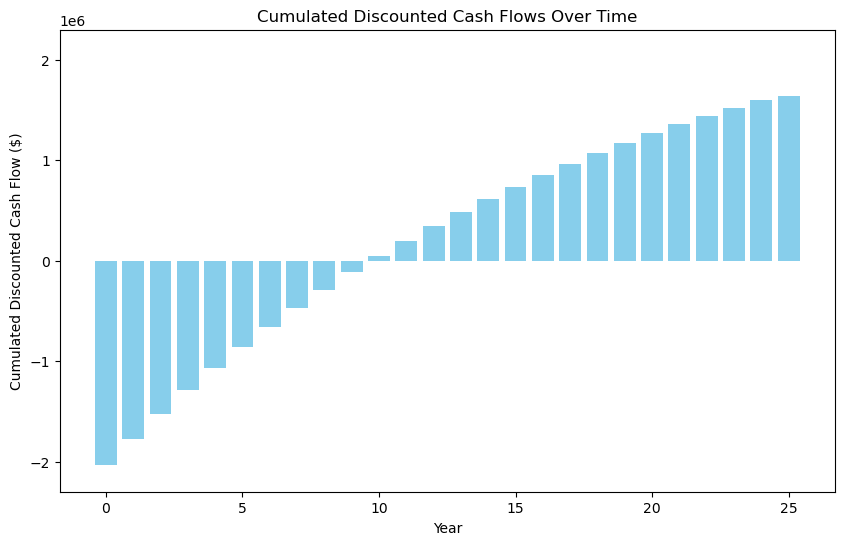

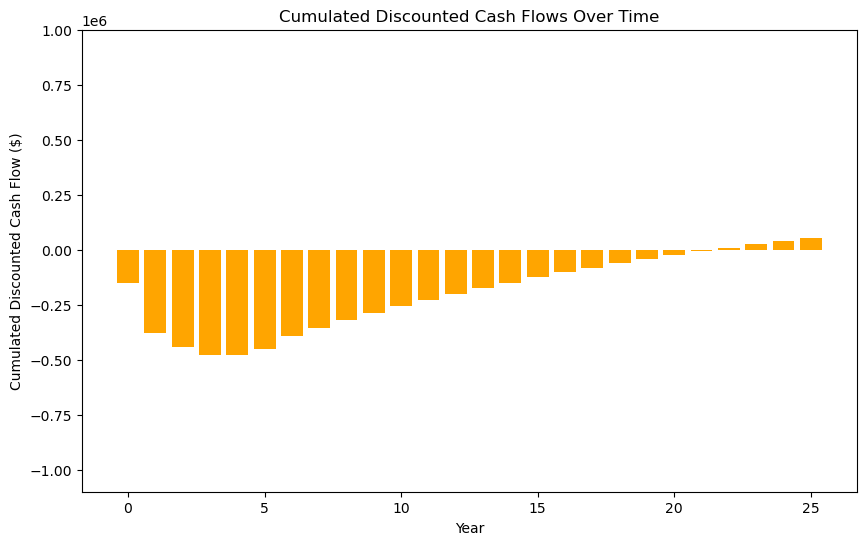

In [59]:
financial_tool_AV.plot_cumulated_discounted_cash_flows('PV', color = 'skyblue', y_min=-2300000, y_max=2300000)
financial_tool_AV.plot_cumulated_discounted_cash_flows('agri', color = 'orange', y_min=-1100000, y_max=1000000)
#financial_tool_AV.plot_cumulated_discounted_cash_flows()


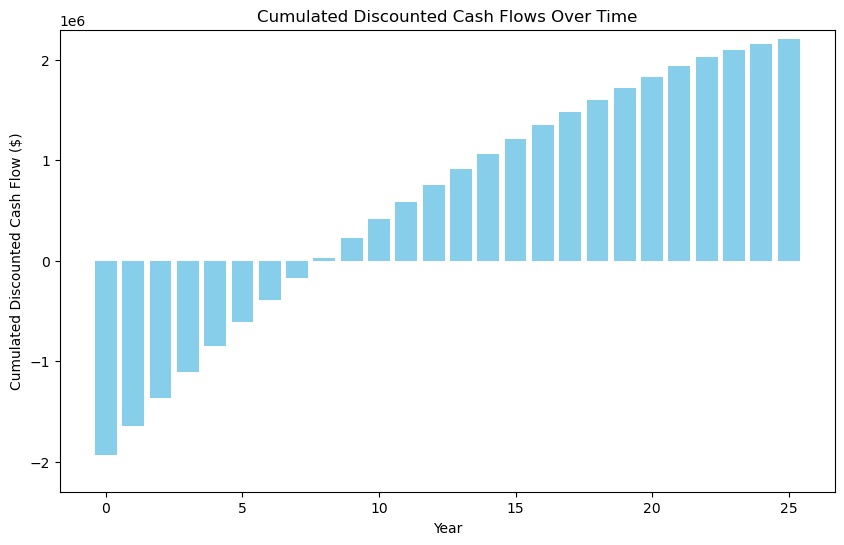

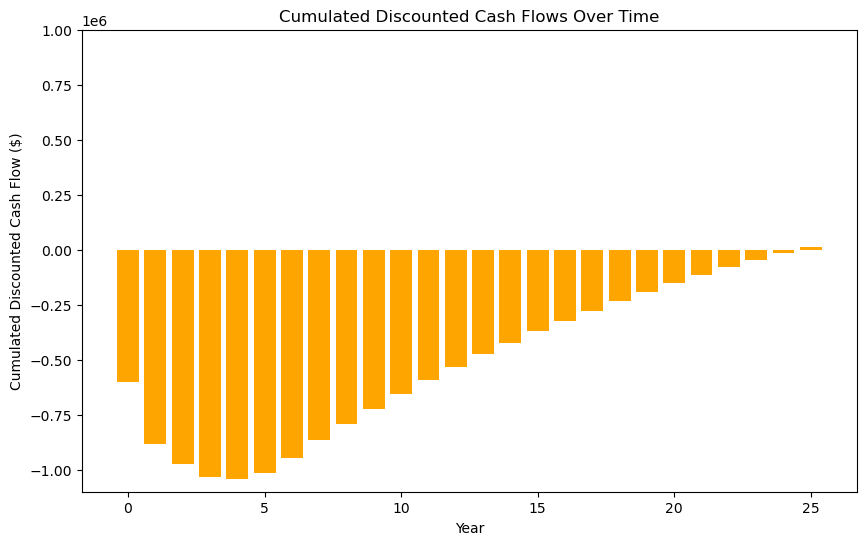

In [60]:
financial_tool_tradPV.plot_cumulated_discounted_cash_flows(color='skyblue',y_min=-2300000, y_max=2300000)
financial_tool_tradagri.plot_cumulated_discounted_cash_flows(color='orange', y_min=-1100000, y_max=1000000)

## DCF Tables (all scenarios)

In [61]:
financial_tool_AV.print_dcf_table(category='PV')

                                                       Year 0        Year 1  \
PV PBI Revenues ($/yr)                           0.000000e+00  0.000000e+00   
PV SREC Revenues ($/yr)                          0.000000e+00  3.735000e+05   
PV base Revenues ($/yr)                          0.000000e+00  2.114010e+05   
PV total Revenues ($/yr)                         0.000000e+00  5.849010e+05   
PV COGS ($/yr)                                   0.000000e+00  0.000000e+00   
PV Gross Profit ($/yr)                           0.000000e+00  5.849010e+05   
PV Operational Costs  OPEX($/yr)                 0.000000e+00  8.298000e+04   
PV Depreciation ($/yr)                           0.000000e+00  8.645995e+05   
PV Operating Income ($/yr)                       0.000000e+00 -3.626785e+05   
PV Other Income ($/yr)                           0.000000e+00  0.000000e+00   
PV EBIT ($/yr)                                   0.000000e+00 -3.626785e+05   
PV Annual Debt Payment ($/yr)                    0.0

In [62]:
financial_tool_AV.remaining_debt

[3051527.7965051774,
 2991872.40258543,
 2928935.962000096,
 2862538.017182569,
 2792488.185400078,
 2718585.61286955,
 2640618.398849843,
 2558362.9880590523,
 2471583.529674768,
 2380031.201079348,
 2283443.49441118,
 2181543.4638762623,
 2074038.9316619243,
 1960621.650175798,
 1840966.4182079346,
 1714730.1484818386,
 1581550.8839208074,
 1441046.7598089194,
 1292814.9088708777,
 1136430.3061312437,
 971444.5502409298,
 797384.5777766487,
 613751.306826832,
 420018.2059747755,
 215629.78457585583,
 -4.423782229423523e-09]

In [63]:
financial_tool_AV.carryover

[0,
 1525763.8982525887,
 1525763.8982525887,
 1525763.8982525887,
 1525763.8982525887,
 1525763.8982525887,
 1504636.8366447294,
 1430443.953727965,
 1355430.2019018563,
 1279547.130545897,
 1202743.727629265,
 1124966.2731226215,
 1046158.1840908269,
 966259.8509999401,
 885208.4647459103,
 802937.8338849827,
 719378.1915169333,
 634455.9912417422,
 548093.6915781258,
 460209.52819837275,
 370717.2732980775,
 279525.9813815358,
 186539.72070363618,
 91657.2895669531,
 0,
 0]

In [64]:
financial_tool_AV.print_dcf_table(category='agri')

                                                        Year 0         Year 1  \
Crop Revenues ($/yr)                                  0.000000       0.000000   
Agri Costs of Goods Sold ($/yr)                       0.000000  217403.403542   
Agri Gross Profit ($/yr)                              0.000000 -217403.403542   
Agri Land Payments ($/yr)                             0.000000       0.000000   
Agri Operational Costs OPEX ($/yr)                    0.000000   22507.008867   
Agri Depreciation ($/yr)                              0.000000    8402.491187   
Agri Operating Income ($/yr)                          0.000000 -248312.903596   
Agri Other Income ($/yr)                              0.000000       0.000000   
Agri EBIT ($/yr)                                      0.000000 -248312.903596   
Agri EBT ($/yr)                                       0.000000 -248312.903596   
Less: Agri State Income Tax ($/yr)                    0.000000       0.000000   
Less: Agri Federal Income Ta

In [65]:
financial_tool_tradPV.print_dcf_table()

                                                       Year 0        Year 1  \
PV PBI Revenues ($/yr)                           0.000000e+00  0.000000e+00   
PV SREC Revenues ($/yr)                          0.000000e+00  3.735000e+05   
PV base Revenues ($/yr)                          0.000000e+00  2.114010e+05   
PV total Revenues ($/yr)                         0.000000e+00  5.849010e+05   
PV COGS ($/yr)                                   0.000000e+00  0.000000e+00   
Gross Profit ($/yr)                              0.000000e+00  5.849010e+05   
PV Operational Costs OPEX ($/yr)                 0.000000e+00  6.168240e+04   
Depreciation ($/yr)                              0.000000e+00  8.227917e+05   
PV Operating Income ($/yr)                       0.000000e+00 -2.995731e+05   
PV Other Income ($/yr)                           0.000000e+00  0.000000e+00   
PV EBIT ($/yr)                                   0.000000e+00 -2.995731e+05   
Annual Debt Payment ($/yr)                       0.0

In [66]:
financial_tool_tradagri.print_dcf_table()

                                                   Year 0         Year 1  \
Crop Revenues ($/yr)                                  0.0       0.000000   
Costs of Goods Sold (VC) ($/yr)                       0.0  242604.600000   
Gross Profit ($/yr)                                   0.0 -242604.600000   
Operational Costs OPEX ($/yr)                         0.0   51368.100000   
Depreciation ($/yr)                                   0.0    9649.500000   
Operating Income ($/yr)                               0.0 -303622.200000   
Other Income ($/yr)                                   0.0       0.000000   
EBIT ($/yr)                                           0.0 -303622.200000   
EBT ($/yr)                                            0.0 -303622.200000   
Less: State Income Tax ($/yr)                         0.0       0.000000   
Less: Federal Income Tax ($/yr)                       0.0       0.000000   
Net Income ($/yr)                                     0.0 -303622.200000   
Plus: Deprec

In [67]:
financial_tool_AV.generate_agri_budget_table()

,Year 1,Year 2,Year 3,Year 4,Year 5,Year 6,Production Years
Revenues,0.000000,0.000000,92186.131488,183704.247530,275890.379019,368076.510507,372752.618626
Land Lease Revenues,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Variable Cost: Establishment & Soil Preparation,169954.262943,0.000000,0.000000,0.000000,0.000000,0.000000,7655.393986
Variable Cost: Field Activities,20502.831238,23323.734774,37373.678604,39505.822504,47467.959169,47466.077312,49677.259203
Variable Cost: Harvest Activities,0.000000,0.000000,12019.420203,24040.722264,36060.142467,47535.706018,54092.095558
Variable Cost: Packing & Handling Charges,0.000000,0.000000,26167.220593,52334.441186,78501.661780,104667.000516,117751.551741
Variable Cost: Maintenance & Repairs,3048.608224,5606.051791,5952.313465,5952.313465,5952.313465,5952.313465,5952.313465
Variable Cost: Other Variable Costs,23897.701137,3573.646308,10882.778619,16680.779816,23197.650360,28664.444738,26340.351431
Fixed Cost: Machine Equipment & Building Depreciation,8402.491187,10694.592926,10694.592926,10694.592926,15244.922979,15244.922979,15244.922979
Fixed Cost: Land Depreciation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [68]:
financial_tool_tradagri.generate_agri_budget_table()

,Year 1,Year 2,Year 3,Year 4,Year 5,Year 6,Production Years
Revenues,0.0,0.0,110587.68,220374.0,330961.68,441549.36,496843.2
Land Lease Revenues,0.0,0.0,0.00,0.0,0.00,0.00,0.0
Variable Cost: Establishment & Soil Preparation,189655.2,0.0,0.00,0.0,0.00,0.00,8542.8
Variable Cost: Field Activities,22879.5,26027.4,41706.00,44085.3,52970.40,52968.30,55435.8
Variable Cost: Harvest Activities,0.0,0.0,13412.70,26827.5,40240.20,53046.00,60362.4
Variable Cost: Packing & Handling Charges,0.0,0.0,29200.50,58401.0,87601.50,116799.90,131401.2
Variable Cost: Maintenance & Repairs,3402.0,6255.9,6642.30,6642.3,6642.30,6642.30,6642.3
Variable Cost: Other Variable Costs,26667.9,3987.9,12144.30,18614.4,25886.70,31987.20,29393.7
Fixed Cost: Machine Equipment & Building Depreciation,9376.5,11934.3,11934.30,11934.3,17012.10,17012.10,17012.1
Fixed Cost: Land Depreciation,273.0,273.0,273.00,273.0,273.00,273.00,273.0


## Sensitivity Analysis and Breakeven point

### NPV vs Discount rate

NPV for 0.00% discount rate: 4520409.74
NPV for 1.00% discount rate: 3759046.77
NPV for 2.00% discount rate: 3117447.11
NPV for 3.00% discount rate: 2573929.36
NPV for 4.00% discount rate: 2111101.83
NPV for 5.00% discount rate: 1714956.68
NPV for 6.00% discount rate: 1374165.59
NPV for 7.00% discount rate: 1079530.07
NPV for 8.00% discount rate: 823550.92
NPV for 9.00% discount rate: 600089.79
NPV for 10.00% discount rate: 404102.24
NPV for 11.00% discount rate: 231426.36
NPV for 12.00% discount rate: 78614.90
NPV for 13.00% discount rate: -57198.59
NPV for 14.00% discount rate: -178406.85
NPV for 15.00% discount rate: -287014.79


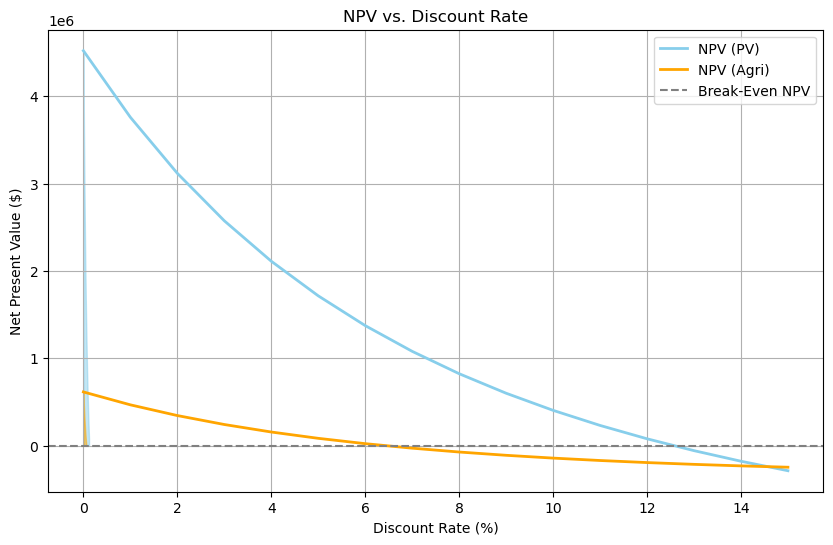

In [69]:
financial_tool_AV.plot_npv_vs_discount_rate(rate_range=(0, 0.15), step=0.01, category='both')

Rowspasing before:  16.6
Ground CLearance before:  6.6
Total arrays before:  80.86253369272237
area pv before: 3.4943541518490564
area agri before: 17.505645848150944
total area before:  21.0
Intermediate row spacing: 16.60 ft.
Unit CAPEX values extrapolated for all scales based on 0.5 MW input:
  0.2 MW: $2.27/W
  0.5 MW: $1.92/W
  1 MW: $1.76/W
  5 MW: $1.61/W
  10 MW: $1.52/W
  15 MW: $1.47/W
  20 MW: $1.43/W
Best Trendline: Power
R² Value: 0.9544
Coefficients: (-0.089524266135645, 1.8574496354585432)
CAPEX calculated using Power trendline: $988,181.09
Updated ground clearance to 6.6 ft compared to conventional 4.6 ft
Original CAPEX: $988,181.09. Increased by $5,916.00 due to ground clearance change.
New CAPEX: $994,097.09
Rowspasing after:  16.6
Ground CLearance after:  6.6
Total arrays after:  13.477088948787062
area pv after: 0.5823923586415094
area agri after: 2.9176076413584906
total area after:  3.5
NPV for 500 kW at 0.00% discount rate: 548426.11
NPV for 500 kW at 1.00% disco

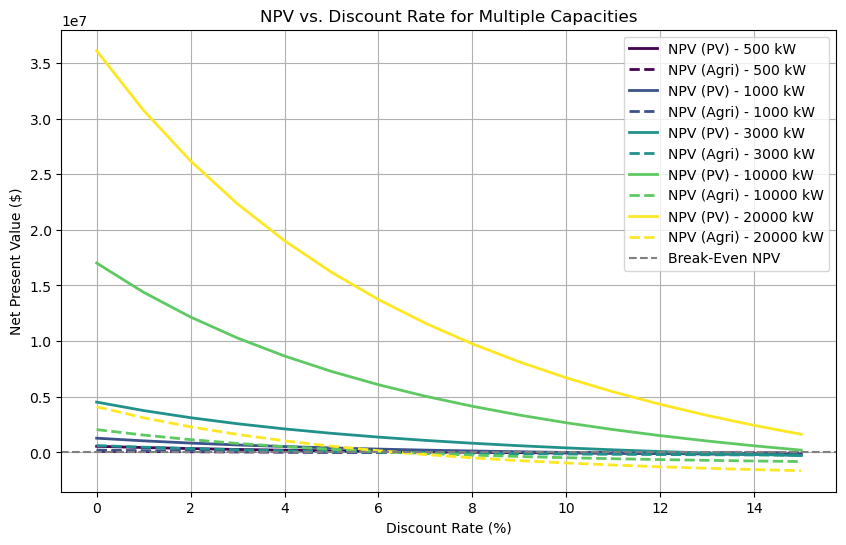

In [70]:
financial_tool_AV.plot_npv_vs_discount_rate(rate_range=(0, 0.15), step=0.01, category='both', capacities=[500, 1000, 3000, 10000, 20000])

Intermediate row spacing: 16.60 ft.
Unit CAPEX values extrapolated for all scales based on 0.5 MW input:
  0.2 MW: $2.27/W
  0.5 MW: $1.92/W
  1 MW: $1.76/W
  5 MW: $1.61/W
  10 MW: $1.52/W
  15 MW: $1.47/W
  20 MW: $1.43/W
Best Trendline: Power
R² Value: 0.9544
Coefficients: (-0.089524266135645, 1.8574496354585432)
CAPEX calculated using Power trendline: $5,050,383.66
Updated ground clearance to 6.6 ft compared to conventional 4.6 ft
Original CAPEX: $5,050,383.66. Increased by $35,496.00 due to ground clearance change.
New CAPEX: $5,085,879.66
NPV for 3000 kW and 15 years at 0.00% discount rate: 1170208.10
NPV for 3000 kW and 15 years at 1.00% discount rate: 1021274.76
NPV for 3000 kW and 15 years at 2.00% discount rate: 873979.14
NPV for 3000 kW and 15 years at 3.00% discount rate: 730564.19
NPV for 3000 kW and 15 years at 4.00% discount rate: 592496.09
NPV for 3000 kW and 15 years at 5.00% discount rate: 460676.13
NPV for 3000 kW and 15 years at 6.00% discount rate: 335598.05
NPV fo

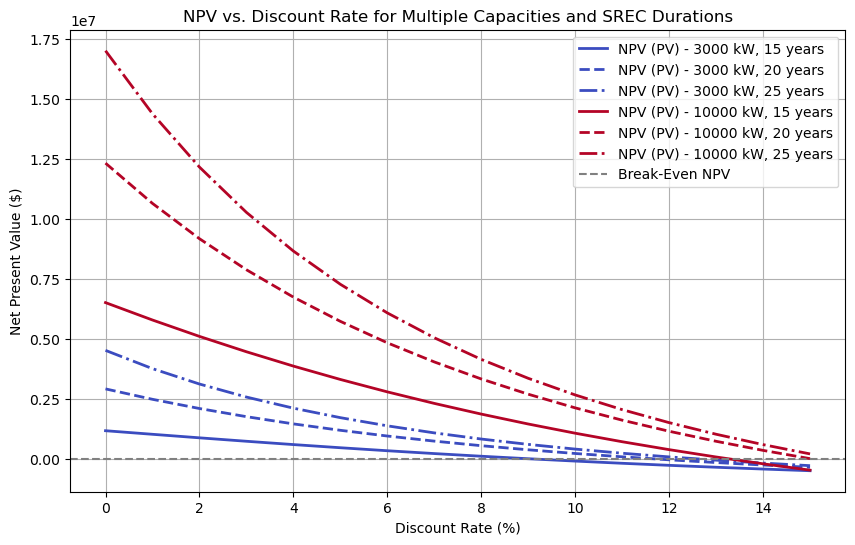

In [71]:
financial_tool_AV.plot_npv_vs_discount_rate(rate_range=(0, 0.15), step=0.01, category='both', capacities=[3000, 10000], srec_incentives_duration=[15, 20, 25])

### NPV vs energy price SREC incentives

NPV for 0.00 $/kWh SREC incentives: -3297682.15
NPV for 0.01 $/kWh SREC incentives: -2800956.06
NPV for 0.02 $/kWh SREC incentives: -2304229.97
NPV for 0.03 $/kWh SREC incentives: -1807503.88
NPV for 0.04 $/kWh SREC incentives: -1310777.79
NPV for 0.05 $/kWh SREC incentives: -814051.71
NPV for 0.06 $/kWh SREC incentives: -317325.62
NPV for 0.07 $/kWh SREC incentives: 179400.47
NPV for 0.08 $/kWh SREC incentives: 676126.56
NPV for 0.09 $/kWh SREC incentives: 1172852.65
NPV for 0.10 $/kWh SREC incentives: 1640201.85
NPV for 0.11 $/kWh SREC incentives: 2092596.62
NPV for 0.12 $/kWh SREC incentives: 2542500.06
NPV for 0.13 $/kWh SREC incentives: 2990092.08
NPV for 0.14 $/kWh SREC incentives: 3435593.09
NPV for 0.15 $/kWh SREC incentives: 3874365.24
NPV for 0.16 $/kWh SREC incentives: 4310071.92
NPV for 0.17 $/kWh SREC incentives: 4743980.60
NPV for 0.18 $/kWh SREC incentives: 5176472.87
NPV for 0.19 $/kWh SREC incentives: 5606871.19
NPV for 0.20 $/kWh SREC incentives: 6036290.31
NPV for 0.

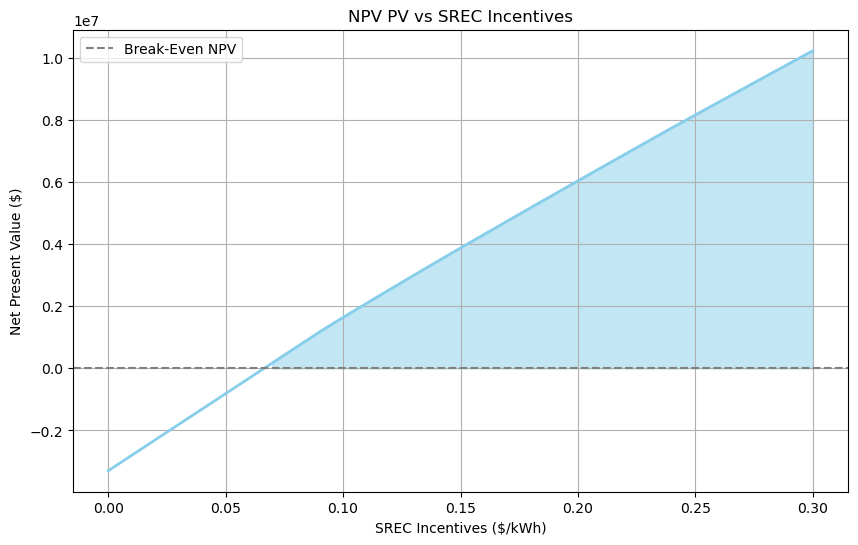

In [72]:
financial_tool_AV.plot_npv_vs_srec_incentives(incentives_range=(0, 0.3), step=0.01)

Intermediate row spacing: 16.60 ft.
Unit CAPEX values extrapolated for all scales based on 0.5 MW input:
  0.2 MW: $2.27/W
  0.5 MW: $1.92/W
  1 MW: $1.76/W
  5 MW: $1.61/W
  10 MW: $1.52/W
  15 MW: $1.47/W
  20 MW: $1.43/W
Best Trendline: Power
R² Value: 0.9544
Coefficients: (-0.089524266135645, 1.8574496354585432)
CAPEX calculated using Power trendline: $988,181.09
Updated ground clearance to 6.6 ft compared to conventional 4.6 ft
Original CAPEX: $988,181.09. Increased by $5,916.00 due to ground clearance change.
New CAPEX: $994,097.09
NPV for 500 kW at 0.00 $/kWh SREC incentives: -698633.30
NPV for 500 kW at 0.01 $/kWh SREC incentives: -615845.62
NPV for 500 kW at 0.02 $/kWh SREC incentives: -533057.94
NPV for 500 kW at 0.03 $/kWh SREC incentives: -450270.26
NPV for 500 kW at 0.04 $/kWh SREC incentives: -367482.58
NPV for 500 kW at 0.05 $/kWh SREC incentives: -284694.90
NPV for 500 kW at 0.06 $/kWh SREC incentives: -201907.21
NPV for 500 kW at 0.07 $/kWh SREC incentives: -119119.53


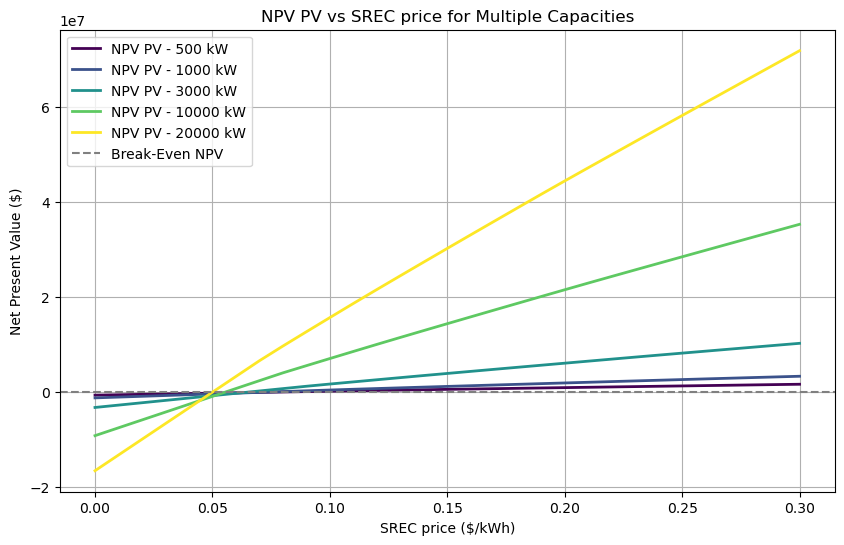

In [73]:
financial_tool_AV.plot_npv_vs_srec_incentives(incentives_range=(0, 0.3), step=0.01, capacities=[500, 1000, 3000, 10000, 20000])

In [74]:
breakeven_price = financial_tool_AV.find_breakeven_srec_incentives()

Breakeven SREC incentives found: $0.0664/MWh with NPV PV AV ~ 0.
Difference from the initial SREC incentives: $-0.0336/MWh


### NPV vs energy price

NPV for 0.02 $/kWh base energy price: -534175.81
NPV for 0.02 $/kWh base energy price: -473963.94
NPV for 0.02 $/kWh base energy price: -413752.06
NPV for 0.02 $/kWh base energy price: -353540.19
NPV for 0.02 $/kWh base energy price: -293328.32
NPV for 0.03 $/kWh base energy price: -233116.45
NPV for 0.03 $/kWh base energy price: -172904.57
NPV for 0.03 $/kWh base energy price: -112692.70
NPV for 0.03 $/kWh base energy price: -52480.83
NPV for 0.03 $/kWh base energy price: 7731.05
NPV for 0.03 $/kWh base energy price: 67942.92
NPV for 0.03 $/kWh base energy price: 128154.79
NPV for 0.03 $/kWh base energy price: 188366.66
NPV for 0.03 $/kWh base energy price: 248578.54
NPV for 0.03 $/kWh base energy price: 308790.41
NPV for 0.04 $/kWh base energy price: 369002.28
NPV for 0.04 $/kWh base energy price: 429214.16
NPV for 0.04 $/kWh base energy price: 489426.03
NPV for 0.04 $/kWh base energy price: 549637.90
NPV for 0.04 $/kWh base energy price: 609849.77
NPV for 0.04 $/kWh base energy pric

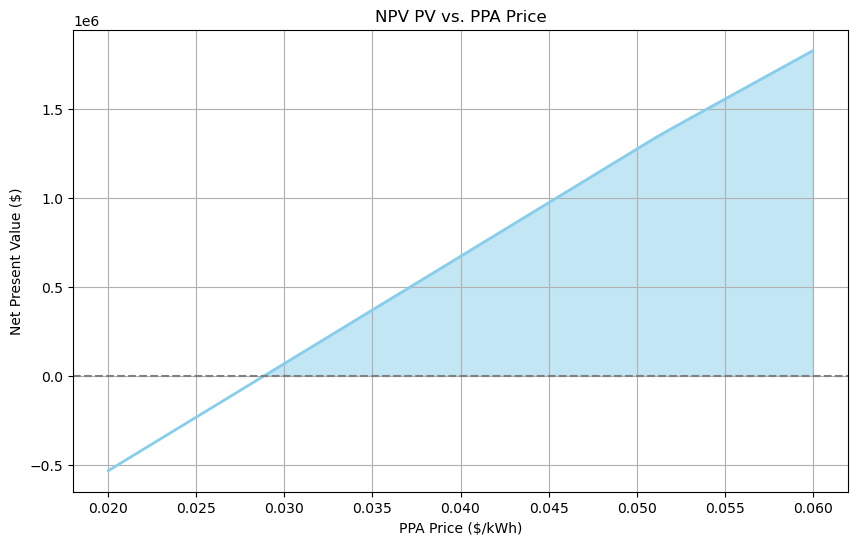

In [75]:
financial_tool_AV.plot_npv_vs_energy_price(price_range=(0.02, 0.06), step=0.001)

Intermediate row spacing: 16.60 ft.
Unit CAPEX values extrapolated for all scales based on 0.5 MW input:
  0.2 MW: $2.27/W
  0.5 MW: $1.92/W
  1 MW: $1.76/W
  5 MW: $1.61/W
  10 MW: $1.52/W
  15 MW: $1.47/W
  20 MW: $1.43/W
Best Trendline: Power
R² Value: 0.9544
Coefficients: (-0.089524266135645, 1.8574496354585432)
CAPEX calculated using Power trendline: $988,181.09
Updated ground clearance to 6.6 ft compared to conventional 4.6 ft
Original CAPEX: $988,181.09. Increased by $5,916.00 due to ground clearance change.
New CAPEX: $994,097.09
NPV for 500 kW at 0.02 $/kWh base energy price: -238048.91
NPV for 500 kW at 0.02 $/kWh base energy price: -228013.60
NPV for 500 kW at 0.02 $/kWh base energy price: -217978.29
NPV for 500 kW at 0.02 $/kWh base energy price: -207942.98
NPV for 500 kW at 0.02 $/kWh base energy price: -197907.66
NPV for 500 kW at 0.03 $/kWh base energy price: -187872.35
NPV for 500 kW at 0.03 $/kWh base energy price: -177837.04
NPV for 500 kW at 0.03 $/kWh base energy pr

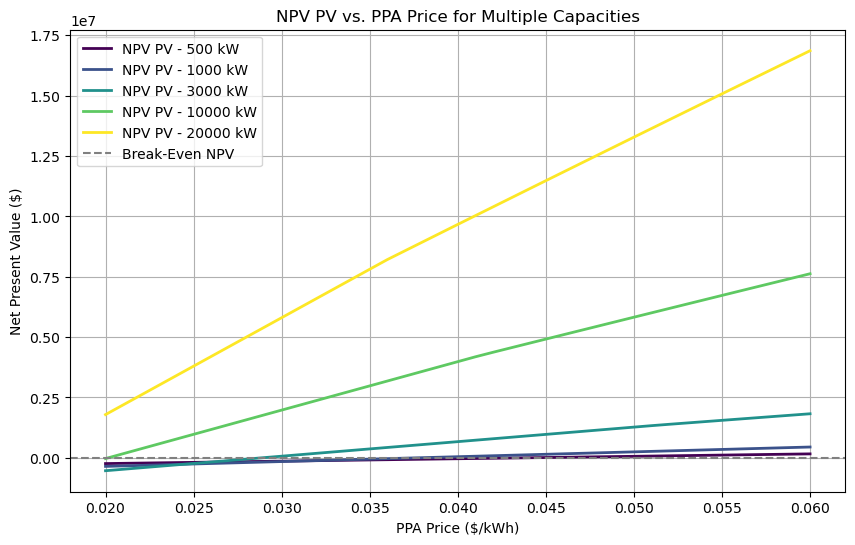

In [76]:
financial_tool_AV.plot_npv_vs_energy_price(price_range=(0.02, 0.06), step=0.001, capacities=[500, 1000, 3000, 10000, 20000])

In [77]:
breakeven_price = financial_tool_AV.find_breakeven_energy_price()
#print(f"Breakeven Energy Price: ${breakeven_price:.4f} per kWh")

Breakeven base energy price found: $0.0289/kWh with NPV PV AV ~ 0.
Difference from the initial base price: $-0.0277/kWh


### NPV vs crop prices

NPV for BLUEBERRIES, TAME at 0.00 $/t: -3801850.10
NPV for BLUEBERRIES, TAME at 5.00 $/t: -3796798.28
NPV for BLUEBERRIES, TAME at 10.00 $/t: -3791746.46
NPV for BLUEBERRIES, TAME at 15.00 $/t: -3786694.64
NPV for BLUEBERRIES, TAME at 20.00 $/t: -3781642.82
NPV for BLUEBERRIES, TAME at 25.00 $/t: -3776591.00
NPV for BLUEBERRIES, TAME at 30.00 $/t: -3771539.18
NPV for BLUEBERRIES, TAME at 35.00 $/t: -3766487.37
NPV for BLUEBERRIES, TAME at 40.00 $/t: -3761435.55
NPV for BLUEBERRIES, TAME at 45.00 $/t: -3756383.73
NPV for BLUEBERRIES, TAME at 50.00 $/t: -3751331.91
NPV for BLUEBERRIES, TAME at 55.00 $/t: -3746280.09
NPV for BLUEBERRIES, TAME at 60.00 $/t: -3741228.27
NPV for BLUEBERRIES, TAME at 65.00 $/t: -3736176.45
NPV for BLUEBERRIES, TAME at 70.00 $/t: -3731124.63
NPV for BLUEBERRIES, TAME at 75.00 $/t: -3726072.81
NPV for BLUEBERRIES, TAME at 80.00 $/t: -3721020.99
NPV for BLUEBERRIES, TAME at 85.00 $/t: -3715969.17
NPV for BLUEBERRIES, TAME at 90.00 $/t: -3710917.35
NPV for BLUEBE

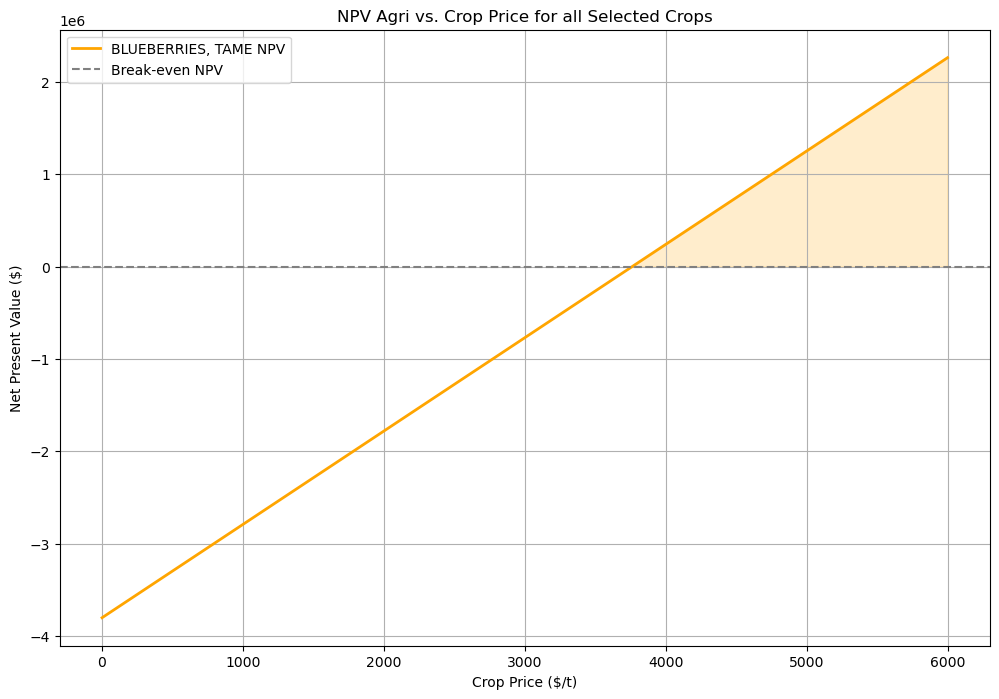

In [78]:
# Plot NPV variation for all crops in the selected range
financial_tool_AV.plot_npv_vs_all_crop_prices(price_range=(0, 6000), step=5)

Intermediate row spacing: 16.60 ft.
Unit CAPEX values extrapolated for all scales based on 0.5 MW input:
  0.2 MW: $2.27/W
  0.5 MW: $1.92/W
  1 MW: $1.76/W
  5 MW: $1.61/W
  10 MW: $1.52/W
  15 MW: $1.47/W
  20 MW: $1.43/W
Best Trendline: Power
R² Value: 0.9544
Coefficients: (-0.089524266135645, 1.8574496354585432)
CAPEX calculated using Power trendline: $988,181.09
Updated ground clearance to 6.6 ft compared to conventional 4.6 ft
Original CAPEX: $988,181.09. Increased by $5,916.00 due to ground clearance change.
New CAPEX: $994,097.09
NPV for BLUEBERRIES, TAME at 0.00 $/t and 500 kW: -633641.68
NPV for BLUEBERRIES, TAME at 100.00 $/t and 500 kW: -616802.29
NPV for BLUEBERRIES, TAME at 200.00 $/t and 500 kW: -599962.89
NPV for BLUEBERRIES, TAME at 300.00 $/t and 500 kW: -583123.49
NPV for BLUEBERRIES, TAME at 400.00 $/t and 500 kW: -566284.09
NPV for BLUEBERRIES, TAME at 500.00 $/t and 500 kW: -549444.69
NPV for BLUEBERRIES, TAME at 600.00 $/t and 500 kW: -532605.29
NPV for BLUEBERRI

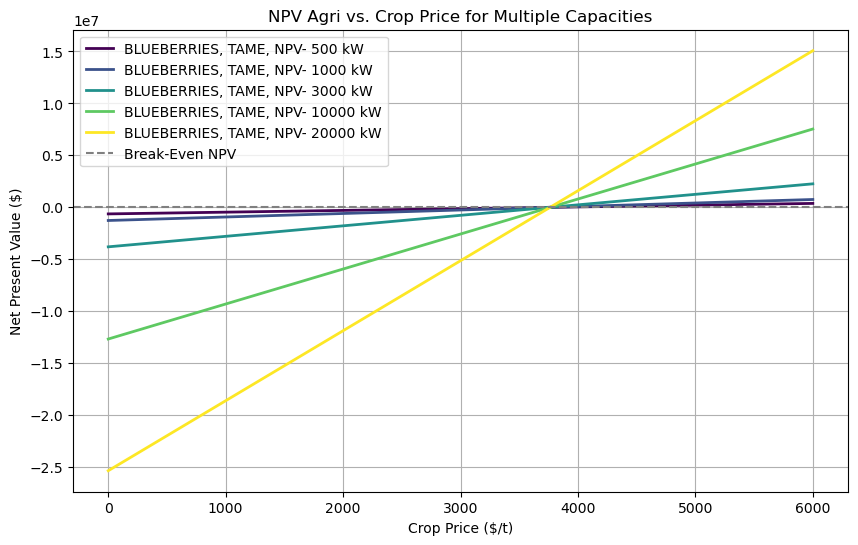

In [79]:
financial_tool_AV.plot_npv_vs_all_crop_prices(price_range=(0, 6000), step=100, capacities=[500, 1000, 3000, 10000, 20000])

In [80]:
# Find the breakeven price for "BLUEBERRIES, TAME"
financial_tool_AV.find_breakeven_crop_price("BLUEBERRIES, TAME")

Breakeven crop price for BLUEBERRIES, TAME found: $3762.8523/t with NPV ~ 0.
Difference from original crop price: $-53.1477/t


3762.8523034614773

### NPV vs AV crop costs

NPV for gamma 1.00: 308413.98
NPV for gamma 1.01: 274451.92
NPV for gamma 1.02: 240489.86
NPV for gamma 1.03: 206527.79
NPV for gamma 1.04: 172565.73
NPV for gamma 1.05: 138603.67
NPV for gamma 1.06: 104641.61
NPV for gamma 1.07: 70679.54
NPV for gamma 1.08: 36717.48
NPV for gamma 1.09: 2755.42
NPV for gamma 1.10: -31206.64
NPV for gamma 1.11: -65168.70
NPV for gamma 1.12: -99130.77
NPV for gamma 1.13: -133092.83
NPV for gamma 1.14: -167054.89
NPV for gamma 1.15: -201016.95
NPV for gamma 1.16: -234979.01
NPV for gamma 1.17: -268941.08
NPV for gamma 1.18: -302903.14
NPV for gamma 1.19: -336865.20
NPV for gamma 1.20: -370827.26
NPV for gamma 1.21: -404789.32
NPV for gamma 1.22: -438751.39
NPV for gamma 1.23: -472713.45
NPV for gamma 1.24: -506675.51
NPV for gamma 1.25: -540637.57
NPV for gamma 1.26: -574599.64
NPV for gamma 1.27: -608561.70
NPV for gamma 1.28: -642523.76
NPV for gamma 1.29: -676485.82
NPV for gamma 1.30: -710447.88
NPV for gamma 1.31: -744409.95
NPV for gamma 1.32: -7783

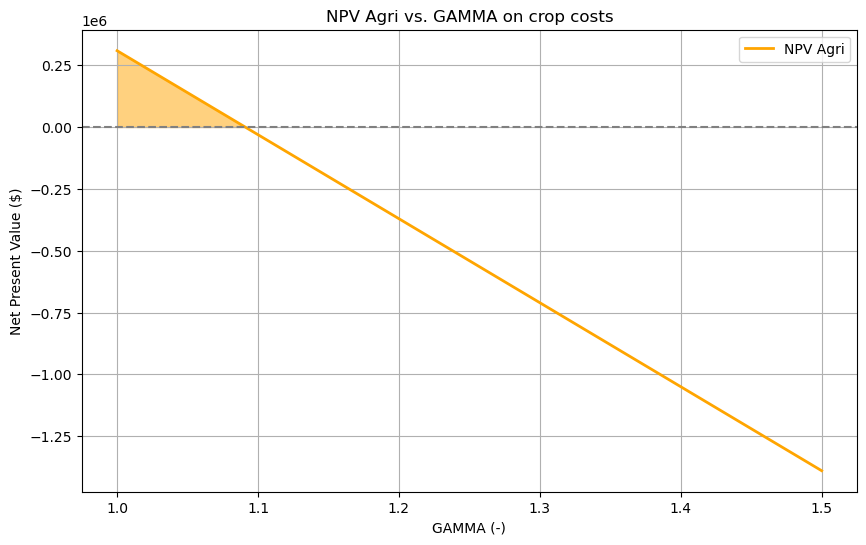

In [81]:
financial_tool_AV.plot_npv_vs_gamma(gamma_range=(1, 1.5), step=0.01)

Intermediate row spacing: 16.60 ft.
Unit CAPEX values extrapolated for all scales based on 0.5 MW input:
  0.2 MW: $2.27/W
  0.5 MW: $1.92/W
  1 MW: $1.76/W
  5 MW: $1.61/W
  10 MW: $1.52/W
  15 MW: $1.47/W
  20 MW: $1.43/W
Best Trendline: Power
R² Value: 0.9544
Coefficients: (-0.089524266135645, 1.8574496354585432)
CAPEX calculated using Power trendline: $988,181.09
Updated ground clearance to 6.6 ft compared to conventional 4.6 ft
Original CAPEX: $988,181.09. Increased by $5,916.00 due to ground clearance change.
New CAPEX: $994,097.09
NPV for 500 kW at gamma 1.00: 51402.33
NPV for 500 kW at gamma 1.01: 45741.99
NPV for 500 kW at gamma 1.02: 40081.64
NPV for 500 kW at gamma 1.03: 34421.30
NPV for 500 kW at gamma 1.04: 28760.96
NPV for 500 kW at gamma 1.05: 23100.61
NPV for 500 kW at gamma 1.06: 17440.27
NPV for 500 kW at gamma 1.07: 11779.92
NPV for 500 kW at gamma 1.08: 6119.58
NPV for 500 kW at gamma 1.09: 459.24
NPV for 500 kW at gamma 1.10: -5201.11
NPV for 500 kW at gamma 1.11: 

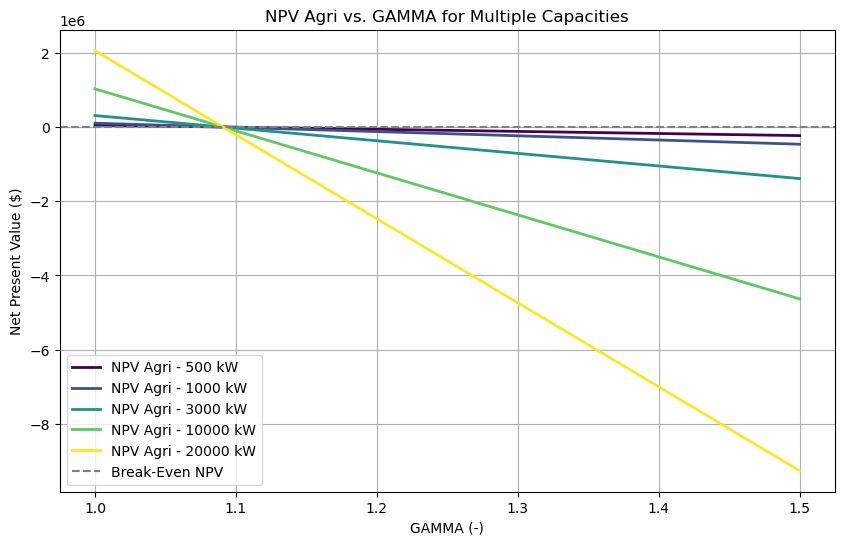

In [82]:
financial_tool_AV.plot_npv_vs_gamma(gamma_range=(1, 1.5), step=0.01, capacities=[500, 1000, 3000, 10000, 20000])

In [83]:
financial_tool_AV.find_breakeven_gamma()

Breakeven gamma found: 1.0908 with NPV agri ~ 0.
Difference from the initial gamma: 0.0158


1.09081132306585

### NPV vs crop yields

NPV for BLUEBERRIES, TAME at 2.00 t/acre: -1967143.47
NPV for BLUEBERRIES, TAME at 2.50 t/acre: -1684902.97
NPV for BLUEBERRIES, TAME at 3.00 t/acre: -1402662.47
NPV for BLUEBERRIES, TAME at 3.50 t/acre: -1120421.97
NPV for BLUEBERRIES, TAME at 4.00 t/acre: -838181.47
NPV for BLUEBERRIES, TAME at 4.50 t/acre: -555940.97
NPV for BLUEBERRIES, TAME at 5.00 t/acre: -273700.47
NPV for BLUEBERRIES, TAME at 5.50 t/acre: 8540.03
NPV for BLUEBERRIES, TAME at 6.00 t/acre: 290780.53
NPV for BLUEBERRIES, TAME at 6.50 t/acre: 573021.03
NPV for BLUEBERRIES, TAME at 7.00 t/acre: 855261.53


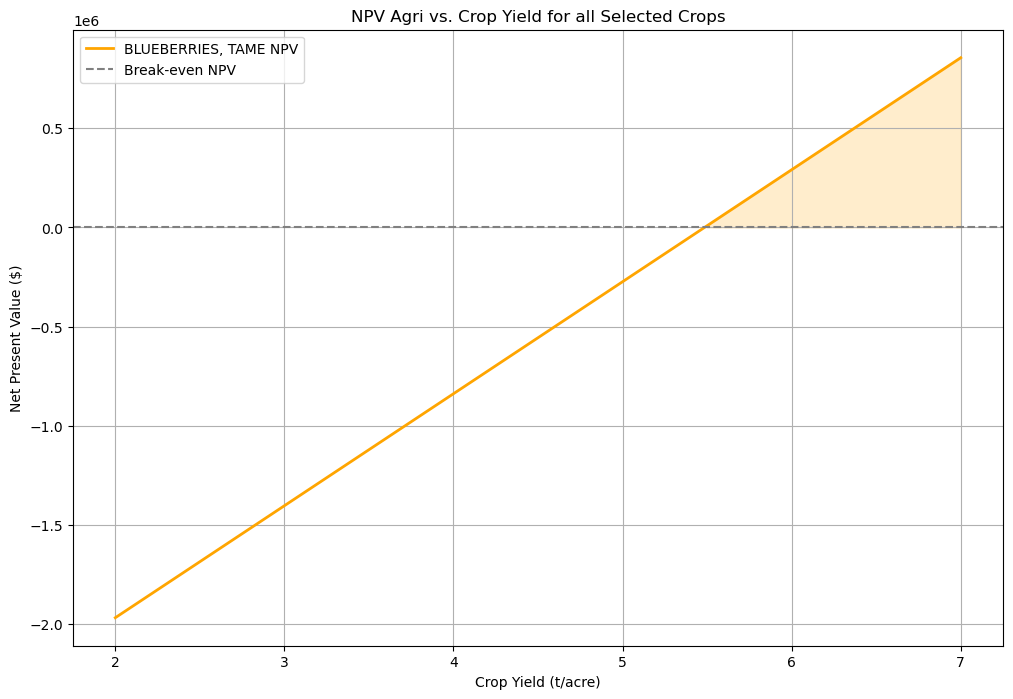

In [84]:
financial_tool_AV.plot_npv_vs_all_crop_yields(yield_range=(2, 7), step=0.5)

Intermediate row spacing: 16.60 ft.
Unit CAPEX values extrapolated for all scales based on 0.5 MW input:
  0.2 MW: $2.27/W
  0.5 MW: $1.92/W
  1 MW: $1.76/W
  5 MW: $1.61/W
  10 MW: $1.52/W
  15 MW: $1.47/W
  20 MW: $1.43/W
Best Trendline: Power
R² Value: 0.9544
Coefficients: (-0.089524266135645, 1.8574496354585432)
CAPEX calculated using Power trendline: $988,181.09
Updated ground clearance to 6.6 ft compared to conventional 4.6 ft
Original CAPEX: $988,181.09. Increased by $5,916.00 due to ground clearance change.
New CAPEX: $994,097.09
NPV for BLUEBERRIES, TAME at 2.00 t/acre and 500 kW: -327857.24
NPV for BLUEBERRIES, TAME at 2.10 t/acre and 500 kW: -318449.23
NPV for BLUEBERRIES, TAME at 2.20 t/acre and 500 kW: -309041.21
NPV for BLUEBERRIES, TAME at 2.30 t/acre and 500 kW: -299633.19
NPV for BLUEBERRIES, TAME at 2.40 t/acre and 500 kW: -290225.18
NPV for BLUEBERRIES, TAME at 2.50 t/acre and 500 kW: -280817.16
NPV for BLUEBERRIES, TAME at 2.60 t/acre and 500 kW: -271409.14
NPV for 

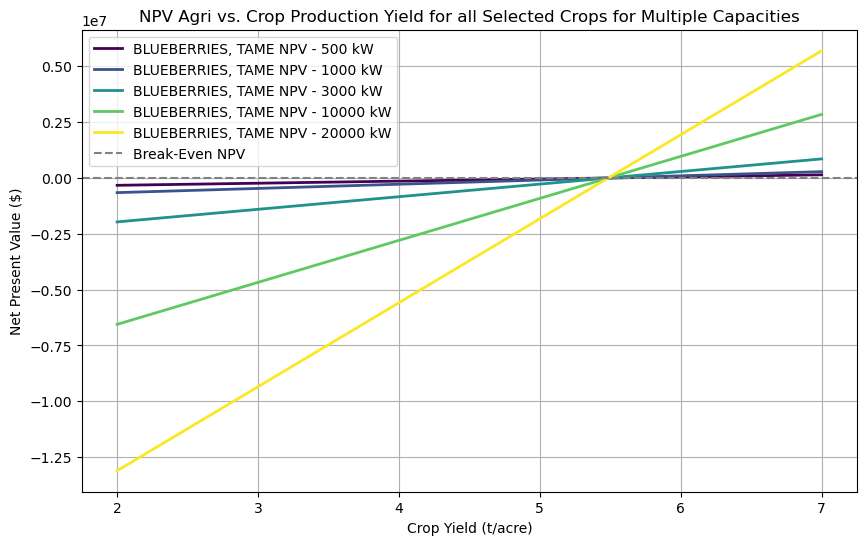

In [85]:
financial_tool_AV.plot_npv_vs_all_crop_yields(yield_range=(2, 7), step=0.1, capacities=[500, 1000, 3000, 10000, 20000])

In [86]:
financial_tool_AV.find_breakeven_crop_yield("BLUEBERRIES, TAME")
#financial_tool_AV.find_breakeven_crop_yield("CORN, GRAIN")
#financial_tool_AV.find_breakeven_crop_yield("SOYBEANS")

Testing yield: 27.9000 t/acre, NPV: 12652914.4499
Testing yield: 13.9500 t/acre, NPV: 4778404.4897
Testing yield: 6.9750 t/acre, NPV: 841149.5096
Testing yield: 3.4875 t/acre, NPV: -1127477.9805
Testing yield: 5.2312 t/acre, NPV: -143164.2354
Testing yield: 6.1031 t/acre, NPV: 348992.6371
Testing yield: 5.6672 t/acre, NPV: 102914.2008
Testing yield: 5.4492 t/acre, NPV: -20125.0173
Testing yield: 5.5582 t/acre, NPV: 41394.5918
Testing yield: 5.5037 t/acre, NPV: 10634.7872
Testing yield: 5.4765 t/acre, NPV: -4745.1150
Testing yield: 5.4901 t/acre, NPV: 2944.8361
Testing yield: 5.4833 t/acre, NPV: -900.1395
Testing yield: 5.4867 t/acre, NPV: 1022.3483
Testing yield: 5.4850 t/acre, NPV: 61.1044
Testing yield: 5.4841 t/acre, NPV: -419.5175
Testing yield: 5.4846 t/acre, NPV: -179.2066
Testing yield: 5.4848 t/acre, NPV: -59.0511
Testing yield: 5.4849 t/acre, NPV: 1.0267
Testing yield: 5.4848 t/acre, NPV: -29.0122
Testing yield: 5.4848 t/acre, NPV: -13.9928
Testing yield: 5.4849 t/acre, NPV: -

5.4848709991963

### NPV vs change in rowspacing

In [ ]:
financial_tool_AV.plot_npv_vs_rowspacing_change(change_range=(-5, 30), step=1)

In [ ]:
financial_tool_AV.find_breakeven_rowspacing_change(change_range=(-10, 60), tolerance=0.01, category='PV')

In [ ]:
financial_tool_AV.find_breakeven_rowspacing_change(change_range=(-10, 30), tolerance=0.01, category='agri')

### SD to Farmer Payments

#### Partnership A 

NPV Agri for farmer payment of $0.0000/acre: 53698.51
NPV PV for farmer payment of $0.0000/acre: 1640201.85
NPV Agri for farmer payment of $100.0000/acre: 91299.28
NPV PV for farmer payment of $100.0000/acre: 1605347.83
NPV Agri for farmer payment of $200.0000/acre: 128900.05
NPV PV for farmer payment of $200.0000/acre: 1570417.29
NPV Agri for farmer payment of $300.0000/acre: 166500.82
NPV PV for farmer payment of $300.0000/acre: 1535486.74
NPV Agri for farmer payment of $400.0000/acre: 204101.59
NPV PV for farmer payment of $400.0000/acre: 1500556.19
NPV Agri for farmer payment of $500.0000/acre: 241702.35
NPV PV for farmer payment of $500.0000/acre: 1465625.65
NPV Agri for farmer payment of $600.0000/acre: 279303.12
NPV PV for farmer payment of $600.0000/acre: 1430695.10
NPV Agri for farmer payment of $700.0000/acre: 316903.89
NPV PV for farmer payment of $700.0000/acre: 1395764.56
NPV Agri for farmer payment of $800.0000/acre: 354504.66
NPV PV for farmer payment of $800.0000/acre: 

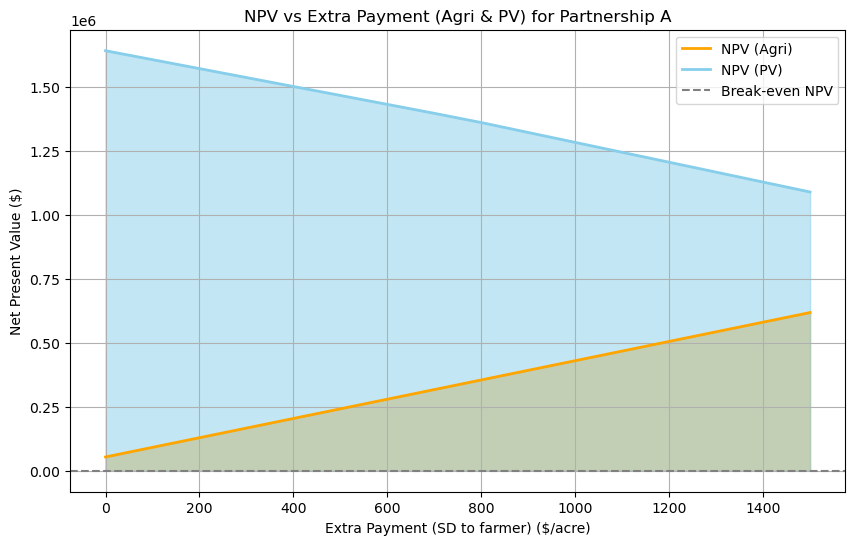

In [87]:
financial_tool_AV.plot_npv_vs_extra_farmer_payment(payment_range=(0, 1500), step=100)

In [88]:
financial_tool_AV.get_optimal_extra_farmer_payment()

'Breakeven Land lease payment calculation did not converge.'

#### Partnership B

In [ ]:
financial_tool_AV.plot_npv_vs_land_lease_payment(payment_range=(0, 4000), step=100)

In [ ]:
financial_tool_AV.get_optimal_land_lease_payment()

# Export Tables to Excel

In [ ]:
# Export DCF tables to Excel files

filepath_dcf = '~/Library/CloudStorage/OneDrive-Personnel/Documents/EPFL/Master/Thesis/Cornell/Code/Data/dcf_table_blueberryA.xlsx'
filepath_budget = '~/Library/CloudStorage/OneDrive-Personnel/Documents/EPFL/Master/Thesis/Cornell/Code/Data/agri_budgets_blueberryA.xlsx'

# DCF tables
financial_tool_AV.export_dcf_to_excel(filepath_dcf, category='PV')
financial_tool_AV.export_dcf_to_excel(filepath_dcf, category='agri')
financial_tool_tradPV.export_dcf_to_excel(filepath_dcf)
financial_tool_tradagri.export_dcf_to_excel(filepath_dcf)

# Agri budget tables
financial_tool_AV.export_dcf_to_excel(filepath_budget, category='agri', table='budgets')
financial_tool_tradagri.export_dcf_to_excel(filepath_budget, table='budgets')



# Extra Plots

In [ ]:
# Data
capacity = np.array([0.5, 1, 3, 10, 20])
npv_energy = np.array([129243, 379486, 1640201, 7015276, 15649221])  
npv_agriculture = np.array([8951, 17902, 53705, 179016, 358033])


# Plot
plt.figure(figsize=(10, 6))
plt.scatter(capacity, npv_energy, color='blue', label='NPV Energy Data', zorder=5)
plt.plot(capacity, npv_energy, color='skyblue', linestyle='-', label='Energy Trend')

plt.scatter(capacity, npv_agriculture, color='red', label='NPV Agriculture Data', zorder=5)
plt.plot(capacity, npv_agriculture, color='orange', linestyle='-', label='Agriculture Trend')

# Add labels, title, and legend
plt.xlabel('Capacity (MW)', fontsize=12)
plt.ylabel('NPV ($)', fontsize=12)
plt.title('NPV Energy vs Agriculture vs Capacity', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [ ]:
# Parameters
slope = -0.089524266135645
exp_intercept = 1.8574496354585432

# Function to compute y
def compute_y(x, slope, exp_intercept):
    return exp_intercept * x**slope

# Generate x values and compute y
x_values = np.linspace(0.1, 20, 500)  # Avoid x = 0 to prevent division by zero
y_values = compute_y(x_values, slope, exp_intercept)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label=r"$y = 1.8574496354585432 \cdot x^{-0.089524266135645}$", color='skyblue')
plt.title("Unitary PV Capex vs System Capacity for Agrivoltaics", fontsize=14)
plt.xlabel("System Capacity [MW]", fontsize=12)
plt.ylabel("Unitary PV Capex [$/W]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()
